## PRGORAMME NAME

In [ ]:
PROG_NAME = "BIGMA_HAM_4H"

# Imports

In [ ]:
import os
os.environ["TF_GPU_THREAD_MODE"] = "gpu_private"
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import datetime
import json
import shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import zipfile
from keras import ops
from tqdm import tqdm
from typing import TypedDict, Literal,Union, List, Optional, Any
from collections import defaultdict
from sklearn.metrics.pairwise import cosine_similarity
import warnings
from collections import defaultdict

warnings.filterwarnings("ignore")

tf.config.optimizer.set_jit(True)

# Dataset

In [ ]:
def extract_zip(src_path, targ_path):
    with zipfile.ZipFile(src_path,"r") as zip_ref:
        zip_ref.extractall(targ_path)

In [ ]:
TRAIN_DIR = '../data/train'
TEST_DIR = '../data/test'
BASE_PATH = '../data/'
BATCH_SIZE = 2
HEIGHT, WIDTH = 224, 224

In [ ]:
extract_zip(BASE_PATH + 'ham_train.zip', TRAIN_DIR)
extract_zip(BASE_PATH + 'ham_test.zip', TEST_DIR)

In [ ]:
TRAIN_DATAGEN = ImageDataGenerator(
    rescale=1.0/255,
)

TEST_DATAGEN = ImageDataGenerator(
    rescale = 1.0/255
)

train_generator = TRAIN_DATAGEN.flow_from_directory(
    TRAIN_DIR,
    target_size=(HEIGHT, WIDTH),
    batch_size= BATCH_SIZE,
    class_mode='categorical',
    # shuffle = False,
)

test_generator = TEST_DATAGEN.flow_from_directory(
    TEST_DIR,
    target_size = (HEIGHT, WIDTH),
    batch_size = BATCH_SIZE,
    class_mode = 'categorical',
)

TOTAL_TRAIN_SAMPLES = train_generator.n
TOTAL_VAL_SAMPLES = test_generator.n
CLASSMAP = train_generator.class_indices
NUM_LAB = len(train_generator.class_indices.keys())

Found 8010 images belonging to 7 classes.
Found 2005 images belonging to 7 classes.


# Metrics

In [ ]:
class MulticlassMetrics:
    def __init__(self, num_classes, average='macro'):
        self.num_classes = num_classes
        self.average = average
        self.reset_state()

    def reset_state(self):
        try:
            del self.predictions
            del self.ground_truths
        except:
            pass
        self.predictions = []
        self.ground_truths = []

    def update_state(self, predictions, ground_truths):
        if len(predictions.shape) == 2 and predictions.shape[1] == self.num_classes:
            predictions = tf.argmax(predictions, axis=1)
        if len(ground_truths.shape) == 2 and ground_truths.shape[1] == self.num_classes:
            ground_truths = tf.argmax(ground_truths, axis=1)
        self.predictions.append(predictions.numpy())
        self.ground_truths.append(ground_truths.numpy())

    def result(self):
        predictions = tf.concat(self.predictions, axis=0)
        ground_truths = tf.concat(self.ground_truths, axis=0)
        acc = tf.reduce_mean(tf.cast(tf.equal(predictions, ground_truths), tf.float32))

        cm = tf.math.confusion_matrix(ground_truths, predictions, num_classes=self.num_classes)
        cm = tf.cast(cm, tf.float32)
        tp = tf.linalg.diag_part(cm)
        fp = tf.reduce_sum(cm, axis=0) - tp
        fn = tf.reduce_sum(cm, axis=1) - tp
        tn = tf.reduce_sum(cm) - (tp + fp + fn)

        precision_per_class = tp / (tp + fp + 1e-10)
        recall_per_class = tp / (tp + fn + 1e-10)
        f1_per_class = 2 * (precision_per_class * recall_per_class) / (precision_per_class + recall_per_class + 1e-10)
        specificity_per_class = tn / (tn + fp + 1e-10)

        if self.average == 'micro':
            precision = tf.reduce_sum(tp) / (tf.reduce_sum(tp) + tf.reduce_sum(fp) + 1e-10)
            recall = tf.reduce_sum(tp) / (tf.reduce_sum(tp) + tf.reduce_sum(fn) + 1e-10)
            f1 = 2 * (precision * recall) / (precision + recall + 1e-10)
            specificity = tf.reduce_sum(tn) / (tf.reduce_sum(tn) + tf.reduce_sum(fp) + 1e-10)
        elif self.average == 'macro':
            precision = tf.reduce_mean(precision_per_class)
            recall = tf.reduce_mean(recall_per_class)
            f1 = tf.reduce_mean(f1_per_class)
            specificity = tf.reduce_mean(specificity_per_class)
        elif self.average == 'weighted':
            weights = tf.reduce_sum(cm, axis=1) / tf.reduce_sum(cm)
            precision = tf.reduce_sum(precision_per_class * weights)
            recall = tf.reduce_sum(recall_per_class * weights)
            f1 = tf.reduce_sum(f1_per_class * weights)
            specificity = tf.reduce_sum(specificity_per_class * weights)
        else:
            raise ValueError("Invalid average type. Choose from ['micro', 'macro', 'weighted', 'NUM_CLASS'].")

        return {
            'accuracy': acc,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'specificity': specificity
        }

In [ ]:
class MeanTracker:
  def __init__(self):
    self.metric_results = defaultdict(list)

  def update_state(self, metrics):
    for metric_name, metric_value in metrics.items():
      self.metric_results[metric_name].append(metric_value)

  def result(self):
    return {metric_name: tf.reduce_mean(metric_values) for metric_name, metric_values in self.metric_results.items()}

  def reset_state(self):
    del self.metric_results
    self.metric_results = defaultdict(list)

# Model Components


## Component: SE Block

In [ ]:
@tf.keras.utils.register_keras_serializable(package="SqueezeExcitationLayer")
class SqueezeExcitation(tf.keras.layers.Layer):
    def __init__(self, channels, reduction_ratio=16, **kwargs):
        assert "name" in kwargs
        super(SqueezeExcitation, self).__init__(**kwargs)
        self.channels = channels
        self.reduction_ratio = reduction_ratio
        self.name = kwargs["name"]

    def build(self, input_shape):
        self.global_pooling = tf.keras.layers.GlobalAveragePooling2D(name = self.name + "_global_pooling")
        self.squeeze_conv = tf.keras.layers.Conv2D(
            filters=input_shape[-1] // self.reduction_ratio,
            kernel_size=(1, 1),
            activation='relu',
            kernel_initializer='he_normal',
            use_bias=False,
            name = self.name + "_squeeze_conv"
        )
        self.excitation_conv = tf.keras.layers.Conv2D(
            filters=self.channels,
            kernel_size=(1, 1),
            activation='sigmoid',
            kernel_initializer='he_normal',
            use_bias=False,
            name = self.name + "_excitation_conv"
        )
        super(SqueezeExcitation, self).build(input_shape)

    def call(self, inputs):
        x = self.global_pooling(inputs)
        x = tf.keras.layers.Reshape((1, 1, self.channels))(x)
        x = self.squeeze_conv(x)
        x = self.excitation_conv(x)
        return inputs * x

    def compute_output_shape(self, input_shape):
        return input_shape

## Component: FeatureProjection Block

In [ ]:
@tf.keras.utils.register_keras_serializable(package="FeatureProjectionLayer")
class FeatureProjectionLayer(tf.keras.layers.Layer):
    def __init__(self, projection_dim, **kwargs):
        assert "name" in kwargs
        super(FeatureProjectionLayer, self).__init__(**kwargs)
        self.projection_dim = projection_dim
        self.name = kwargs["name"]

    def build(self, input_shape):
        self.point_conv = tf.keras.layers.Conv2D(
            filters=self.projection_dim,
            kernel_size=(1, 1),
            activation='relu',
            kernel_initializer='he_normal',
            use_bias=False,
            name = self.name + "_point_conv"
        )

        self.se = SqueezeExcitation(channels=self.projection_dim, reduction_ratio=16, name = self.name + "_se")
        super(FeatureProjectionLayer, self).build(input_shape)

    def call(self, inputs):
        x = self.point_conv(inputs)
        x = self.se(x)
        return x

## Component: Channel Attention Block

In [ ]:
@tf.keras.utils.register_keras_serializable(package="ChannelAttentionLayer")
class ChannelAttentionLayer(tf.keras.layers.Layer):
    def __init__(self, projection_dim, num_heads, **kwargs):
        assert "name" in kwargs
        super(ChannelAttentionLayer, self).__init__(**kwargs)
        self.projection_dim = projection_dim
        self.num_heads = num_heads
        self.name = kwargs["name"]

    def build(self, input_shape):
        self.projectors = [
            FeatureProjectionLayer(projection_dim=self.projection_dim, name = f"{self.name}_projector_{i}")
            for i in range(self.num_heads)
        ]

    def call(self, inputs):
      projection_outputs = [projector(inputs) for projector in self.projectors]
      return projection_outputs

## Component: Binary Thresholding

In [ ]:
@tf.keras.utils.register_keras_serializable(package="BinaryThresholding")
class BinaryThresholding(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        assert "name" in kwargs
        super(BinaryThresholding, self).__init__(**kwargs)
        self.name = kwargs["name"]

    def call(self, input):
      return tf.cast(input > tf.reduce_mean(input, axis=[1,2], keepdims=True), dtype=tf.float32)

## Component: Spatial Attention Adapter

In [ ]:
@tf.keras.utils.register_keras_serializable(package="SpatAttentionAdapter")
class SpatAttentionAdapter(tf.keras.layers.Layer):
    def __init__(self, down_sample_order,**kwargs):
        assert "name" in kwargs
        super(SpatAttentionAdapter, self).__init__(**kwargs)
        self.name = kwargs["name"]
        self.down_sample_order = down_sample_order

    def build(self, input_shape):
        self.se = SqueezeExcitation(channels=input_shape[-1], reduction_ratio=16, name = self.name + "_se")
        # self.point_conv = tf.keras.layers.Conv2D(
        #     filters=1,
        #     kernel_size=(1, 1),
        #     activation='relu',
        #     kernel_initializer='he_normal',
        #     use_bias=False,
        #     name = self.name + "_point_conv"
        # )
        self.pool = tf.keras.layers.AveragePooling2D(pool_size=(self.down_sample_order, self.down_sample_order), name = self.name + "_pool")

    def call(self, inputs):
        x = inputs
        # x = self.se(x)
        # x = self.point_conv(x)
        x = self.pool(x)
        # # min max normalize
        # x = (x-tf.reduce_min(x, axis=[1,2], keepdims=True))/(tf.reduce_max(x, axis=[1,2], keepdims=True)-tf.reduce_min(x, axis=[1,2], keepdims=True)+1e-9)
        # # Sigmoid
        # x = tf.keras.activations.sigmoid(2*x)
        # x = tf.cast(x > tf.reduce_mean(x, axis=[1,2], keepdims=True), dtype=tf.float32)
        return x


## Component: Spatial Attention Gen

In [ ]:
@tf.keras.utils.register_keras_serializable(package="SpatAttentionGen")
class SpatAttentionGen(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        assert "name" in kwargs
        super(SpatAttentionGen, self).__init__(**kwargs)
        self.name = kwargs["name"]

    def build(self, input_shape):
      self.conv = tf.keras.layers.Conv2D(
          filters=1,
          kernel_size=3,
          activation='sigmoid',
          padding='same',
          name = self.name + "_conv"
      )
      self.binary_thresholding = BinaryThresholding(name = self.name + "_binary_thresholding")

    def call(self, inputs):
      concat_result = tf.keras.layers.Concatenate(axis=-1, name = self.name + "_concat0")(inputs)  # (BatchSize x 7 x 7 x C)
      avg_pool = tf.reduce_mean(concat_result, axis=-1, keepdims=True, name = self.name + "_avg_pool")  # (BatchSize x 7 x 7 x 1)
      # max_pool = tf.reduce_max(concat_result, axis=-1, keepdims=True, name = self.name + "_max_pool")  # (BatchSize x 7 x 7 x 1)
      # pooled_features = tf.keras.layers.Concatenate(axis=-1, name = self.name + "_concat1")([avg_pool, max_pool])  # (BatchSize x 7 x 7 x 2)
      # spatial_attention_map = self.conv(pooled_features)  # (BatchSize x 7 x 7 x 1)
      # return spatial_attention_map
      activated_pool = tf.keras.activations.sigmoid(avg_pool)
      return activated_pool
      # binarized_mask = self.binary_thresholding(activated_pool)
      # return binarized_mask

In [ ]:
# sample_tensor = tf.random.normal(shape=(3, 64, 64, 128))
# g = SpatAttentionGen(name="spatial_adapter")
# output = g([sample_tensor, sample_tensor, sample_tensor])
# print(output.shape)

## Component: Channel Pruning Layer

In [ ]:
@tf.keras.utils.register_keras_serializable(package="ChannelPruningLayer")
class ChannelPruningLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        assert "name" in kwargs
        super(ChannelPruningLayer, self).__init__(**kwargs)
        self.name = kwargs["name"]

    def call(self, input):
      channel_wise_variance = tf.math.reduce_variance(input, axis=[1,2], keepdims=True)
      mean_var = tf.reduce_mean(channel_wise_variance)
      mask = tf.cast(channel_wise_variance > mean_var, dtype=tf.float32)
      relevant_features = input * mask
      map = tf.reduce_sum(relevant_features, axis=-1, keepdims=True) / tf.reduce_sum(mask, axis=-1, keepdims=True)
      return map


# Function Implementaion
def channel_pruning_layer(input):
  channel_wise_variance = tf.math.reduce_variance(input, axis=[1,2], keepdims=True)
  mean_var = tf.reduce_mean(channel_wise_variance)
  mask = tf.cast(channel_wise_variance > mean_var, dtype=tf.float32)
  relevant_features = input * mask
  map = tf.reduce_sum(relevant_features, axis=-1, keepdims=True) / tf.reduce_sum(mask, axis=-1, keepdims=True)
  return map

## Component: Vector Sampling Layer

In [ ]:
@tf.keras.utils.register_keras_serializable(package="VectorSamplingLayer")
class VectorSamplingLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        assert "name" in kwargs
        super(VectorSamplingLayer, self).__init__(**kwargs)
        self.name = kwargs["name"]

    def call(self, input):
      """
      feat : (batch_size, height, width, channels)
      mask : (batch_size, height, width, 1)
      # noise : (batch_size, batch_size, height, width, 1)
      """
      feat , mask = input
      fg = mask * feat # (batch_size, height, width, channels)
      bg = (1-mask)*feat # (batch_size, height, width, channels)

      bg_flat = tf.reshape(bg, (-1, bg.shape[-1])) # (batch_size*height*width, channels)
      bg_flat_sampled = tf.keras.random.shuffle(bg_flat, axis=0) # (batch_size*height*width, channels)
      sampled_bg = tf.reshape(bg_flat_sampled, (-1, bg.shape[1], bg.shape[2], bg.shape[3])) # (batch_size, height, width, channels)
      sampled_bg_masked = (1-mask)*sampled_bg # (batch_size, height, width, channels)

      augmented_feat = fg + sampled_bg_masked # (batch_size, height, width, channels)
      return augmented_feat

In [ ]:
# sample_x = tf.random.normal(shape=(3, 64, 64, 128))
# sample_mask = tf.random.normal(shape=(3, 64, 64, 1))
# # sample_noise = tf.random.normal(shape=(3, 3, 64, 64, 1))
# sample_input = [sample_x, sample_mask]#, sample_noise]
# v = VectorSamplingLayer(name="vector_sampling")
# output = v(sample_input)
# print(output.shape)

## Component: Classification Head

In [ ]:
@tf.keras.utils.register_keras_serializable(package="ClassificationHead")
class ClassificationHead(tf.keras.layers.Layer):
  def __init__(self, num_classes, temp=1.0, return_prob=True, **kwargs):
    assert "name" in kwargs
    super(ClassificationHead, self).__init__(**kwargs)
    self.num_classes = num_classes
    self.temp = temp
    self.return_prob = return_prob
    self.name = kwargs["name"]

  def build(self, input_shape):
    self.global_pooling = tf.keras.layers.GlobalAveragePooling2D(name = self.name + "_global_pooling")
    self.dense = tf.keras.layers.Dense(
        units=self.num_classes,
        activation=None,
        kernel_initializer='he_normal',
        name = self.name + "_dense"
    )

  def call(self, inputs):
    x = self.global_pooling(inputs)
    x = self.dense(x)
    if self.return_prob:
      x = x / self.temp
      x = tf.keras.activations.softmax(x)
    return x

## Component: Post Feature Extraction

In [ ]:
# def post_feature_extraction(final_side_output,final_side_output_layer_name,num_classes, num_heads):
#     final_channel_activated_side_output = ChannelAttentionLayer(
#         name=f"CA_{final_side_output_layer_name}",
#         projection_dim=final_side_output.shape[-1],
#         num_heads=num_heads)(final_side_output)

#     final_channel_activated_concatenated_output = tf.keras.layers.Concatenate(
#         axis=-1,
#         name=f"CA_concat_{final_side_output_layer_name}")(final_channel_activated_side_output)

#     final_classification_result = ClassificationHead(
#         name=f"classification_head_{final_side_output_layer_name}",
#         num_classes=num_classes,
#         return_prob=True,
#         temp=1.0)(final_channel_activated_concatenated_output)

#     # Spatai map from different heads
#     final_channel_activated_side_output_spatial_maps = [
#         (tf.keras.activations.sigmoid(ChannelPruningLayer(name=f"CA_spatial_map_{final_side_output_layer_name}_{i}")(output)))
#         for i, output in enumerate(final_channel_activated_side_output)
#     ]
#     final_channel_activated_side_output_single_spatial_map = tf.keras.layers.Multiply(name=f"CA_single_spatial_map_{final_side_output_layer_name}")(final_channel_activated_side_output_spatial_maps)

#     return final_channel_activated_side_output_single_spatial_map, final_channel_activated_side_output, final_classification_result

In [ ]:
@tf.keras.utils.register_keras_serializable(package="PostFeatureExtraction")
class PostFeatureExtraction(tf.keras.layers.Layer):
    def __init__(self, num_classes, num_heads, final_side_output_layer_name, **kwargs):
        assert "name" in kwargs
        super(PostFeatureExtraction, self).__init__(**kwargs)
        self.num_classes = num_classes
        self.num_heads = num_heads
        self.final_side_output_layer_name = final_side_output_layer_name
        self.name = kwargs["name"]

    def build(self, input_shape):
        self.channel_attention_layer = ChannelAttentionLayer(
            name=f"CA_{self.final_side_output_layer_name}",
            projection_dim=input_shape[-1],
            num_heads=self.num_heads)

        self.channel_attention_concatenated_layer = tf.keras.layers.Concatenate(
            axis=-1,
            name=f"CA_concat_{self.final_side_output_layer_name}")

        self.classification_head = ClassificationHead(
            name=f"classification_head_{self.final_side_output_layer_name}",
            num_classes=self.num_classes,
            return_prob=False,
            temp=1.0)

        self.multiply_layer = tf.keras.layers.Multiply(name=f"CA_multiply_spatial_map_{self.final_side_output_layer_name}")

        super(PostFeatureExtraction, self).build(input_shape)

    def call(self, inputs):
      final_channel_activated_side_output = self.channel_attention_layer(inputs)
      final_channel_activated_concatenated_output = self.channel_attention_concatenated_layer(final_channel_activated_side_output)
      final_classification_result_logits = self.classification_head(final_channel_activated_concatenated_output)

      final_channel_activated_side_output_spatial_maps = [
          (tf.keras.activations.sigmoid(channel_pruning_layer(output)))
          for output in final_channel_activated_side_output
      ]
      final_channel_activated_side_output_single_spatial_map = self.multiply_layer(final_channel_activated_side_output_spatial_maps)

      return final_channel_activated_side_output_single_spatial_map, final_channel_activated_side_output, final_classification_result_logits

# Custom Model

In [ ]:
@tf.keras.utils.register_keras_serializable(package="MyModel")
class MyModel(keras.Model):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.setup_trackers()

    @property
    def metrics(self):
        return [
            ]

    def compile(self, loss_obj_dict, optimizer_obj):
        super().compile()
        self.loss_obj_dict = loss_obj_dict
        self.optimizer = optimizer_obj

    def setup_trackers(self):
        pass

    @tf.function
    def train_step(self, batch: tf.Tensor) -> tf.Tensor:
        x,y_true = batch

        with tf.GradientTape() as tape:
          tape.watch(x)
          side_outputs, single_spatial_map, [final_side_output,
                                          augmented_final_side_output
                                          ], [final_channel_activated_side_output_single_spatial_map,
                                              augmented_final_channel_activated_side_output_single_spatial_map
                                              ], [final_channel_activated_side_output,
                                                  augmented_final_channel_activated_side_output
                                                  ], probs = self(x, training=True)
          final_classification_result, augmented_final_classification_result , final_classification_result_soft, augmented_final_classification_result_soft = probs

          weights = self.trainable_variables

          kernel_loss ,  weighted_xentropy1, weighted_xentropy2, map_dist, kld_val = self.loss_obj_dict['HybridLoss'](y_true=y_true,
                                                 y_pred1=final_classification_result,
                                                 y_pred2=augmented_final_classification_result,
                                                 feature_blocks=final_channel_activated_side_output,
                                                 weights=weights,
                                                 map1=single_spatial_map,
                                                 map2=final_channel_activated_side_output_single_spatial_map,
                                                 softlogit1=final_classification_result_soft,
                                                 softlogit2=augmented_final_classification_result_soft)

          loss = self.loss_obj_dict['HybridLoss'].kernel_loss_factor * kernel_loss
          loss += self.loss_obj_dict['HybridLoss'].weighted_xentropy1_factor * weighted_xentropy1
          loss += self.loss_obj_dict['HybridLoss'].weighted_xentropy2_factor * weighted_xentropy2
          loss += self.loss_obj_dict['HybridLoss'].map_dist_factor * map_dist
          loss += self.loss_obj_dict['HybridLoss'].kld_factor * kld_val

        grad = tape.gradient(loss, weights)

        self.optimizer.apply_gradients(zip(grad, self.trainable_variables))

        return {
            "train_loss_metric": loss,
            "train_kernel_loss_metric": kernel_loss,
            "train_weighted_xentropy1_metric": weighted_xentropy1,
            "train_weighted_xentropy2_metric": weighted_xentropy2,
            "train_map_dist_metric": map_dist,
            "train_kld_metric": kld_val,
            "y_pred": final_classification_result,
            "y_true": y_true
        }

    def test_step(self, batch: tf.Tensor) -> tf.Tensor:
        x,y_true = batch
        side_outputs, single_spatial_map, [final_side_output,
                                          augmented_final_side_output
                                          ], [final_channel_activated_side_output_single_spatial_map,
                                              augmented_final_channel_activated_side_output_single_spatial_map
                                              ], [final_channel_activated_side_output,
                                                  augmented_final_channel_activated_side_output
                                                  ], probs = self(x, training=False)

        final_classification_result, augmented_final_classification_result , final_classification_result_soft, augmented_final_classification_result_soft = probs

        kernel_loss ,  weighted_xentropy1,weighted_xentropy2, map_dist, kld_val = self.loss_obj_dict['HybridLoss'](y_true=y_true,
                                                 y_pred1 = final_classification_result,
                                                 y_pred2 = augmented_final_classification_result,
                                                 feature_blocks=final_channel_activated_side_output,
                                                 weights = self.trainable_variables,
                                                 map1=single_spatial_map,
                                                 map2=final_channel_activated_side_output_single_spatial_map,
                                                 softlogit1=final_classification_result_soft,
                                                 softlogit2=augmented_final_classification_result_soft)

        loss = self.loss_obj_dict['HybridLoss'].kernel_loss_factor * kernel_loss
        loss += self.loss_obj_dict['HybridLoss'].weighted_xentropy1_factor * weighted_xentropy1
        loss += self.loss_obj_dict['HybridLoss'].weighted_xentropy2_factor * weighted_xentropy2
        loss += self.loss_obj_dict['HybridLoss'].map_dist_factor * map_dist
        loss += self.loss_obj_dict['HybridLoss'].kld_factor * kld_val

        # val_ is prepended internally
        return {
            "val_loss_metric": loss,
            "val_kernel_loss_metric": kernel_loss,
            "val_weighted_xentropy1_metric": weighted_xentropy1,
            "val_weighted_xentropy2_metric": weighted_xentropy2,
            "val_map_dist_metric": map_dist,
            "val_kld_metric": kld_val,
            "y_pred": final_classification_result,
            "y_true": y_true
        }

# Functional Model

In [ ]:
def build_model(input_shape, num_classes, num_heads, temperature, side_output_layer_names = ['pool3_relu','pool4_relu','relu']):

    pretrained_model = tf.keras.applications.DenseNet121(
      include_top=False ,
      weights='imagenet' ,
      input_shape=input_shape)

    inputs = pretrained_model.input

    side_outputs = [
        pretrained_model.get_layer(name).output
        for name in side_output_layer_names
    ]

    spatial_adapter_results = [
        SpatAttentionAdapter(down_sample_order=2**(len(side_output_layer_names)-i-1), name=f"spatial_adapter_{name}")(output)
        for i, (name, output) in enumerate(zip(side_output_layer_names, side_outputs))
    ]
    # single_spatial_map = tf.keras.layers.Multiply(name="single_spatial_map")(spatial_maps)

    single_spatial_map = SpatAttentionGen(name="single_spatial_map")(spatial_adapter_results)


    final_side_output_original,final_side_output_layer_name = side_outputs[-1], side_output_layer_names[-1]
    final_side_output = final_side_output_original #* single_spatial_map
    augmented_final_side_output = VectorSamplingLayer(name=f"vector_sampling_{final_side_output_layer_name}")([final_side_output_original, single_spatial_map])


    # Post Feature Extraction Layer
    post_feature_extraction_layer_object = PostFeatureExtraction(
        num_classes=num_classes,
        num_heads=num_heads,
        final_side_output_layer_name=final_side_output_layer_name,
        name="post_feature_extraction")

    # Post Feature Extraction
    final_channel_activated_side_output_single_spatial_map, final_channel_activated_side_output, final_classification_result_logits = post_feature_extraction_layer_object(final_side_output)

    # Post Feature Extraction with Augmented Feature
    augmented_final_channel_activated_side_output_single_spatial_map,  augmented_final_channel_activated_side_output, augmented_final_classification_result_logits = post_feature_extraction_layer_object(augmented_final_side_output)


    # Probabilties
    final_classification_result = tf.keras.activations.softmax(final_classification_result_logits)
    augmented_final_classification_result = tf.keras.activations.softmax(augmented_final_classification_result_logits)
    final_classification_result_soft = tf.keras.activations.softmax(final_classification_result_logits/temperature)
    augmented_final_classification_result_soft = tf.keras.activations.softmax(augmented_final_classification_result_logits/temperature)

    model = MyModel(inputs=inputs, outputs=[
        side_outputs,
        single_spatial_map,
        [
            final_side_output,
            augmented_final_side_output
        ],
        [
            final_channel_activated_side_output_single_spatial_map,
            augmented_final_channel_activated_side_output_single_spatial_map
        ],
        [
            final_channel_activated_side_output,
            augmented_final_channel_activated_side_output
        ],
        [
            final_classification_result,
            augmented_final_classification_result,
            final_classification_result_soft,
            augmented_final_classification_result_soft
        ]
    ])

    return model

# Loss Fucntion

## Weighted XCE

In [ ]:
class WeightedXCE():
    def __init__(self):
        self.name = "weighted_xentropy"

    def __call__(self, y_true, y_pred):
        """
        Args:
          y_true: 1 hot encoded array
          y_pred: Prediction with same shape as y_true
        """
        labels = tf.cast(tf.argmax(y_true, axis=1), dtype=tf.float32)
        class_freq = tf.reduce_sum(y_true, axis=0)+1e-9
        class_weights = 1./class_freq

        effective_weights = tf.reduce_sum(class_weights * y_true, axis = -1)

        unweighted_losses = tf.keras.losses.categorical_crossentropy(y_true, y_pred)

        weighted_losses = tf.multiply(unweighted_losses, effective_weights)
        return tf.reduce_mean(weighted_losses)

## Kernel Loss


- [ChatGPT Answer](https://chatgpt.com/share/678741ca-0e6c-800c-90e7-a9be47eaca67)
- [Lecture on Hilbert Schmidt Indepdency Criterion](https://www.youtube.com/watch?v=6Xp0i--pg5M&t=410s)


In [ ]:
def rbf_kernel_matrix_broadcast(X, Y, sigma):
    """
    Compute the RBF kernel matrix for a tensor using broadcasting.

    Args:
        X: Tensor of shape (B, N, D), where B is the batch size,
           N is the number of samples (flattened spatial dimensions),
           and D is the feature dimension.
        sigma: Bandwidth parameter for the RBF kernel.

    Returns:
        Kernel matrix of shape (B, N, N).
    """
    X_norm = tf.reduce_sum(tf.square(X), axis=-1, keepdims=True)  # Shape: (B, N, 1)
    Y_norm = tf.reduce_sum(tf.square(Y), axis=-1, keepdims=True)  # Shape: (B, N, 1)
    pairwise_distances = X_norm - 2 * tf.matmul(X, tf.transpose(Y, perm=[0, 2, 1])) + tf.transpose(Y_norm, perm=[0, 2, 1])  # Shape: (B, N, N)

    kernel_matrix = tf.exp(-pairwise_distances / (2 * sigma**2))
    return kernel_matrix

def mean_point_wise_hsic_score(block1, block2, sigma=1.0):
    """
    Compute the HSIC between two convolutional feature blocks using broadcasting.

    Args:
        block1: Tensor of shape (B, H, H, C), where B is the batch size,
                H x H are spatial dimensions, and C is the number of channels.
        block2: Tensor of shape (B, H, H, C), same dimensions as block1.
        sigma: Bandwidth parameter for the RBF kernel.

    Returns:
        HSIC values of shape (B, H^2), where each element represents the HSIC value for a spatial position.
    """
    B, H, _, C = block1.shape

    # Flatten the spatial dimensions (H x H) into a single dimension for each batch
    block1_flat = tf.reshape(block1, (-1, H * H, C))  # Shape: (B, H^2, C)
    block2_flat = tf.reshape(block2, (-1, H * H, C))  # Shape: (B, H^2, C)

    # Compute RBF kernel matrices
    K1 = rbf_kernel_matrix_broadcast(block1_flat,block1_flat, sigma)  # Shape: (B, H^2, H^2)
    K2 = rbf_kernel_matrix_broadcast(block2_flat,block2_flat, sigma)  # Shape: (B, H^2, H^2)

    # Center the kernel matrices
    n = H * H
    H_center = tf.eye(n) - tf.ones((n, n)) / tf.cast(n, tf.float32)  # Shape: (H^2, H^2)
    # H_center = tf.broadcast_to(H_center, (B, n, n))  # Shape: (B, H^2, H^2)
    H_center = tf.expand_dims(H_center, axis=0)

    K1_centered = tf.matmul(H_center, tf.matmul(K1, H_center))  # Shape: (B, H^2, H^2)
    K2_centered = tf.matmul(H_center, tf.matmul(K2, H_center))  # Shape: (B, H^2, H^2)

    # Compute HSIC values
    hsic_values = tf.reduce_sum(K1_centered * K2_centered, axis=[1, 2]) / tf.cast(n**2, tf.float32)  # Shape: (B,)
    # print(hsic_values)
    return hsic_values

In [ ]:
class KernelLoss:
    def __init__(self, sigma=1.0):
        self.sigma = sigma
        self.name = "kernel_loss"

    def __call__(self, feature_blocks):
      """
      feature_blocks : [f1 , f2 , f3, ...] Outputs from diff heads
      return : hsic(f1,f2) + hsic(f2,f3) + hsic(f1,f3) + ... + hisic(fi,fj) for all i != j
      """
      total_loss = tf.constant(0.0)
      for i in range(len(feature_blocks)):
        for j in range(i+1, len(feature_blocks)):
          hsic_value = mean_point_wise_hsic_score(feature_blocks[i], feature_blocks[j], sigma=self.sigma)
          total_loss += tf.reduce_mean(hsic_value)
      return total_loss

## Weight Regularization Loss

In [ ]:
class WeightRegularizationLoss:
  def __init__ (self):
    self.name = "weight_regularization"

  def __call__(self, weights):
    """
    weights: List [tensor]
    """
    loss = tf.constant(0.0)
    n = 0.0
    for weight in weights:
      loss += tf.reduce_sum(tf.square(weight))
      n += tf.reduce_prod(tf.shape(weight))

    loss /= n
    return loss

## Hybrid Loss

In [ ]:
class HybridLoss:
    def __init__(self, kernel_loss_factor = 0.5,
                 weight_regularization_loss_factor = 0.5,
                 weighted_xentropy1_factor = 0.5,
                 weighted_xentropy2_factor = 0.5,
                 map_dist_factor = 0.5,
                 kld_factor = 0.5,
                 sigma = 1.0):

        self.kernel_loss_factor = kernel_loss_factor
        self.weight_regularization_loss_factor = weight_regularization_loss_factor
        self.weighted_xentropy1_factor = weighted_xentropy1_factor
        self.weighted_xentropy2_factor = weighted_xentropy2_factor
        self.map_dist_factor = map_dist_factor
        self.kld_factor = kld_factor

        self.name = "hybrid_loss"
        self.kernel_loss = KernelLoss(sigma=sigma)
        self.weight_regularization_loss = WeightRegularizationLoss()
        self.weighted_xentropy = WeightedXCE()
        self.kld = tf.keras.losses.KLDivergence()

    def __call__(self, y_true, y_pred1, y_pred2, feature_blocks, weights, map1, map2, softlogit1, softlogit2):
        kernel_loss = self.kernel_loss(feature_blocks)
        # weight_regularization_loss =0.0# self.weight_regularization_loss(weights) # Temporarily deactivated
        weighted_xentropy1 = self.weighted_xentropy(y_true, y_pred1)
        weighted_xentropy2 = self.weighted_xentropy(y_true, y_pred2)

        # Eucledian Dist l2 norm
        map_dist = tf.math.sqrt(tf.reduce_mean(tf.square(map1-map2)))

        # KLD
        kld_val = self.kld(softlogit1, softlogit2)

        return kernel_loss ,  weighted_xentropy1, weighted_xentropy2, map_dist, kld_val

#Callback

In [ ]:
class NaNCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        super(NaNCallback, self).__init__()
        self.nan_detected = False

    def _check_tensor_for_nans(self, tensor, tensor_name):
        """Helper function to check a tensor for NaN values."""
        if tensor is None:
            return False

        if isinstance(tensor, (list, tuple)):
            return any(self._check_tensor_for_nans(t, f"{tensor_name}[{i}]")
                      for i, t in enumerate(tensor))

        has_nans = tf.math.reduce_any(tf.math.is_nan(tensor))
        if has_nans:
            print(f"\nNaN detected in {tensor_name}")
            return True
        return False

    def _check_model_outputs(self, logs):
        """Check all model outputs for NaNs."""
        if not hasattr(self.model, 'last_outputs'):
            return False

        outputs = self.model.last_outputs
        output_names = [
            "side_outputs",
            "single_spatial_map",
            "final_side_output",
            "augmented_final_side_output",
            "final_channel_activated_side_output_single_spatial_map",
            "augmented_final_channel_activated_side_output_single_spatial_map",
            "final_channel_activated_side_output",
            "augmented_final_channel_activated_side_output",
            "final_classification_result",
            "augmented_final_classification_result",
            "final_classification_result_soft",
            "augmented_final_classification_result_soft"
        ]

        has_nans = False
        for name, output in zip(output_names, outputs):
            if self._check_tensor_for_nans(output, f"Model output: {name}"):
                has_nans = True
        return has_nans

    def _check_loss_components(self, logs):
        """Check all loss components for NaNs."""
        if logs is None:
            return False

        loss_components = [
            'loss_metric',
            'kernel_loss_metric',
            'weighted_xentropy1_metric',
            'weighted_xentropy2_metric',
            'map_dist_metric',
            'kld_metric'
        ]

        has_nans = False
        for base_name in loss_components:
            # Check both train and val metrics
            for prefix in ['train_', 'val_']:
                name = prefix + base_name
                if name in logs:
                    value = logs[name]
                    if tf.math.is_nan(value):
                        print(f"\nNaN detected in loss component: {name}")
                        has_nans = True
        return has_nans

    def _check_gradients(self):
        """Check gradients of all trainable variables for NaNs."""
        if not hasattr(self.model, 'trainable_variables'):
            return False

        has_nans = False
        for var in self.model.trainable_variables:
            grad = var.gradient if hasattr(var, 'gradient') else None
            if grad is not None and self._check_tensor_for_nans(grad, f"Gradient for {var.name}"):
                has_nans = True
        return has_nans

    def on_train_batch_end(self, batch, logs=None):
        """Check for NaNs after each training batch."""
        if self.nan_detected:
            return

        has_nans = False

        # Check model outputs
        if self._check_model_outputs(logs):
            has_nans = True
            print("NaN values detected in model outputs!")

        # Check loss components
        if self._check_loss_components(logs):
            has_nans = True
            print("NaN values detected in loss components!")

        # Check gradients and weights
        if self._check_gradients():
            has_nans = True
            print("NaN values detected in gradients!")

        if has_nans:
            self.nan_detected = True
            self.model.stop_training = True
            print("\nTraining stopped due to NaN values!")
            print(f"\nBatch number: {batch}")
            if logs:
                print("\nLoss values at failure:")
                for name, value in logs.items():
                    print(f"{name}: {value}")

## Model Save Callback ( Deprecated )

In [ ]:
class ModelSaveCallback(tf.keras.callbacks.Callback):
    def __init__(self, period, path):
        super(ModelSaveCallback, self).__init__()
        self.period = period
        self.path = path

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.period == 0:
            self.model.save(self.path)
            print(f"Model saved at epoch {epoch + 1}")

## Sampling Loss Activation Callback

In [ ]:
class SamplingLossActivationCallback(tf.keras.callbacks.Callback):
    def __init__(self, target_epoch):
        super(SamplingLossActivationCallback, self).__init__()
        self.target_epoch = target_epoch

    def on_epoch_begin(self, epoch, logs=None):
        if epoch > self.target_epoch:
          self.model.loss_obj_dict['HybridLoss'].weighted_xentropy2_factor = 0.5
          self.model.loss_obj_dict['HybridLoss'].kld_factor = 0.5
          print("\nweighted_xentropy2_factor changed to 0.5 , kld_factor changed to 0.5")

## Metrics Callback

In [ ]:
class MetricsCallback(tf.keras.callbacks.Callback):
    def __init__(self,best_model_crit,path,val_crit_score):
        super(MetricsCallback, self).__init__()
        self.train_metrics_tracker = MulticlassMetrics(NUM_LAB, average='macro')
        self.val_metrics_tracker = MulticlassMetrics(NUM_LAB, average='macro')
        self.train_mean_tracker = MeanTracker()
        self.val_mean_tracker = MeanTracker()
        self.t_steps_per_epoch = TOTAL_TRAIN_SAMPLES // BATCH_SIZE + int((TOTAL_TRAIN_SAMPLES % BATCH_SIZE)!=0)
        self.v_steps_per_epoch = TOTAL_VAL_SAMPLES // BATCH_SIZE + int((TOTAL_VAL_SAMPLES % BATCH_SIZE)!=0)
        self.best_model_crit = best_model_crit
        self.val_crit_score = val_crit_score
        self.path = path
        self.reset_pbar()

    def reset_pbar(self):
      self.pbar = tqdm(
          total=self.t_steps_per_epoch,
          position=0,
          leave=True,
          bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} ')

    def get_verbose_description(self, logs, mode='train'):
       verbose_text = ""

       if mode == 'train':
        for k,v in self.train_mean_tracker.result().items():
          verbose_text += f"{k}: {v:.4f} | "

        for k,v in self.train_metrics_tracker.result().items():
          verbose_text += f"{k}: {v:.4f} | "
       else:
        for k,v in self.val_mean_tracker.result().items():
          verbose_text += f"{k}: {v:.4f} | "

        for k,v in self.val_metrics_tracker.result().items():
          verbose_text += f"{k}: {v:.4f} | "

       return verbose_text

    def on_train_batch_end(self, batch, logs=None):
        y_pred = logs['y_pred']
        y_true = logs['y_true']
        self.train_metrics_tracker.update_state(y_pred, y_true)
        self.train_mean_tracker.update_state({
            k:v for k,v in logs.items() if "metric" in k
        })

        verbose = self.get_verbose_description(logs, mode='train')
        self.pbar.set_description(verbose)
        self.pbar.update()

    def on_test_batch_end(self, batch, logs=None):
        y_pred = logs['y_pred']
        y_true = logs['y_true']
        self.val_metrics_tracker.update_state(y_pred, y_true)
        self.val_mean_tracker.update_state({
            k:v for k,v in logs.items() if "metric" in k
        })

    def on_epoch_begin(self, epoch, logs=None):
        self.reset_pbar()
        self.train_metrics_tracker.reset_state()
        self.val_metrics_tracker.reset_state()
        self.train_mean_tracker.reset_state()
        self.val_mean_tracker.reset_state()
        print(f"\n[START OF RESULT]\nEpoch {epoch+1}")

    def on_epoch_end(self, epoch, logs=None):
        train_verbose = self.get_verbose_description(logs, mode='train')
        val_verbose = self.get_verbose_description(logs, mode='val')
        print("\n" + train_verbose + "\n" + val_verbose + "\n[END OF RESULT]")

        val_crit_score = self.val_metrics_tracker.result()[self.best_model_crit]
        if val_crit_score > self.val_crit_score:
          self.model.save(f"{self.path}")
          print(f"Model saved at epoch {epoch + 1} as val {self.best_model_crit} improved from {self.val_crit_score:.4f} to {val_crit_score:.4f}")
          self.val_crit_score = val_crit_score
        # self.pbar.refresh()
        # self.pbar.reset()


# Training

In [ ]:
my_model = build_model(
    input_shape = (HEIGHT, WIDTH, 3),
    num_classes = NUM_LAB,
    num_heads = 3,
    temperature = 2.0,
    side_output_layer_names = ['pool3_relu','pool4_relu','relu']
)

In [ ]:
# my_model
my_model.compile(
    loss_obj_dict = {
        "HybridLoss": HybridLoss(
            kernel_loss_factor = 0.5,
            weight_regularization_loss_factor = 0.5,
            weighted_xentropy1_factor = 0.5,
            weighted_xentropy2_factor = 0.0,
            map_dist_factor = 0.5,
            kld_factor = 0.0,
            sigma = 2.5
        )
    },
    optimizer_obj = tf.keras.optimizers.Adam(learning_rate=0.00005)
)

In [ ]:
ver = 1

In [ ]:
# my_history = my_model.fit(
my_history = my_model.fit(
    train_generator,
    epochs = 65,
    validation_data = test_generator,
    verbose = 0,
    callbacks=[
        MetricsCallback(best_model_crit="f1_score",path=f"/content/drive/MyDrive/ug26_1/final_notebooks/redesigned/results/{PROG_NAME}_{ver}.keras",val_crit_score=0.0),
        SamplingLossActivationCallback(target_epoch=10)
        # ModelSaveCallback(period=5, path=f"/content/drive/MyDrive/ug26_1/final_notebooks/redesigned/results/{PROG_NAME}_{ver}.keras")
    ]
)

  0%|          | 0/251 



[START OF RESULT]
Epoch 1


  0%|          | 0/251 
train_kernel_loss_metric: 0.0468 | train_kld_metric: 0.0494 | train_loss_metric: 0.1711 | train_map_dist_metric: 0.1051 | train_weighted_xentropy1_metric: 0.1904 | train_weighted_xentropy2_metric: 0.2101 | accuracy: 0.6434 | precision: 0.4353 | recall: 0.5200 | f1_score: 0.4644 | specificity: 0.9346 | : 100%|██████████| 251/251 


train_kernel_loss_metric: 0.0468 | train_kld_metric: 0.0494 | train_loss_metric: 0.1711 | train_map_dist_metric: 0.1051 | train_weighted_xentropy1_metric: 0.1904 | train_weighted_xentropy2_metric: 0.2101 | accuracy: 0.6434 | precision: 0.4353 | recall: 0.5200 | f1_score: 0.4644 | specificity: 0.9346 | 
val_kernel_loss_metric: 0.0478 | val_kld_metric: 0.0465 | val_loss_metric: 0.1667 | val_map_dist_metric: 0.0942 | val_weighted_xentropy1_metric: 0.1913 | val_weighted_xentropy2_metric: 0.2192 | accuracy: 0.7347 | precision: 0.5175 | recall: 0.5101 | f1_score: 0.4897 | specificity: 0.9375 | 
[END OF RESULT]
Model saved at epoch 1 as val f1_score improved from 0.0000 to 0.4897


train_kernel_loss_metric: 0.0468 | train_kld_metric: 0.0494 | train_loss_metric: 0.1711 | train_map_dist_metric: 0.1051 | train_weighted_xentropy1_metric: 0.1904 | train_weighted_xentropy2_metric: 0.2101 | accuracy: 0.6434 | precision: 0.4353 | recall: 0.5200 | f1_score: 0.4644 | specificity: 0.9346 | : 100%|██████████| 251/251 
train_kernel_loss_metric: 0.0430 | train_kld_metric: 0.0806 | train_loss_metric: 0.0740 | train_map_dist_metric: 0.0408 | train_weighted_xentropy1_metric: 0.0641 | train_weighted_xentropy2_metric: 0.1132 | accuracy: 0.8438 | precision: 0.5945 | recall: 0.6463 | f1_score: 0.6150 | specificity: 0.9666 | :   0%|          | 1/251 


[START OF RESULT]
Epoch 2


train_kernel_loss_metric: 0.0429 | train_kld_metric: 0.0791 | train_loss_metric: 0.0873 | train_map_dist_metric: 0.0334 | train_weighted_xentropy1_metric: 0.0982 | train_weighted_xentropy2_metric: 0.1309 | accuracy: 0.7690 | precision: 0.6521 | recall: 0.7902 | f1_score: 0.7072 | specificity: 0.9576 | : 100%|██████████| 251/251 


train_kernel_loss_metric: 0.0429 | train_kld_metric: 0.0791 | train_loss_metric: 0.0873 | train_map_dist_metric: 0.0334 | train_weighted_xentropy1_metric: 0.0982 | train_weighted_xentropy2_metric: 0.1309 | accuracy: 0.7690 | precision: 0.6521 | recall: 0.7902 | f1_score: 0.7072 | specificity: 0.9576 | 
val_kernel_loss_metric: 0.0447 | val_kld_metric: 0.0773 | val_loss_metric: 0.1211 | val_map_dist_metric: 0.0435 | val_weighted_xentropy1_metric: 0.1540 | val_weighted_xentropy2_metric: 0.1722 | accuracy: 0.6973 | precision: 0.5229 | recall: 0.6407 | f1_score: 0.5463 | specificity: 0.9451 | 
[END OF RESULT]
Model saved at epoch 2 as val f1_score improved from 0.4897 to 0.5463


train_kernel_loss_metric: 0.0429 | train_kld_metric: 0.0791 | train_loss_metric: 0.0873 | train_map_dist_metric: 0.0334 | train_weighted_xentropy1_metric: 0.0982 | train_weighted_xentropy2_metric: 0.1309 | accuracy: 0.7690 | precision: 0.6521 | recall: 0.7902 | f1_score: 0.7072 | specificity: 0.9576 | : 100%|██████████| 251/251 
train_kernel_loss_metric: 0.0429 | train_kld_metric: 0.1105 | train_loss_metric: 0.0613 | train_map_dist_metric: 0.0300 | train_weighted_xentropy1_metric: 0.0498 | train_weighted_xentropy2_metric: 0.0940 | accuracy: 0.9062 | precision: 0.9278 | recall: 0.9492 | f1_score: 0.9368 | specificity: 0.9788 | :   0%|          | 1/251 


[START OF RESULT]
Epoch 3


train_kernel_loss_metric: 0.0429 | train_kld_metric: 0.0959 | train_loss_metric: 0.0605 | train_map_dist_metric: 0.0269 | train_weighted_xentropy1_metric: 0.0512 | train_weighted_xentropy2_metric: 0.0868 | accuracy: 0.8404 | precision: 0.7855 | recall: 0.9032 | f1_score: 0.8351 | specificity: 0.9704 | : 100%|██████████| 251/251 


train_kernel_loss_metric: 0.0429 | train_kld_metric: 0.0959 | train_loss_metric: 0.0605 | train_map_dist_metric: 0.0269 | train_weighted_xentropy1_metric: 0.0512 | train_weighted_xentropy2_metric: 0.0868 | accuracy: 0.8404 | precision: 0.7855 | recall: 0.9032 | f1_score: 0.8351 | specificity: 0.9704 | 
val_kernel_loss_metric: 0.0441 | val_kld_metric: 0.0838 | val_loss_metric: 0.1225 | val_map_dist_metric: 0.0304 | val_weighted_xentropy1_metric: 0.1705 | val_weighted_xentropy2_metric: 0.1926 | accuracy: 0.7561 | precision: 0.6205 | recall: 0.5967 | f1_score: 0.5906 | specificity: 0.9453 | 
[END OF RESULT]
Model saved at epoch 3 as val f1_score improved from 0.5463 to 0.5906


train_kernel_loss_metric: 0.0429 | train_kld_metric: 0.0959 | train_loss_metric: 0.0605 | train_map_dist_metric: 0.0269 | train_weighted_xentropy1_metric: 0.0512 | train_weighted_xentropy2_metric: 0.0868 | accuracy: 0.8404 | precision: 0.7855 | recall: 0.9032 | f1_score: 0.8351 | specificity: 0.9704 | : 100%|██████████| 251/251 
train_kernel_loss_metric: 0.0429 | train_kld_metric: 0.1210 | train_loss_metric: 0.0496 | train_map_dist_metric: 0.0261 | train_weighted_xentropy1_metric: 0.0302 | train_weighted_xentropy2_metric: 0.0806 | accuracy: 0.9688 | precision: 0.8214 | recall: 0.8496 | f1_score: 0.8329 | specificity: 0.9951 | :   0%|          | 1/251 


[START OF RESULT]
Epoch 4


train_kernel_loss_metric: 0.0428 | train_kld_metric: 0.1056 | train_loss_metric: 0.0480 | train_map_dist_metric: 0.0238 | train_weighted_xentropy1_metric: 0.0294 | train_weighted_xentropy2_metric: 0.0611 | accuracy: 0.8931 | precision: 0.8598 | recall: 0.9484 | f1_score: 0.8989 | specificity: 0.9797 | : 100%|██████████| 251/251 


train_kernel_loss_metric: 0.0428 | train_kld_metric: 0.1056 | train_loss_metric: 0.0480 | train_map_dist_metric: 0.0238 | train_weighted_xentropy1_metric: 0.0294 | train_weighted_xentropy2_metric: 0.0611 | accuracy: 0.8931 | precision: 0.8598 | recall: 0.9484 | f1_score: 0.8989 | specificity: 0.9797 | 
val_kernel_loss_metric: 0.0434 | val_kld_metric: 0.0946 | val_loss_metric: 0.1063 | val_map_dist_metric: 0.0267 | val_weighted_xentropy1_metric: 0.1425 | val_weighted_xentropy2_metric: 0.1505 | accuracy: 0.8145 | precision: 0.7388 | recall: 0.6995 | f1_score: 0.7009 | specificity: 0.9586 | 
[END OF RESULT]
Model saved at epoch 4 as val f1_score improved from 0.5906 to 0.7009


train_kernel_loss_metric: 0.0428 | train_kld_metric: 0.1056 | train_loss_metric: 0.0480 | train_map_dist_metric: 0.0238 | train_weighted_xentropy1_metric: 0.0294 | train_weighted_xentropy2_metric: 0.0611 | accuracy: 0.8931 | precision: 0.8598 | recall: 0.9484 | f1_score: 0.8989 | specificity: 0.9797 | : 100%|██████████| 251/251 
train_kernel_loss_metric: 0.0428 | train_kld_metric: 0.1120 | train_loss_metric: 0.0386 | train_map_dist_metric: 0.0223 | train_weighted_xentropy1_metric: 0.0121 | train_weighted_xentropy2_metric: 0.0370 | accuracy: 0.9375 | precision: 0.6381 | recall: 0.7013 | f1_score: 0.6630 | specificity: 0.9901 | :   0%|          | 1/251 


[START OF RESULT]
Epoch 5


train_kernel_loss_metric: 0.0428 | train_kld_metric: 0.1130 | train_loss_metric: 0.0394 | train_map_dist_metric: 0.0217 | train_weighted_xentropy1_metric: 0.0144 | train_weighted_xentropy2_metric: 0.0420 | accuracy: 0.9457 | precision: 0.9317 | recall: 0.9810 | f1_score: 0.9543 | specificity: 0.9900 | : 100%|██████████| 251/251 


train_kernel_loss_metric: 0.0428 | train_kld_metric: 0.1130 | train_loss_metric: 0.0394 | train_map_dist_metric: 0.0217 | train_weighted_xentropy1_metric: 0.0144 | train_weighted_xentropy2_metric: 0.0420 | accuracy: 0.9457 | precision: 0.9317 | recall: 0.9810 | f1_score: 0.9543 | specificity: 0.9900 | 
val_kernel_loss_metric: 0.0433 | val_kld_metric: 0.1007 | val_loss_metric: 0.1109 | val_map_dist_metric: 0.0235 | val_weighted_xentropy1_metric: 0.1550 | val_weighted_xentropy2_metric: 0.1551 | accuracy: 0.7950 | precision: 0.7454 | recall: 0.6839 | f1_score: 0.6922 | specificity: 0.9581 | 
[END OF RESULT]


train_kernel_loss_metric: 0.0428 | train_kld_metric: 0.1130 | train_loss_metric: 0.0394 | train_map_dist_metric: 0.0217 | train_weighted_xentropy1_metric: 0.0144 | train_weighted_xentropy2_metric: 0.0420 | accuracy: 0.9457 | precision: 0.9317 | recall: 0.9810 | f1_score: 0.9543 | specificity: 0.9900 | : 100%|██████████| 251/251 
train_kernel_loss_metric: 0.0427 | train_kld_metric: 0.1052 | train_loss_metric: 0.0364 | train_map_dist_metric: 0.0215 | train_weighted_xentropy1_metric: 0.0086 | train_weighted_xentropy2_metric: 0.0194 | accuracy: 0.9375 | precision: 0.3878 | recall: 0.4161 | f1_score: 0.3983 | specificity: 0.9894 | :   0%|          | 1/251 


[START OF RESULT]
Epoch 6


train_kernel_loss_metric: 0.0427 | train_kld_metric: 0.1173 | train_loss_metric: 0.0357 | train_map_dist_metric: 0.0200 | train_weighted_xentropy1_metric: 0.0088 | train_weighted_xentropy2_metric: 0.0326 | accuracy: 0.9687 | precision: 0.9589 | recall: 0.9871 | f1_score: 0.9723 | specificity: 0.9943 | : 100%|██████████| 251/251 


train_kernel_loss_metric: 0.0427 | train_kld_metric: 0.1173 | train_loss_metric: 0.0357 | train_map_dist_metric: 0.0200 | train_weighted_xentropy1_metric: 0.0088 | train_weighted_xentropy2_metric: 0.0326 | accuracy: 0.9687 | precision: 0.9589 | recall: 0.9871 | f1_score: 0.9723 | specificity: 0.9943 | 
val_kernel_loss_metric: 0.0432 | val_kld_metric: 0.1024 | val_loss_metric: 0.1100 | val_map_dist_metric: 0.0224 | val_weighted_xentropy1_metric: 0.1544 | val_weighted_xentropy2_metric: 0.1578 | accuracy: 0.7915 | precision: 0.7112 | recall: 0.6779 | f1_score: 0.6816 | specificity: 0.9572 | 
[END OF RESULT]


train_kernel_loss_metric: 0.0427 | train_kld_metric: 0.1173 | train_loss_metric: 0.0357 | train_map_dist_metric: 0.0200 | train_weighted_xentropy1_metric: 0.0088 | train_weighted_xentropy2_metric: 0.0326 | accuracy: 0.9687 | precision: 0.9589 | recall: 0.9871 | f1_score: 0.9723 | specificity: 0.9943 | : 100%|██████████| 251/251 
train_kernel_loss_metric: 0.0427 | train_kld_metric: 0.1364 | train_loss_metric: 0.0323 | train_map_dist_metric: 0.0180 | train_weighted_xentropy1_metric: 0.0038 | train_weighted_xentropy2_metric: 0.0283 | accuracy: 1.0000 | precision: 1.0000 | recall: 1.0000 | f1_score: 1.0000 | specificity: 1.0000 | :   0%|          | 1/251 


[START OF RESULT]
Epoch 7


train_kernel_loss_metric: 0.0427 | train_kld_metric: 0.1179 | train_loss_metric: 0.0331 | train_map_dist_metric: 0.0182 | train_weighted_xentropy1_metric: 0.0053 | train_weighted_xentropy2_metric: 0.0252 | accuracy: 0.9816 | precision: 0.9716 | recall: 0.9931 | f1_score: 0.9821 | specificity: 0.9967 | : 100%|██████████| 251/251 


train_kernel_loss_metric: 0.0427 | train_kld_metric: 0.1179 | train_loss_metric: 0.0331 | train_map_dist_metric: 0.0182 | train_weighted_xentropy1_metric: 0.0053 | train_weighted_xentropy2_metric: 0.0252 | accuracy: 0.9816 | precision: 0.9716 | recall: 0.9931 | f1_score: 0.9821 | specificity: 0.9967 | 
val_kernel_loss_metric: 0.0429 | val_kld_metric: 0.1011 | val_loss_metric: 0.1192 | val_map_dist_metric: 0.0196 | val_weighted_xentropy1_metric: 0.1760 | val_weighted_xentropy2_metric: 0.1706 | accuracy: 0.8369 | precision: 0.7293 | recall: 0.6877 | f1_score: 0.6996 | specificity: 0.9586 | 
[END OF RESULT]


train_kernel_loss_metric: 0.0427 | train_kld_metric: 0.1179 | train_loss_metric: 0.0331 | train_map_dist_metric: 0.0182 | train_weighted_xentropy1_metric: 0.0053 | train_weighted_xentropy2_metric: 0.0252 | accuracy: 0.9816 | precision: 0.9716 | recall: 0.9931 | f1_score: 0.9821 | specificity: 0.9967 | : 100%|██████████| 251/251 
train_kernel_loss_metric: 0.0426 | train_kld_metric: 0.1081 | train_loss_metric: 0.0318 | train_map_dist_metric: 0.0170 | train_weighted_xentropy1_metric: 0.0040 | train_weighted_xentropy2_metric: 0.0278 | accuracy: 0.9688 | precision: 0.8095 | recall: 0.8512 | f1_score: 0.8255 | specificity: 0.9952 | :   0%|          | 1/251 


[START OF RESULT]
Epoch 8


train_kernel_loss_metric: 0.0427 | train_kld_metric: 0.1168 | train_loss_metric: 0.0319 | train_map_dist_metric: 0.0168 | train_weighted_xentropy1_metric: 0.0043 | train_weighted_xentropy2_metric: 0.0222 | accuracy: 0.9849 | precision: 0.9784 | recall: 0.9938 | f1_score: 0.9860 | specificity: 0.9971 | : 100%|██████████| 251/251 


train_kernel_loss_metric: 0.0427 | train_kld_metric: 0.1168 | train_loss_metric: 0.0319 | train_map_dist_metric: 0.0168 | train_weighted_xentropy1_metric: 0.0043 | train_weighted_xentropy2_metric: 0.0222 | accuracy: 0.9849 | precision: 0.9784 | recall: 0.9938 | f1_score: 0.9860 | specificity: 0.9971 | 
val_kernel_loss_metric: 0.0427 | val_kld_metric: 0.1014 | val_loss_metric: 0.1124 | val_map_dist_metric: 0.0187 | val_weighted_xentropy1_metric: 0.1634 | val_weighted_xentropy2_metric: 0.1619 | accuracy: 0.8100 | precision: 0.7119 | recall: 0.6885 | f1_score: 0.6857 | specificity: 0.9549 | 
[END OF RESULT]


train_kernel_loss_metric: 0.0427 | train_kld_metric: 0.1168 | train_loss_metric: 0.0319 | train_map_dist_metric: 0.0168 | train_weighted_xentropy1_metric: 0.0043 | train_weighted_xentropy2_metric: 0.0222 | accuracy: 0.9849 | precision: 0.9784 | recall: 0.9938 | f1_score: 0.9860 | specificity: 0.9971 | : 100%|██████████| 251/251 
train_kernel_loss_metric: 0.0427 | train_kld_metric: 0.1131 | train_loss_metric: 0.0316 | train_map_dist_metric: 0.0154 | train_weighted_xentropy1_metric: 0.0050 | train_weighted_xentropy2_metric: 0.0146 | accuracy: 0.9688 | precision: 0.8286 | recall: 0.8506 | f1_score: 0.8379 | specificity: 0.9949 | :   0%|          | 1/251 


[START OF RESULT]
Epoch 9


train_kernel_loss_metric: 0.0427 | train_kld_metric: 0.1161 | train_loss_metric: 0.0315 | train_map_dist_metric: 0.0158 | train_weighted_xentropy1_metric: 0.0045 | train_weighted_xentropy2_metric: 0.0210 | accuracy: 0.9818 | precision: 0.9726 | recall: 0.9930 | f1_score: 0.9826 | specificity: 0.9967 | : 100%|██████████| 251/251 


train_kernel_loss_metric: 0.0427 | train_kld_metric: 0.1161 | train_loss_metric: 0.0315 | train_map_dist_metric: 0.0158 | train_weighted_xentropy1_metric: 0.0045 | train_weighted_xentropy2_metric: 0.0210 | accuracy: 0.9818 | precision: 0.9726 | recall: 0.9930 | f1_score: 0.9826 | specificity: 0.9967 | 
val_kernel_loss_metric: 0.0431 | val_kld_metric: 0.0927 | val_loss_metric: 0.1428 | val_map_dist_metric: 0.0180 | val_weighted_xentropy1_metric: 0.2244 | val_weighted_xentropy2_metric: 0.2234 | accuracy: 0.8364 | precision: 0.7590 | recall: 0.6497 | f1_score: 0.6895 | specificity: 0.9491 | 
[END OF RESULT]


train_kernel_loss_metric: 0.0427 | train_kld_metric: 0.1161 | train_loss_metric: 0.0315 | train_map_dist_metric: 0.0158 | train_weighted_xentropy1_metric: 0.0045 | train_weighted_xentropy2_metric: 0.0210 | accuracy: 0.9818 | precision: 0.9726 | recall: 0.9930 | f1_score: 0.9826 | specificity: 0.9967 | : 100%|██████████| 251/251 
train_kernel_loss_metric: 0.0427 | train_kld_metric: 0.1174 | train_loss_metric: 0.0293 | train_map_dist_metric: 0.0138 | train_weighted_xentropy1_metric: 0.0021 | train_weighted_xentropy2_metric: 0.0205 | accuracy: 1.0000 | precision: 0.7143 | recall: 0.7143 | f1_score: 0.7143 | specificity: 1.0000 | :   0%|          | 1/251 


[START OF RESULT]
Epoch 10


train_kernel_loss_metric: 0.0428 | train_kld_metric: 0.1113 | train_loss_metric: 0.0407 | train_map_dist_metric: 0.0158 | train_weighted_xentropy1_metric: 0.0228 | train_weighted_xentropy2_metric: 0.0391 | accuracy: 0.9473 | precision: 0.9011 | recall: 0.9581 | f1_score: 0.9280 | specificity: 0.9902 | : 100%|██████████| 251/251 


train_kernel_loss_metric: 0.0428 | train_kld_metric: 0.1113 | train_loss_metric: 0.0407 | train_map_dist_metric: 0.0158 | train_weighted_xentropy1_metric: 0.0228 | train_weighted_xentropy2_metric: 0.0391 | accuracy: 0.9473 | precision: 0.9011 | recall: 0.9581 | f1_score: 0.9280 | specificity: 0.9902 | 
val_kernel_loss_metric: 0.0431 | val_kld_metric: 0.0926 | val_loss_metric: 0.1485 | val_map_dist_metric: 0.0200 | val_weighted_xentropy1_metric: 0.2339 | val_weighted_xentropy2_metric: 0.2294 | accuracy: 0.7686 | precision: 0.6409 | recall: 0.6010 | f1_score: 0.5992 | specificity: 0.9424 | 
[END OF RESULT]


train_kernel_loss_metric: 0.0428 | train_kld_metric: 0.1113 | train_loss_metric: 0.0407 | train_map_dist_metric: 0.0158 | train_weighted_xentropy1_metric: 0.0228 | train_weighted_xentropy2_metric: 0.0391 | accuracy: 0.9473 | precision: 0.9011 | recall: 0.9581 | f1_score: 0.9280 | specificity: 0.9902 | : 100%|██████████| 251/251 
train_kernel_loss_metric: 0.0428 | train_kld_metric: 0.1030 | train_loss_metric: 0.0391 | train_map_dist_metric: 0.0158 | train_weighted_xentropy1_metric: 0.0197 | train_weighted_xentropy2_metric: 0.0316 | accuracy: 0.8438 | precision: 0.5000 | recall: 0.5190 | f1_score: 0.4949 | specificity: 0.9771 | :   0%|          | 1/251 


[START OF RESULT]
Epoch 11


train_kernel_loss_metric: 0.0429 | train_kld_metric: 0.1095 | train_loss_metric: 0.0416 | train_map_dist_metric: 0.0161 | train_weighted_xentropy1_metric: 0.0241 | train_weighted_xentropy2_metric: 0.0429 | accuracy: 0.9342 | precision: 0.8661 | recall: 0.9448 | f1_score: 0.9025 | specificity: 0.9877 | : 100%|██████████| 251/251 


train_kernel_loss_metric: 0.0429 | train_kld_metric: 0.1095 | train_loss_metric: 0.0416 | train_map_dist_metric: 0.0161 | train_weighted_xentropy1_metric: 0.0241 | train_weighted_xentropy2_metric: 0.0429 | accuracy: 0.9342 | precision: 0.8661 | recall: 0.9448 | f1_score: 0.9025 | specificity: 0.9877 | 
val_kernel_loss_metric: 0.0430 | val_kld_metric: 0.1060 | val_loss_metric: 0.1246 | val_map_dist_metric: 0.0176 | val_weighted_xentropy1_metric: 0.1886 | val_weighted_xentropy2_metric: 0.1565 | accuracy: 0.7446 | precision: 0.6462 | recall: 0.6527 | f1_score: 0.6261 | specificity: 0.9502 | 
[END OF RESULT]


train_kernel_loss_metric: 0.0429 | train_kld_metric: 0.1095 | train_loss_metric: 0.0416 | train_map_dist_metric: 0.0161 | train_weighted_xentropy1_metric: 0.0241 | train_weighted_xentropy2_metric: 0.0429 | accuracy: 0.9342 | precision: 0.8661 | recall: 0.9448 | f1_score: 0.9025 | specificity: 0.9877 | : 100%|██████████| 251/251 
train_kernel_loss_metric: 0.0430 | train_kld_metric: 0.1049 | train_loss_metric: 0.0343 | train_map_dist_metric: 0.0162 | train_weighted_xentropy1_metric: 0.0095 | train_weighted_xentropy2_metric: 0.0150 | accuracy: 0.9062 | precision: 0.6190 | recall: 0.6948 | f1_score: 0.6324 | specificity: 0.9863 | :   0%|          | 1/251 


[START OF RESULT]
Epoch 12

weighted_xentropy2_factor changed to 0.5 , kld_factor changed to 0.5


train_kernel_loss_metric: 0.0429 | train_kld_metric: 0.1067 | train_loss_metric: 0.0351 | train_map_dist_metric: 0.0153 | train_weighted_xentropy1_metric: 0.0119 | train_weighted_xentropy2_metric: 0.0291 | accuracy: 0.9675 | precision: 0.9259 | recall: 0.9734 | f1_score: 0.9486 | specificity: 0.9941 | : 100%|██████████| 251/251 


train_kernel_loss_metric: 0.0429 | train_kld_metric: 0.1067 | train_loss_metric: 0.0351 | train_map_dist_metric: 0.0153 | train_weighted_xentropy1_metric: 0.0119 | train_weighted_xentropy2_metric: 0.0291 | accuracy: 0.9675 | precision: 0.9259 | recall: 0.9734 | f1_score: 0.9486 | specificity: 0.9941 | 
val_kernel_loss_metric: 0.0432 | val_kld_metric: 0.0949 | val_loss_metric: 0.1364 | val_map_dist_metric: 0.0164 | val_weighted_xentropy1_metric: 0.2133 | val_weighted_xentropy2_metric: 0.1930 | accuracy: 0.8000 | precision: 0.7442 | recall: 0.6225 | f1_score: 0.6561 | specificity: 0.9584 | 
[END OF RESULT]


train_kernel_loss_metric: 0.0429 | train_kld_metric: 0.1067 | train_loss_metric: 0.0351 | train_map_dist_metric: 0.0153 | train_weighted_xentropy1_metric: 0.0119 | train_weighted_xentropy2_metric: 0.0291 | accuracy: 0.9675 | precision: 0.9259 | recall: 0.9734 | f1_score: 0.9486 | specificity: 0.9941 | : 100%|██████████| 251/251 
train_kernel_loss_metric: 0.0430 | train_kld_metric: 0.1122 | train_loss_metric: 0.0305 | train_map_dist_metric: 0.0146 | train_weighted_xentropy1_metric: 0.0034 | train_weighted_xentropy2_metric: 0.0194 | accuracy: 0.9688 | precision: 0.7857 | recall: 0.8506 | f1_score: 0.8062 | specificity: 0.9954 | :   0%|          | 1/251 


[START OF RESULT]
Epoch 13

weighted_xentropy2_factor changed to 0.5 , kld_factor changed to 0.5


train_kernel_loss_metric: 0.0430 | train_kld_metric: 0.1052 | train_loss_metric: 0.0300 | train_map_dist_metric: 0.0141 | train_weighted_xentropy1_metric: 0.0030 | train_weighted_xentropy2_metric: 0.0164 | accuracy: 0.9908 | precision: 0.9847 | recall: 0.9935 | f1_score: 0.9891 | specificity: 0.9981 | : 100%|██████████| 251/251 


train_kernel_loss_metric: 0.0430 | train_kld_metric: 0.1052 | train_loss_metric: 0.0300 | train_map_dist_metric: 0.0141 | train_weighted_xentropy1_metric: 0.0030 | train_weighted_xentropy2_metric: 0.0164 | accuracy: 0.9908 | precision: 0.9847 | recall: 0.9935 | f1_score: 0.9891 | specificity: 0.9981 | 
val_kernel_loss_metric: 0.0430 | val_kld_metric: 0.0919 | val_loss_metric: 0.1213 | val_map_dist_metric: 0.0151 | val_weighted_xentropy1_metric: 0.1844 | val_weighted_xentropy2_metric: 0.1834 | accuracy: 0.8554 | precision: 0.7946 | recall: 0.7035 | f1_score: 0.7391 | specificity: 0.9621 | 
[END OF RESULT]
Model saved at epoch 13 as val f1_score improved from 0.7009 to 0.7391


train_kernel_loss_metric: 0.0430 | train_kld_metric: 0.1052 | train_loss_metric: 0.0300 | train_map_dist_metric: 0.0141 | train_weighted_xentropy1_metric: 0.0030 | train_weighted_xentropy2_metric: 0.0164 | accuracy: 0.9908 | precision: 0.9847 | recall: 0.9935 | f1_score: 0.9891 | specificity: 0.9981 | : 100%|██████████| 251/251 
train_kernel_loss_metric: 0.0431 | train_kld_metric: 0.0870 | train_loss_metric: 0.0285 | train_map_dist_metric: 0.0133 | train_weighted_xentropy1_metric: 0.0007 | train_weighted_xentropy2_metric: 0.0069 | accuracy: 1.0000 | precision: 0.8571 | recall: 0.8571 | f1_score: 0.8571 | specificity: 1.0000 | :   0%|          | 1/251 


[START OF RESULT]
Epoch 14

weighted_xentropy2_factor changed to 0.5 , kld_factor changed to 0.5


train_kernel_loss_metric: 0.0430 | train_kld_metric: 0.1045 | train_loss_metric: 0.0289 | train_map_dist_metric: 0.0128 | train_weighted_xentropy1_metric: 0.0020 | train_weighted_xentropy2_metric: 0.0138 | accuracy: 0.9936 | precision: 0.9875 | recall: 0.9969 | f1_score: 0.9922 | specificity: 0.9989 | : 100%|██████████| 251/251 


train_kernel_loss_metric: 0.0430 | train_kld_metric: 0.1045 | train_loss_metric: 0.0289 | train_map_dist_metric: 0.0128 | train_weighted_xentropy1_metric: 0.0020 | train_weighted_xentropy2_metric: 0.0138 | accuracy: 0.9936 | precision: 0.9875 | recall: 0.9969 | f1_score: 0.9922 | specificity: 0.9989 | 
val_kernel_loss_metric: 0.0433 | val_kld_metric: 0.0897 | val_loss_metric: 0.1824 | val_map_dist_metric: 0.0151 | val_weighted_xentropy1_metric: 0.3063 | val_weighted_xentropy2_metric: 0.2706 | accuracy: 0.7925 | precision: 0.7214 | recall: 0.5596 | f1_score: 0.6017 | specificity: 0.9477 | 
[END OF RESULT]


train_kernel_loss_metric: 0.0430 | train_kld_metric: 0.1045 | train_loss_metric: 0.0289 | train_map_dist_metric: 0.0128 | train_weighted_xentropy1_metric: 0.0020 | train_weighted_xentropy2_metric: 0.0138 | accuracy: 0.9936 | precision: 0.9875 | recall: 0.9969 | f1_score: 0.9922 | specificity: 0.9989 | : 100%|██████████| 251/251 
train_kernel_loss_metric: 0.0432 | train_kld_metric: 0.1034 | train_loss_metric: 0.0284 | train_map_dist_metric: 0.0127 | train_weighted_xentropy1_metric: 0.0009 | train_weighted_xentropy2_metric: 0.0088 | accuracy: 1.0000 | precision: 0.7143 | recall: 0.7143 | f1_score: 0.7143 | specificity: 1.0000 | :   0%|          | 1/251 


[START OF RESULT]
Epoch 15

weighted_xentropy2_factor changed to 0.5 , kld_factor changed to 0.5


train_kernel_loss_metric: 0.0431 | train_kld_metric: 0.1060 | train_loss_metric: 0.0294 | train_map_dist_metric: 0.0122 | train_weighted_xentropy1_metric: 0.0034 | train_weighted_xentropy2_metric: 0.0155 | accuracy: 0.9864 | precision: 0.9728 | recall: 0.9916 | f1_score: 0.9821 | specificity: 0.9973 | : 100%|██████████| 251/251 


train_kernel_loss_metric: 0.0431 | train_kld_metric: 0.1060 | train_loss_metric: 0.0294 | train_map_dist_metric: 0.0122 | train_weighted_xentropy1_metric: 0.0034 | train_weighted_xentropy2_metric: 0.0155 | accuracy: 0.9864 | precision: 0.9728 | recall: 0.9916 | f1_score: 0.9821 | specificity: 0.9973 | 
val_kernel_loss_metric: 0.0431 | val_kld_metric: 0.0956 | val_loss_metric: 0.1561 | val_map_dist_metric: 0.0135 | val_weighted_xentropy1_metric: 0.2556 | val_weighted_xentropy2_metric: 0.2395 | accuracy: 0.8244 | precision: 0.7462 | recall: 0.6638 | f1_score: 0.6878 | specificity: 0.9550 | 
[END OF RESULT]


train_kernel_loss_metric: 0.0431 | train_kld_metric: 0.1060 | train_loss_metric: 0.0294 | train_map_dist_metric: 0.0122 | train_weighted_xentropy1_metric: 0.0034 | train_weighted_xentropy2_metric: 0.0155 | accuracy: 0.9864 | precision: 0.9728 | recall: 0.9916 | f1_score: 0.9821 | specificity: 0.9973 | : 100%|██████████| 251/251 
train_kernel_loss_metric: 0.0430 | train_kld_metric: 0.0779 | train_loss_metric: 0.0276 | train_map_dist_metric: 0.0116 | train_weighted_xentropy1_metric: 0.0006 | train_weighted_xentropy2_metric: 0.0048 | accuracy: 1.0000 | precision: 0.7143 | recall: 0.7143 | f1_score: 0.7143 | specificity: 1.0000 | :   0%|          | 1/251 


[START OF RESULT]
Epoch 16

weighted_xentropy2_factor changed to 0.5 , kld_factor changed to 0.5


train_kernel_loss_metric: 0.0431 | train_kld_metric: 0.1041 | train_loss_metric: 0.0280 | train_map_dist_metric: 0.0113 | train_weighted_xentropy1_metric: 0.0015 | train_weighted_xentropy2_metric: 0.0129 | accuracy: 0.9944 | precision: 0.9927 | recall: 0.9976 | f1_score: 0.9951 | specificity: 0.9989 | : 100%|██████████| 251/251 


train_kernel_loss_metric: 0.0431 | train_kld_metric: 0.1041 | train_loss_metric: 0.0280 | train_map_dist_metric: 0.0113 | train_weighted_xentropy1_metric: 0.0015 | train_weighted_xentropy2_metric: 0.0129 | accuracy: 0.9944 | precision: 0.9927 | recall: 0.9976 | f1_score: 0.9951 | specificity: 0.9989 | 
val_kernel_loss_metric: 0.0431 | val_kld_metric: 0.0950 | val_loss_metric: 0.1240 | val_map_dist_metric: 0.0124 | val_weighted_xentropy1_metric: 0.1925 | val_weighted_xentropy2_metric: 0.1894 | accuracy: 0.8603 | precision: 0.7989 | recall: 0.7232 | f1_score: 0.7549 | specificity: 0.9607 | 
[END OF RESULT]
Model saved at epoch 16 as val f1_score improved from 0.7391 to 0.7549


train_kernel_loss_metric: 0.0431 | train_kld_metric: 0.1041 | train_loss_metric: 0.0280 | train_map_dist_metric: 0.0113 | train_weighted_xentropy1_metric: 0.0015 | train_weighted_xentropy2_metric: 0.0129 | accuracy: 0.9944 | precision: 0.9927 | recall: 0.9976 | f1_score: 0.9951 | specificity: 0.9989 | : 100%|██████████| 251/251 
train_kernel_loss_metric: 0.0431 | train_kld_metric: 0.0969 | train_loss_metric: 0.0275 | train_map_dist_metric: 0.0114 | train_weighted_xentropy1_metric: 0.0005 | train_weighted_xentropy2_metric: 0.0082 | accuracy: 1.0000 | precision: 0.7143 | recall: 0.7143 | f1_score: 0.7143 | specificity: 1.0000 | :   0%|          | 1/251 


[START OF RESULT]
Epoch 17

weighted_xentropy2_factor changed to 0.5 , kld_factor changed to 0.5


train_kernel_loss_metric: 0.0431 | train_kld_metric: 0.1033 | train_loss_metric: 0.0274 | train_map_dist_metric: 0.0105 | train_weighted_xentropy1_metric: 0.0011 | train_weighted_xentropy2_metric: 0.0111 | accuracy: 0.9971 | precision: 0.9955 | recall: 0.9987 | f1_score: 0.9971 | specificity: 0.9994 | : 100%|██████████| 251/251 


train_kernel_loss_metric: 0.0431 | train_kld_metric: 0.1033 | train_loss_metric: 0.0274 | train_map_dist_metric: 0.0105 | train_weighted_xentropy1_metric: 0.0011 | train_weighted_xentropy2_metric: 0.0111 | accuracy: 0.9971 | precision: 0.9955 | recall: 0.9987 | f1_score: 0.9971 | specificity: 0.9994 | 
val_kernel_loss_metric: 0.0430 | val_kld_metric: 0.0975 | val_loss_metric: 0.1215 | val_map_dist_metric: 0.0120 | val_weighted_xentropy1_metric: 0.1881 | val_weighted_xentropy2_metric: 0.1743 | accuracy: 0.8524 | precision: 0.7761 | recall: 0.7241 | f1_score: 0.7469 | specificity: 0.9625 | 
[END OF RESULT]


train_kernel_loss_metric: 0.0431 | train_kld_metric: 0.1033 | train_loss_metric: 0.0274 | train_map_dist_metric: 0.0105 | train_weighted_xentropy1_metric: 0.0011 | train_weighted_xentropy2_metric: 0.0111 | accuracy: 0.9971 | precision: 0.9955 | recall: 0.9987 | f1_score: 0.9971 | specificity: 0.9994 | : 100%|██████████| 251/251 
train_kernel_loss_metric: 0.0430 | train_kld_metric: 0.1081 | train_loss_metric: 0.0265 | train_map_dist_metric: 0.0098 | train_weighted_xentropy1_metric: 0.0002 | train_weighted_xentropy2_metric: 0.0073 | accuracy: 1.0000 | precision: 0.7143 | recall: 0.7143 | f1_score: 0.7143 | specificity: 1.0000 | :   0%|          | 1/251 


[START OF RESULT]
Epoch 18

weighted_xentropy2_factor changed to 0.5 , kld_factor changed to 0.5


train_kernel_loss_metric: 0.0432 | train_kld_metric: 0.1032 | train_loss_metric: 0.0273 | train_map_dist_metric: 0.0099 | train_weighted_xentropy1_metric: 0.0014 | train_weighted_xentropy2_metric: 0.0123 | accuracy: 0.9951 | precision: 0.9904 | recall: 0.9981 | f1_score: 0.9942 | specificity: 0.9991 | : 100%|██████████| 251/251 


train_kernel_loss_metric: 0.0432 | train_kld_metric: 0.1032 | train_loss_metric: 0.0273 | train_map_dist_metric: 0.0099 | train_weighted_xentropy1_metric: 0.0014 | train_weighted_xentropy2_metric: 0.0123 | accuracy: 0.9951 | precision: 0.9904 | recall: 0.9981 | f1_score: 0.9942 | specificity: 0.9991 | 
val_kernel_loss_metric: 0.0432 | val_kld_metric: 0.0966 | val_loss_metric: 0.1265 | val_map_dist_metric: 0.0110 | val_weighted_xentropy1_metric: 0.1987 | val_weighted_xentropy2_metric: 0.1936 | accuracy: 0.8594 | precision: 0.7997 | recall: 0.7192 | f1_score: 0.7519 | specificity: 0.9592 | 
[END OF RESULT]


train_kernel_loss_metric: 0.0432 | train_kld_metric: 0.1032 | train_loss_metric: 0.0273 | train_map_dist_metric: 0.0099 | train_weighted_xentropy1_metric: 0.0014 | train_weighted_xentropy2_metric: 0.0123 | accuracy: 0.9951 | precision: 0.9904 | recall: 0.9981 | f1_score: 0.9942 | specificity: 0.9991 | : 100%|██████████| 251/251 
train_kernel_loss_metric: 0.0433 | train_kld_metric: 0.0880 | train_loss_metric: 0.0266 | train_map_dist_metric: 0.0097 | train_weighted_xentropy1_metric: 0.0002 | train_weighted_xentropy2_metric: 0.0052 | accuracy: 1.0000 | precision: 0.8571 | recall: 0.8571 | f1_score: 0.8571 | specificity: 1.0000 | :   0%|          | 1/251 


[START OF RESULT]
Epoch 19

weighted_xentropy2_factor changed to 0.5 , kld_factor changed to 0.5


train_kernel_loss_metric: 0.0432 | train_kld_metric: 0.1030 | train_loss_metric: 0.0265 | train_map_dist_metric: 0.0091 | train_weighted_xentropy1_metric: 0.0008 | train_weighted_xentropy2_metric: 0.0100 | accuracy: 0.9985 | precision: 0.9980 | recall: 0.9993 | f1_score: 0.9986 | specificity: 0.9997 | : 100%|██████████| 251/251 


train_kernel_loss_metric: 0.0432 | train_kld_metric: 0.1030 | train_loss_metric: 0.0265 | train_map_dist_metric: 0.0091 | train_weighted_xentropy1_metric: 0.0008 | train_weighted_xentropy2_metric: 0.0100 | accuracy: 0.9985 | precision: 0.9980 | recall: 0.9993 | f1_score: 0.9986 | specificity: 0.9997 | 
val_kernel_loss_metric: 0.0429 | val_kld_metric: 0.0967 | val_loss_metric: 0.1291 | val_map_dist_metric: 0.0111 | val_weighted_xentropy1_metric: 0.2041 | val_weighted_xentropy2_metric: 0.1981 | accuracy: 0.8534 | precision: 0.8009 | recall: 0.7001 | f1_score: 0.7409 | specificity: 0.9609 | 
[END OF RESULT]


train_kernel_loss_metric: 0.0432 | train_kld_metric: 0.1030 | train_loss_metric: 0.0265 | train_map_dist_metric: 0.0091 | train_weighted_xentropy1_metric: 0.0008 | train_weighted_xentropy2_metric: 0.0100 | accuracy: 0.9985 | precision: 0.9980 | recall: 0.9993 | f1_score: 0.9986 | specificity: 0.9997 | : 100%|██████████| 251/251 
train_kernel_loss_metric: 0.0432 | train_kld_metric: 0.0944 | train_loss_metric: 0.0284 | train_map_dist_metric: 0.0096 | train_weighted_xentropy1_metric: 0.0039 | train_weighted_xentropy2_metric: 0.0125 | accuracy: 0.9688 | precision: 0.6429 | recall: 0.7078 | f1_score: 0.6633 | specificity: 0.9954 | :   0%|          | 1/251 


[START OF RESULT]
Epoch 20

weighted_xentropy2_factor changed to 0.5 , kld_factor changed to 0.5


train_kernel_loss_metric: 0.0431 | train_kld_metric: 0.1033 | train_loss_metric: 0.0266 | train_map_dist_metric: 0.0087 | train_weighted_xentropy1_metric: 0.0015 | train_weighted_xentropy2_metric: 0.0113 | accuracy: 0.9953 | precision: 0.9935 | recall: 0.9976 | f1_score: 0.9956 | specificity: 0.9991 | : 100%|██████████| 251/251 


train_kernel_loss_metric: 0.0431 | train_kld_metric: 0.1033 | train_loss_metric: 0.0266 | train_map_dist_metric: 0.0087 | train_weighted_xentropy1_metric: 0.0015 | train_weighted_xentropy2_metric: 0.0113 | accuracy: 0.9953 | precision: 0.9935 | recall: 0.9976 | f1_score: 0.9956 | specificity: 0.9991 | 
val_kernel_loss_metric: 0.0432 | val_kld_metric: 0.0927 | val_loss_metric: 0.1535 | val_map_dist_metric: 0.0102 | val_weighted_xentropy1_metric: 0.2536 | val_weighted_xentropy2_metric: 0.2526 | accuracy: 0.8444 | precision: 0.8070 | recall: 0.6690 | f1_score: 0.7164 | specificity: 0.9517 | 
[END OF RESULT]


train_kernel_loss_metric: 0.0431 | train_kld_metric: 0.1033 | train_loss_metric: 0.0266 | train_map_dist_metric: 0.0087 | train_weighted_xentropy1_metric: 0.0015 | train_weighted_xentropy2_metric: 0.0113 | accuracy: 0.9953 | precision: 0.9935 | recall: 0.9976 | f1_score: 0.9956 | specificity: 0.9991 | : 100%|██████████| 251/251 
train_kernel_loss_metric: 0.0430 | train_kld_metric: 0.1063 | train_loss_metric: 0.0264 | train_map_dist_metric: 0.0087 | train_weighted_xentropy1_metric: 0.0010 | train_weighted_xentropy2_metric: 0.0168 | accuracy: 1.0000 | precision: 0.8571 | recall: 0.8571 | f1_score: 0.8571 | specificity: 1.0000 | :   0%|          | 1/251 


[START OF RESULT]
Epoch 21

weighted_xentropy2_factor changed to 0.5 , kld_factor changed to 0.5


train_kernel_loss_metric: 0.0431 | train_kld_metric: 0.0995 | train_loss_metric: 0.0400 | train_map_dist_metric: 0.0101 | train_weighted_xentropy1_metric: 0.0268 | train_weighted_xentropy2_metric: 0.0361 | accuracy: 0.9464 | precision: 0.9072 | recall: 0.9547 | f1_score: 0.9298 | specificity: 0.9902 | : 100%|██████████| 251/251 


train_kernel_loss_metric: 0.0431 | train_kld_metric: 0.0995 | train_loss_metric: 0.0400 | train_map_dist_metric: 0.0101 | train_weighted_xentropy1_metric: 0.0268 | train_weighted_xentropy2_metric: 0.0361 | accuracy: 0.9464 | precision: 0.9072 | recall: 0.9547 | f1_score: 0.9298 | specificity: 0.9902 | 
val_kernel_loss_metric: 0.0442 | val_kld_metric: 0.0670 | val_loss_metric: 0.2442 | val_map_dist_metric: 0.0183 | val_weighted_xentropy1_metric: 0.4259 | val_weighted_xentropy2_metric: 0.4067 | accuracy: 0.7411 | precision: 0.6500 | recall: 0.3921 | f1_score: 0.4482 | specificity: 0.9077 | 
[END OF RESULT]


train_kernel_loss_metric: 0.0431 | train_kld_metric: 0.0995 | train_loss_metric: 0.0400 | train_map_dist_metric: 0.0101 | train_weighted_xentropy1_metric: 0.0268 | train_weighted_xentropy2_metric: 0.0361 | accuracy: 0.9464 | precision: 0.9072 | recall: 0.9547 | f1_score: 0.9298 | specificity: 0.9902 | : 100%|██████████| 251/251 
train_kernel_loss_metric: 0.0437 | train_kld_metric: 0.1000 | train_loss_metric: 0.0734 | train_map_dist_metric: 0.0129 | train_weighted_xentropy1_metric: 0.0901 | train_weighted_xentropy2_metric: 0.0659 | accuracy: 0.9062 | precision: 0.6905 | recall: 0.6126 | f1_score: 0.6395 | specificity: 0.9856 | :   0%|          | 1/251 


[START OF RESULT]
Epoch 22

weighted_xentropy2_factor changed to 0.5 , kld_factor changed to 0.5


train_kernel_loss_metric: 0.0435 | train_kld_metric: 0.1013 | train_loss_metric: 0.0437 | train_map_dist_metric: 0.0119 | train_weighted_xentropy1_metric: 0.0321 | train_weighted_xentropy2_metric: 0.0458 | accuracy: 0.9199 | precision: 0.8333 | recall: 0.9292 | f1_score: 0.8770 | specificity: 0.9852 | : 100%|██████████| 251/251 


train_kernel_loss_metric: 0.0435 | train_kld_metric: 0.1013 | train_loss_metric: 0.0437 | train_map_dist_metric: 0.0119 | train_weighted_xentropy1_metric: 0.0321 | train_weighted_xentropy2_metric: 0.0458 | accuracy: 0.9199 | precision: 0.8333 | recall: 0.9292 | f1_score: 0.8770 | specificity: 0.9852 | 
val_kernel_loss_metric: 0.0443 | val_kld_metric: 0.0681 | val_loss_metric: 0.1969 | val_map_dist_metric: 0.0163 | val_weighted_xentropy1_metric: 0.3332 | val_weighted_xentropy2_metric: 0.3524 | accuracy: 0.8015 | precision: 0.7619 | recall: 0.5455 | f1_score: 0.5889 | specificity: 0.9283 | 
[END OF RESULT]


train_kernel_loss_metric: 0.0435 | train_kld_metric: 0.1013 | train_loss_metric: 0.0437 | train_map_dist_metric: 0.0119 | train_weighted_xentropy1_metric: 0.0321 | train_weighted_xentropy2_metric: 0.0458 | accuracy: 0.9199 | precision: 0.8333 | recall: 0.9292 | f1_score: 0.8770 | specificity: 0.9852 | : 100%|██████████| 251/251 
train_kernel_loss_metric: 0.0435 | train_kld_metric: 0.1109 | train_loss_metric: 0.0343 | train_map_dist_metric: 0.0109 | train_weighted_xentropy1_metric: 0.0143 | train_weighted_xentropy2_metric: 0.0650 | accuracy: 1.0000 | precision: 0.8571 | recall: 0.8571 | f1_score: 0.8571 | specificity: 1.0000 | :   0%|          | 1/251 


[START OF RESULT]
Epoch 23

weighted_xentropy2_factor changed to 0.5 , kld_factor changed to 0.5


train_kernel_loss_metric: 0.0433 | train_kld_metric: 0.0975 | train_loss_metric: 0.0296 | train_map_dist_metric: 0.0102 | train_weighted_xentropy1_metric: 0.0057 | train_weighted_xentropy2_metric: 0.0198 | accuracy: 0.9808 | precision: 0.9584 | recall: 0.9875 | f1_score: 0.9725 | specificity: 0.9964 | : 100%|█████████▉| 250/251 


train_kernel_loss_metric: 0.0433 | train_kld_metric: 0.0975 | train_loss_metric: 0.0296 | train_map_dist_metric: 0.0102 | train_weighted_xentropy1_metric: 0.0057 | train_weighted_xentropy2_metric: 0.0198 | accuracy: 0.9808 | precision: 0.9584 | recall: 0.9875 | f1_score: 0.9725 | specificity: 0.9964 | 
val_kernel_loss_metric: 0.0438 | val_kld_metric: 0.0943 | val_loss_metric: 0.1192 | val_map_dist_metric: 0.0120 | val_weighted_xentropy1_metric: 0.1827 | val_weighted_xentropy2_metric: 0.1721 | accuracy: 0.8284 | precision: 0.7422 | recall: 0.6873 | f1_score: 0.7023 | specificity: 0.9589 | 
[END OF RESULT]


train_kernel_loss_metric: 0.0433 | train_kld_metric: 0.0975 | train_loss_metric: 0.0296 | train_map_dist_metric: 0.0102 | train_weighted_xentropy1_metric: 0.0057 | train_weighted_xentropy2_metric: 0.0198 | accuracy: 0.9808 | precision: 0.9584 | recall: 0.9875 | f1_score: 0.9725 | specificity: 0.9964 | : 100%|██████████| 251/251 
train_kernel_loss_metric: 0.0434 | train_kld_metric: 0.0813 | train_loss_metric: 0.0294 | train_map_dist_metric: 0.0091 | train_weighted_xentropy1_metric: 0.0063 | train_weighted_xentropy2_metric: 0.0093 | accuracy: 0.9375 | precision: 0.6571 | recall: 0.7029 | f1_score: 0.6726 | specificity: 0.9901 | :   0%|          | 1/251 


[START OF RESULT]
Epoch 24

weighted_xentropy2_factor changed to 0.5 , kld_factor changed to 0.5


train_kernel_loss_metric: 0.0432 | train_kld_metric: 0.0953 | train_loss_metric: 0.0294 | train_map_dist_metric: 0.0097 | train_weighted_xentropy1_metric: 0.0058 | train_weighted_xentropy2_metric: 0.0182 | accuracy: 0.9836 | precision: 0.9622 | recall: 0.9863 | f1_score: 0.9740 | specificity: 0.9970 | : 100%|██████████| 251/251 


train_kernel_loss_metric: 0.0432 | train_kld_metric: 0.0953 | train_loss_metric: 0.0294 | train_map_dist_metric: 0.0097 | train_weighted_xentropy1_metric: 0.0058 | train_weighted_xentropy2_metric: 0.0182 | accuracy: 0.9836 | precision: 0.9622 | recall: 0.9863 | f1_score: 0.9740 | specificity: 0.9970 | 
val_kernel_loss_metric: 0.0438 | val_kld_metric: 0.0727 | val_loss_metric: 0.2372 | val_map_dist_metric: 0.0123 | val_weighted_xentropy1_metric: 0.4184 | val_weighted_xentropy2_metric: 0.4073 | accuracy: 0.7800 | precision: 0.7240 | recall: 0.4996 | f1_score: 0.5485 | specificity: 0.9320 | 
[END OF RESULT]


train_kernel_loss_metric: 0.0432 | train_kld_metric: 0.0953 | train_loss_metric: 0.0294 | train_map_dist_metric: 0.0097 | train_weighted_xentropy1_metric: 0.0058 | train_weighted_xentropy2_metric: 0.0182 | accuracy: 0.9836 | precision: 0.9622 | recall: 0.9863 | f1_score: 0.9740 | specificity: 0.9970 | : 100%|██████████| 251/251 
train_kernel_loss_metric: 0.0431 | train_kld_metric: 0.1000 | train_loss_metric: 0.0274 | train_map_dist_metric: 0.0099 | train_weighted_xentropy1_metric: 0.0017 | train_weighted_xentropy2_metric: 0.0094 | accuracy: 1.0000 | precision: 0.7143 | recall: 0.7143 | f1_score: 0.7143 | specificity: 1.0000 | :   0%|          | 1/251 


[START OF RESULT]
Epoch 25

weighted_xentropy2_factor changed to 0.5 , kld_factor changed to 0.5


train_kernel_loss_metric: 0.0431 | train_kld_metric: 0.0929 | train_loss_metric: 0.0276 | train_map_dist_metric: 0.0092 | train_weighted_xentropy1_metric: 0.0030 | train_weighted_xentropy2_metric: 0.0139 | accuracy: 0.9885 | precision: 0.9811 | recall: 0.9932 | f1_score: 0.9871 | specificity: 0.9977 | : 100%|██████████| 251/251 


train_kernel_loss_metric: 0.0431 | train_kld_metric: 0.0929 | train_loss_metric: 0.0276 | train_map_dist_metric: 0.0092 | train_weighted_xentropy1_metric: 0.0030 | train_weighted_xentropy2_metric: 0.0139 | accuracy: 0.9885 | precision: 0.9811 | recall: 0.9932 | f1_score: 0.9871 | specificity: 0.9977 | 
val_kernel_loss_metric: 0.0433 | val_kld_metric: 0.0920 | val_loss_metric: 0.1129 | val_map_dist_metric: 0.0099 | val_weighted_xentropy1_metric: 0.1726 | val_weighted_xentropy2_metric: 0.1607 | accuracy: 0.8509 | precision: 0.7629 | recall: 0.7268 | f1_score: 0.7370 | specificity: 0.9669 | 
[END OF RESULT]


train_kernel_loss_metric: 0.0431 | train_kld_metric: 0.0929 | train_loss_metric: 0.0276 | train_map_dist_metric: 0.0092 | train_weighted_xentropy1_metric: 0.0030 | train_weighted_xentropy2_metric: 0.0139 | accuracy: 0.9885 | precision: 0.9811 | recall: 0.9932 | f1_score: 0.9871 | specificity: 0.9977 | : 100%|██████████| 251/251 
train_kernel_loss_metric: 0.0432 | train_kld_metric: 0.0638 | train_loss_metric: 0.0271 | train_map_dist_metric: 0.0091 | train_weighted_xentropy1_metric: 0.0019 | train_weighted_xentropy2_metric: 0.0025 | accuracy: 1.0000 | precision: 0.4286 | recall: 0.4286 | f1_score: 0.4286 | specificity: 1.0000 | :   0%|          | 1/251 


[START OF RESULT]
Epoch 26

weighted_xentropy2_factor changed to 0.5 , kld_factor changed to 0.5


train_kernel_loss_metric: 0.0430 | train_kld_metric: 0.0930 | train_loss_metric: 0.0264 | train_map_dist_metric: 0.0083 | train_weighted_xentropy1_metric: 0.0013 | train_weighted_xentropy2_metric: 0.0115 | accuracy: 0.9956 | precision: 0.9934 | recall: 0.9980 | f1_score: 0.9957 | specificity: 0.9991 | : 100%|██████████| 251/251 


train_kernel_loss_metric: 0.0430 | train_kld_metric: 0.0930 | train_loss_metric: 0.0264 | train_map_dist_metric: 0.0083 | train_weighted_xentropy1_metric: 0.0013 | train_weighted_xentropy2_metric: 0.0115 | accuracy: 0.9956 | precision: 0.9934 | recall: 0.9980 | f1_score: 0.9957 | specificity: 0.9991 | 
val_kernel_loss_metric: 0.0429 | val_kld_metric: 0.0942 | val_loss_metric: 0.1145 | val_map_dist_metric: 0.0090 | val_weighted_xentropy1_metric: 0.1770 | val_weighted_xentropy2_metric: 0.1763 | accuracy: 0.8599 | precision: 0.7380 | recall: 0.7304 | f1_score: 0.7300 | specificity: 0.9650 | 
[END OF RESULT]


train_kernel_loss_metric: 0.0430 | train_kld_metric: 0.0930 | train_loss_metric: 0.0264 | train_map_dist_metric: 0.0083 | train_weighted_xentropy1_metric: 0.0013 | train_weighted_xentropy2_metric: 0.0115 | accuracy: 0.9956 | precision: 0.9934 | recall: 0.9980 | f1_score: 0.9957 | specificity: 0.9991 | : 100%|██████████| 251/251 
train_kernel_loss_metric: 0.0430 | train_kld_metric: 0.0740 | train_loss_metric: 0.0253 | train_map_dist_metric: 0.0076 | train_weighted_xentropy1_metric: 0.0001 | train_weighted_xentropy2_metric: 0.0028 | accuracy: 1.0000 | precision: 0.5714 | recall: 0.5714 | f1_score: 0.5714 | specificity: 1.0000 | :   0%|          | 1/251 


[START OF RESULT]
Epoch 27

weighted_xentropy2_factor changed to 0.5 , kld_factor changed to 0.5


train_kernel_loss_metric: 0.0429 | train_kld_metric: 0.0942 | train_loss_metric: 0.0258 | train_map_dist_metric: 0.0077 | train_weighted_xentropy1_metric: 0.0010 | train_weighted_xentropy2_metric: 0.0100 | accuracy: 0.9974 | precision: 0.9877 | recall: 0.9989 | f1_score: 0.9931 | specificity: 0.9995 | : 100%|██████████| 251/251 


train_kernel_loss_metric: 0.0429 | train_kld_metric: 0.0942 | train_loss_metric: 0.0258 | train_map_dist_metric: 0.0077 | train_weighted_xentropy1_metric: 0.0010 | train_weighted_xentropy2_metric: 0.0100 | accuracy: 0.9974 | precision: 0.9877 | recall: 0.9989 | f1_score: 0.9931 | specificity: 0.9995 | 
val_kernel_loss_metric: 0.0427 | val_kld_metric: 0.0921 | val_loss_metric: 0.1241 | val_map_dist_metric: 0.0085 | val_weighted_xentropy1_metric: 0.1969 | val_weighted_xentropy2_metric: 0.1968 | accuracy: 0.8409 | precision: 0.7734 | recall: 0.6991 | f1_score: 0.7293 | specificity: 0.9576 | 
[END OF RESULT]


train_kernel_loss_metric: 0.0429 | train_kld_metric: 0.0942 | train_loss_metric: 0.0258 | train_map_dist_metric: 0.0077 | train_weighted_xentropy1_metric: 0.0010 | train_weighted_xentropy2_metric: 0.0100 | accuracy: 0.9974 | precision: 0.9877 | recall: 0.9989 | f1_score: 0.9931 | specificity: 0.9995 | : 100%|██████████| 251/251 
train_kernel_loss_metric: 0.0430 | train_kld_metric: 0.1043 | train_loss_metric: 0.0253 | train_map_dist_metric: 0.0074 | train_weighted_xentropy1_metric: 0.0003 | train_weighted_xentropy2_metric: 0.0122 | accuracy: 1.0000 | precision: 0.7143 | recall: 0.7143 | f1_score: 0.7143 | specificity: 1.0000 | :   0%|          | 1/251 


[START OF RESULT]
Epoch 28

weighted_xentropy2_factor changed to 0.5 , kld_factor changed to 0.5


train_kernel_loss_metric: 0.0428 | train_kld_metric: 0.0918 | train_loss_metric: 0.0254 | train_map_dist_metric: 0.0073 | train_weighted_xentropy1_metric: 0.0007 | train_weighted_xentropy2_metric: 0.0089 | accuracy: 0.9974 | precision: 0.9968 | recall: 0.9989 | f1_score: 0.9978 | specificity: 0.9994 | : 100%|██████████| 251/251 


train_kernel_loss_metric: 0.0428 | train_kld_metric: 0.0918 | train_loss_metric: 0.0254 | train_map_dist_metric: 0.0073 | train_weighted_xentropy1_metric: 0.0007 | train_weighted_xentropy2_metric: 0.0089 | accuracy: 0.9974 | precision: 0.9968 | recall: 0.9989 | f1_score: 0.9978 | specificity: 0.9994 | 
val_kernel_loss_metric: 0.0426 | val_kld_metric: 0.0926 | val_loss_metric: 0.1310 | val_map_dist_metric: 0.0081 | val_weighted_xentropy1_metric: 0.2112 | val_weighted_xentropy2_metric: 0.2197 | accuracy: 0.8623 | precision: 0.7938 | recall: 0.7183 | f1_score: 0.7502 | specificity: 0.9579 | 
[END OF RESULT]


train_kernel_loss_metric: 0.0428 | train_kld_metric: 0.0918 | train_loss_metric: 0.0254 | train_map_dist_metric: 0.0073 | train_weighted_xentropy1_metric: 0.0007 | train_weighted_xentropy2_metric: 0.0089 | accuracy: 0.9974 | precision: 0.9968 | recall: 0.9989 | f1_score: 0.9978 | specificity: 0.9994 | : 100%|██████████| 251/251 
train_kernel_loss_metric: 0.0428 | train_kld_metric: 0.0972 | train_loss_metric: 0.0252 | train_map_dist_metric: 0.0074 | train_weighted_xentropy1_metric: 0.0002 | train_weighted_xentropy2_metric: 0.0121 | accuracy: 1.0000 | precision: 0.8571 | recall: 0.8571 | f1_score: 0.8571 | specificity: 1.0000 | :   0%|          | 1/251 


[START OF RESULT]
Epoch 29

weighted_xentropy2_factor changed to 0.5 , kld_factor changed to 0.5


train_kernel_loss_metric: 0.0426 | train_kld_metric: 0.0933 | train_loss_metric: 0.0252 | train_map_dist_metric: 0.0069 | train_weighted_xentropy1_metric: 0.0009 | train_weighted_xentropy2_metric: 0.0094 | accuracy: 0.9968 | precision: 0.9963 | recall: 0.9989 | f1_score: 0.9976 | specificity: 0.9994 | : 100%|██████████| 251/251 


train_kernel_loss_metric: 0.0426 | train_kld_metric: 0.0933 | train_loss_metric: 0.0252 | train_map_dist_metric: 0.0069 | train_weighted_xentropy1_metric: 0.0009 | train_weighted_xentropy2_metric: 0.0094 | accuracy: 0.9968 | precision: 0.9963 | recall: 0.9989 | f1_score: 0.9976 | specificity: 0.9994 | 
val_kernel_loss_metric: 0.0424 | val_kld_metric: 0.0929 | val_loss_metric: 0.1197 | val_map_dist_metric: 0.0075 | val_weighted_xentropy1_metric: 0.1895 | val_weighted_xentropy2_metric: 0.1930 | accuracy: 0.8643 | precision: 0.7964 | recall: 0.7220 | f1_score: 0.7542 | specificity: 0.9612 | 
[END OF RESULT]


train_kernel_loss_metric: 0.0426 | train_kld_metric: 0.0933 | train_loss_metric: 0.0252 | train_map_dist_metric: 0.0069 | train_weighted_xentropy1_metric: 0.0009 | train_weighted_xentropy2_metric: 0.0094 | accuracy: 0.9968 | precision: 0.9963 | recall: 0.9989 | f1_score: 0.9976 | specificity: 0.9994 | : 100%|██████████| 251/251 
train_kernel_loss_metric: 0.0426 | train_kld_metric: 0.0687 | train_loss_metric: 0.0248 | train_map_dist_metric: 0.0069 | train_weighted_xentropy1_metric: 0.0002 | train_weighted_xentropy2_metric: 0.0027 | accuracy: 1.0000 | precision: 0.8571 | recall: 0.8571 | f1_score: 0.8571 | specificity: 1.0000 | :   0%|          | 1/251 


[START OF RESULT]
Epoch 30

weighted_xentropy2_factor changed to 0.5 , kld_factor changed to 0.5


train_kernel_loss_metric: 0.0424 | train_kld_metric: 0.0922 | train_loss_metric: 0.0251 | train_map_dist_metric: 0.0066 | train_weighted_xentropy1_metric: 0.0012 | train_weighted_xentropy2_metric: 0.0093 | accuracy: 0.9950 | precision: 0.9946 | recall: 0.9974 | f1_score: 0.9960 | specificity: 0.9990 | : 100%|██████████| 251/251 


train_kernel_loss_metric: 0.0424 | train_kld_metric: 0.0922 | train_loss_metric: 0.0251 | train_map_dist_metric: 0.0066 | train_weighted_xentropy1_metric: 0.0012 | train_weighted_xentropy2_metric: 0.0093 | accuracy: 0.9950 | precision: 0.9946 | recall: 0.9974 | f1_score: 0.9960 | specificity: 0.9990 | 
val_kernel_loss_metric: 0.0423 | val_kld_metric: 0.0885 | val_loss_metric: 0.1539 | val_map_dist_metric: 0.0077 | val_weighted_xentropy1_metric: 0.2578 | val_weighted_xentropy2_metric: 0.2482 | accuracy: 0.8404 | precision: 0.7763 | recall: 0.6683 | f1_score: 0.7005 | specificity: 0.9504 | 
[END OF RESULT]


train_kernel_loss_metric: 0.0424 | train_kld_metric: 0.0922 | train_loss_metric: 0.0251 | train_map_dist_metric: 0.0066 | train_weighted_xentropy1_metric: 0.0012 | train_weighted_xentropy2_metric: 0.0093 | accuracy: 0.9950 | precision: 0.9946 | recall: 0.9974 | f1_score: 0.9960 | specificity: 0.9990 | : 100%|██████████| 251/251 
train_kernel_loss_metric: 0.0423 | train_kld_metric: 0.0796 | train_loss_metric: 0.0276 | train_map_dist_metric: 0.0066 | train_weighted_xentropy1_metric: 0.0063 | train_weighted_xentropy2_metric: 0.0155 | accuracy: 0.9688 | precision: 0.8503 | recall: 0.8286 | f1_score: 0.8378 | specificity: 0.9881 | :   0%|          | 1/251 


[START OF RESULT]
Epoch 31

weighted_xentropy2_factor changed to 0.5 , kld_factor changed to 0.5


train_kernel_loss_metric: 0.0421 | train_kld_metric: 0.0897 | train_loss_metric: 0.0248 | train_map_dist_metric: 0.0064 | train_weighted_xentropy1_metric: 0.0011 | train_weighted_xentropy2_metric: 0.0091 | accuracy: 0.9956 | precision: 0.9934 | recall: 0.9973 | f1_score: 0.9953 | specificity: 0.9991 | : 100%|██████████| 251/251 


train_kernel_loss_metric: 0.0421 | train_kld_metric: 0.0897 | train_loss_metric: 0.0248 | train_map_dist_metric: 0.0064 | train_weighted_xentropy1_metric: 0.0011 | train_weighted_xentropy2_metric: 0.0091 | accuracy: 0.9956 | precision: 0.9934 | recall: 0.9973 | f1_score: 0.9953 | specificity: 0.9991 | 
val_kernel_loss_metric: 0.0422 | val_kld_metric: 0.0959 | val_loss_metric: 0.1240 | val_map_dist_metric: 0.0078 | val_weighted_xentropy1_metric: 0.1980 | val_weighted_xentropy2_metric: 0.1904 | accuracy: 0.8559 | precision: 0.7601 | recall: 0.7359 | f1_score: 0.7436 | specificity: 0.9616 | 
[END OF RESULT]


train_kernel_loss_metric: 0.0421 | train_kld_metric: 0.0897 | train_loss_metric: 0.0248 | train_map_dist_metric: 0.0064 | train_weighted_xentropy1_metric: 0.0011 | train_weighted_xentropy2_metric: 0.0091 | accuracy: 0.9956 | precision: 0.9934 | recall: 0.9973 | f1_score: 0.9953 | specificity: 0.9991 | : 100%|██████████| 251/251 
train_kernel_loss_metric: 0.0418 | train_kld_metric: 0.0769 | train_loss_metric: 0.0241 | train_map_dist_metric: 0.0059 | train_weighted_xentropy1_metric: 0.0006 | train_weighted_xentropy2_metric: 0.0050 | accuracy: 1.0000 | precision: 0.7143 | recall: 0.7143 | f1_score: 0.7143 | specificity: 1.0000 | :   0%|          | 1/251 


[START OF RESULT]
Epoch 32

weighted_xentropy2_factor changed to 0.5 , kld_factor changed to 0.5


train_kernel_loss_metric: 0.0418 | train_kld_metric: 0.0879 | train_loss_metric: 0.0244 | train_map_dist_metric: 0.0062 | train_weighted_xentropy1_metric: 0.0007 | train_weighted_xentropy2_metric: 0.0090 | accuracy: 0.9968 | precision: 0.9950 | recall: 0.9983 | f1_score: 0.9967 | specificity: 0.9993 | : 100%|██████████| 251/251 


train_kernel_loss_metric: 0.0418 | train_kld_metric: 0.0879 | train_loss_metric: 0.0244 | train_map_dist_metric: 0.0062 | train_weighted_xentropy1_metric: 0.0007 | train_weighted_xentropy2_metric: 0.0090 | accuracy: 0.9968 | precision: 0.9950 | recall: 0.9983 | f1_score: 0.9967 | specificity: 0.9993 | 
val_kernel_loss_metric: 0.0419 | val_kld_metric: 0.0937 | val_loss_metric: 0.1134 | val_map_dist_metric: 0.0068 | val_weighted_xentropy1_metric: 0.1781 | val_weighted_xentropy2_metric: 0.1570 | accuracy: 0.8554 | precision: 0.7856 | recall: 0.7421 | f1_score: 0.7579 | specificity: 0.9663 | 
[END OF RESULT]
Model saved at epoch 32 as val f1_score improved from 0.7549 to 0.7579


train_kernel_loss_metric: 0.0418 | train_kld_metric: 0.0879 | train_loss_metric: 0.0244 | train_map_dist_metric: 0.0062 | train_weighted_xentropy1_metric: 0.0007 | train_weighted_xentropy2_metric: 0.0090 | accuracy: 0.9968 | precision: 0.9950 | recall: 0.9983 | f1_score: 0.9967 | specificity: 0.9993 | : 100%|██████████| 251/251 
train_kernel_loss_metric: 0.0417 | train_kld_metric: 0.0974 | train_loss_metric: 0.0239 | train_map_dist_metric: 0.0062 | train_weighted_xentropy1_metric: 0.0000 | train_weighted_xentropy2_metric: 0.0049 | accuracy: 1.0000 | precision: 0.7143 | recall: 0.7143 | f1_score: 0.7143 | specificity: 1.0000 | :   0%|          | 1/251 


[START OF RESULT]
Epoch 33

weighted_xentropy2_factor changed to 0.5 , kld_factor changed to 0.5


train_kernel_loss_metric: 0.0416 | train_kld_metric: 0.0881 | train_loss_metric: 0.0241 | train_map_dist_metric: 0.0058 | train_weighted_xentropy1_metric: 0.0007 | train_weighted_xentropy2_metric: 0.0084 | accuracy: 0.9965 | precision: 0.9942 | recall: 0.9981 | f1_score: 0.9961 | specificity: 0.9992 | : 100%|██████████| 251/251 


train_kernel_loss_metric: 0.0416 | train_kld_metric: 0.0881 | train_loss_metric: 0.0241 | train_map_dist_metric: 0.0058 | train_weighted_xentropy1_metric: 0.0007 | train_weighted_xentropy2_metric: 0.0084 | accuracy: 0.9965 | precision: 0.9942 | recall: 0.9981 | f1_score: 0.9961 | specificity: 0.9992 | 
val_kernel_loss_metric: 0.0414 | val_kld_metric: 0.0912 | val_loss_metric: 0.1662 | val_map_dist_metric: 0.0065 | val_weighted_xentropy1_metric: 0.2844 | val_weighted_xentropy2_metric: 0.2893 | accuracy: 0.8539 | precision: 0.8025 | recall: 0.6998 | f1_score: 0.7437 | specificity: 0.9520 | 
[END OF RESULT]


train_kernel_loss_metric: 0.0416 | train_kld_metric: 0.0881 | train_loss_metric: 0.0241 | train_map_dist_metric: 0.0058 | train_weighted_xentropy1_metric: 0.0007 | train_weighted_xentropy2_metric: 0.0084 | accuracy: 0.9965 | precision: 0.9942 | recall: 0.9981 | f1_score: 0.9961 | specificity: 0.9992 | : 100%|██████████| 251/251 
train_kernel_loss_metric: 0.0415 | train_kld_metric: 0.1015 | train_loss_metric: 0.0239 | train_map_dist_metric: 0.0057 | train_weighted_xentropy1_metric: 0.0005 | train_weighted_xentropy2_metric: 0.0080 | accuracy: 1.0000 | precision: 0.8571 | recall: 0.8571 | f1_score: 0.8571 | specificity: 1.0000 | :   0%|          | 1/251 


[START OF RESULT]
Epoch 34

weighted_xentropy2_factor changed to 0.5 , kld_factor changed to 0.5


train_kernel_loss_metric: 0.0419 | train_kld_metric: 0.0949 | train_loss_metric: 0.0403 | train_map_dist_metric: 0.0078 | train_weighted_xentropy1_metric: 0.0308 | train_weighted_xentropy2_metric: 0.0425 | accuracy: 0.9377 | precision: 0.8658 | recall: 0.9397 | f1_score: 0.8997 | specificity: 0.9884 | : 100%|██████████| 251/251 


train_kernel_loss_metric: 0.0419 | train_kld_metric: 0.0949 | train_loss_metric: 0.0403 | train_map_dist_metric: 0.0078 | train_weighted_xentropy1_metric: 0.0308 | train_weighted_xentropy2_metric: 0.0425 | accuracy: 0.9377 | precision: 0.8658 | recall: 0.9397 | f1_score: 0.8997 | specificity: 0.9884 | 
val_kernel_loss_metric: 0.0426 | val_kld_metric: 0.0976 | val_loss_metric: 0.1297 | val_map_dist_metric: 0.0105 | val_weighted_xentropy1_metric: 0.2062 | val_weighted_xentropy2_metric: 0.1609 | accuracy: 0.7870 | precision: 0.6889 | recall: 0.6837 | f1_score: 0.6555 | specificity: 0.9605 | 
[END OF RESULT]


train_kernel_loss_metric: 0.0419 | train_kld_metric: 0.0949 | train_loss_metric: 0.0403 | train_map_dist_metric: 0.0078 | train_weighted_xentropy1_metric: 0.0308 | train_weighted_xentropy2_metric: 0.0425 | accuracy: 0.9377 | precision: 0.8658 | recall: 0.9397 | f1_score: 0.8997 | specificity: 0.9884 | : 100%|██████████| 251/251 
train_kernel_loss_metric: 0.0420 | train_kld_metric: 0.0854 | train_loss_metric: 0.0324 | train_map_dist_metric: 0.0082 | train_weighted_xentropy1_metric: 0.0146 | train_weighted_xentropy2_metric: 0.0334 | accuracy: 0.9375 | precision: 0.7500 | recall: 0.8447 | f1_score: 0.7826 | specificity: 0.9905 | :   0%|          | 1/251 


[START OF RESULT]
Epoch 35

weighted_xentropy2_factor changed to 0.5 , kld_factor changed to 0.5


train_kernel_loss_metric: 0.0419 | train_kld_metric: 0.0889 | train_loss_metric: 0.0309 | train_map_dist_metric: 0.0078 | train_weighted_xentropy1_metric: 0.0121 | train_weighted_xentropy2_metric: 0.0252 | accuracy: 0.9679 | precision: 0.9319 | recall: 0.9745 | f1_score: 0.9524 | specificity: 0.9940 | : 100%|██████████| 251/251 


train_kernel_loss_metric: 0.0419 | train_kld_metric: 0.0889 | train_loss_metric: 0.0309 | train_map_dist_metric: 0.0078 | train_weighted_xentropy1_metric: 0.0121 | train_weighted_xentropy2_metric: 0.0252 | accuracy: 0.9679 | precision: 0.9319 | recall: 0.9745 | f1_score: 0.9524 | specificity: 0.9940 | 
val_kernel_loss_metric: 0.0416 | val_kld_metric: 0.0852 | val_loss_metric: 0.1576 | val_map_dist_metric: 0.0086 | val_weighted_xentropy1_metric: 0.2649 | val_weighted_xentropy2_metric: 0.2561 | accuracy: 0.8469 | precision: 0.7476 | recall: 0.6677 | f1_score: 0.6812 | specificity: 0.9585 | 
[END OF RESULT]


train_kernel_loss_metric: 0.0419 | train_kld_metric: 0.0889 | train_loss_metric: 0.0309 | train_map_dist_metric: 0.0078 | train_weighted_xentropy1_metric: 0.0121 | train_weighted_xentropy2_metric: 0.0252 | accuracy: 0.9679 | precision: 0.9319 | recall: 0.9745 | f1_score: 0.9524 | specificity: 0.9940 | : 100%|██████████| 251/251 
train_kernel_loss_metric: 0.0418 | train_kld_metric: 0.0972 | train_loss_metric: 0.0268 | train_map_dist_metric: 0.0083 | train_weighted_xentropy1_metric: 0.0035 | train_weighted_xentropy2_metric: 0.0146 | accuracy: 0.9688 | precision: 0.6857 | recall: 0.7071 | f1_score: 0.6947 | specificity: 0.9949 | :   0%|          | 1/251 


[START OF RESULT]
Epoch 36

weighted_xentropy2_factor changed to 0.5 , kld_factor changed to 0.5


train_kernel_loss_metric: 0.0416 | train_kld_metric: 0.0864 | train_loss_metric: 0.0255 | train_map_dist_metric: 0.0070 | train_weighted_xentropy1_metric: 0.0025 | train_weighted_xentropy2_metric: 0.0143 | accuracy: 0.9908 | precision: 0.9809 | recall: 0.9966 | f1_score: 0.9886 | specificity: 0.9983 | : 100%|██████████| 251/251 


train_kernel_loss_metric: 0.0416 | train_kld_metric: 0.0864 | train_loss_metric: 0.0255 | train_map_dist_metric: 0.0070 | train_weighted_xentropy1_metric: 0.0025 | train_weighted_xentropy2_metric: 0.0143 | accuracy: 0.9908 | precision: 0.9809 | recall: 0.9966 | f1_score: 0.9886 | specificity: 0.9983 | 
val_kernel_loss_metric: 0.0412 | val_kld_metric: 0.0903 | val_loss_metric: 0.1119 | val_map_dist_metric: 0.0074 | val_weighted_xentropy1_metric: 0.1753 | val_weighted_xentropy2_metric: 0.1717 | accuracy: 0.8628 | precision: 0.7866 | recall: 0.7382 | f1_score: 0.7592 | specificity: 0.9636 | 
[END OF RESULT]
Model saved at epoch 36 as val f1_score improved from 0.7579 to 0.7592


train_kernel_loss_metric: 0.0416 | train_kld_metric: 0.0864 | train_loss_metric: 0.0255 | train_map_dist_metric: 0.0070 | train_weighted_xentropy1_metric: 0.0025 | train_weighted_xentropy2_metric: 0.0143 | accuracy: 0.9908 | precision: 0.9809 | recall: 0.9966 | f1_score: 0.9886 | specificity: 0.9983 | : 100%|██████████| 251/251 
train_kernel_loss_metric: 0.0413 | train_kld_metric: 0.0496 | train_loss_metric: 0.0238 | train_map_dist_metric: 0.0059 | train_weighted_xentropy1_metric: 0.0004 | train_weighted_xentropy2_metric: 0.0026 | accuracy: 1.0000 | precision: 0.7143 | recall: 0.7143 | f1_score: 0.7143 | specificity: 1.0000 | :   0%|          | 1/251 


[START OF RESULT]
Epoch 37

weighted_xentropy2_factor changed to 0.5 , kld_factor changed to 0.5


train_kernel_loss_metric: 0.0412 | train_kld_metric: 0.0833 | train_loss_metric: 0.0245 | train_map_dist_metric: 0.0064 | train_weighted_xentropy1_metric: 0.0015 | train_weighted_xentropy2_metric: 0.0111 | accuracy: 0.9945 | precision: 0.9887 | recall: 0.9950 | f1_score: 0.9918 | specificity: 0.9988 | : 100%|██████████| 251/251 


train_kernel_loss_metric: 0.0412 | train_kld_metric: 0.0833 | train_loss_metric: 0.0245 | train_map_dist_metric: 0.0064 | train_weighted_xentropy1_metric: 0.0015 | train_weighted_xentropy2_metric: 0.0111 | accuracy: 0.9945 | precision: 0.9887 | recall: 0.9950 | f1_score: 0.9918 | specificity: 0.9988 | 
val_kernel_loss_metric: 0.0409 | val_kld_metric: 0.0943 | val_loss_metric: 0.1136 | val_map_dist_metric: 0.0078 | val_weighted_xentropy1_metric: 0.1785 | val_weighted_xentropy2_metric: 0.1706 | accuracy: 0.8579 | precision: 0.7879 | recall: 0.7545 | f1_score: 0.7651 | specificity: 0.9644 | 
[END OF RESULT]
Model saved at epoch 37 as val f1_score improved from 0.7592 to 0.7651


train_kernel_loss_metric: 0.0412 | train_kld_metric: 0.0833 | train_loss_metric: 0.0245 | train_map_dist_metric: 0.0064 | train_weighted_xentropy1_metric: 0.0015 | train_weighted_xentropy2_metric: 0.0111 | accuracy: 0.9945 | precision: 0.9887 | recall: 0.9950 | f1_score: 0.9918 | specificity: 0.9988 | : 100%|██████████| 251/251 
train_kernel_loss_metric: 0.0411 | train_kld_metric: 0.0696 | train_loss_metric: 0.0238 | train_map_dist_metric: 0.0063 | train_weighted_xentropy1_metric: 0.0003 | train_weighted_xentropy2_metric: 0.0051 | accuracy: 1.0000 | precision: 0.8571 | recall: 0.8571 | f1_score: 0.8571 | specificity: 1.0000 | :   0%|          | 1/251 


[START OF RESULT]
Epoch 38

weighted_xentropy2_factor changed to 0.5 , kld_factor changed to 0.5


train_kernel_loss_metric: 0.0410 | train_kld_metric: 0.0833 | train_loss_metric: 0.0240 | train_map_dist_metric: 0.0060 | train_weighted_xentropy1_metric: 0.0011 | train_weighted_xentropy2_metric: 0.0109 | accuracy: 0.9960 | precision: 0.9939 | recall: 0.9977 | f1_score: 0.9958 | specificity: 0.9992 | : 100%|██████████| 251/251 


train_kernel_loss_metric: 0.0410 | train_kld_metric: 0.0833 | train_loss_metric: 0.0240 | train_map_dist_metric: 0.0060 | train_weighted_xentropy1_metric: 0.0011 | train_weighted_xentropy2_metric: 0.0109 | accuracy: 0.9960 | precision: 0.9939 | recall: 0.9977 | f1_score: 0.9958 | specificity: 0.9992 | 
val_kernel_loss_metric: 0.0407 | val_kld_metric: 0.0910 | val_loss_metric: 0.1154 | val_map_dist_metric: 0.0066 | val_weighted_xentropy1_metric: 0.1835 | val_weighted_xentropy2_metric: 0.1729 | accuracy: 0.8429 | precision: 0.7855 | recall: 0.7379 | f1_score: 0.7518 | specificity: 0.9650 | 
[END OF RESULT]


train_kernel_loss_metric: 0.0410 | train_kld_metric: 0.0833 | train_loss_metric: 0.0240 | train_map_dist_metric: 0.0060 | train_weighted_xentropy1_metric: 0.0011 | train_weighted_xentropy2_metric: 0.0109 | accuracy: 0.9960 | precision: 0.9939 | recall: 0.9977 | f1_score: 0.9958 | specificity: 0.9992 | : 100%|██████████| 251/251 
train_kernel_loss_metric: 0.0408 | train_kld_metric: 0.0800 | train_loss_metric: 0.0232 | train_map_dist_metric: 0.0055 | train_weighted_xentropy1_metric: 0.0002 | train_weighted_xentropy2_metric: 0.0040 | accuracy: 1.0000 | precision: 0.8571 | recall: 0.8571 | f1_score: 0.8571 | specificity: 1.0000 | :   0%|          | 1/251 


[START OF RESULT]
Epoch 39

weighted_xentropy2_factor changed to 0.5 , kld_factor changed to 0.5


train_kernel_loss_metric: 0.0407 | train_kld_metric: 0.0800 | train_loss_metric: 0.0234 | train_map_dist_metric: 0.0056 | train_weighted_xentropy1_metric: 0.0004 | train_weighted_xentropy2_metric: 0.0087 | accuracy: 0.9993 | precision: 0.9992 | recall: 0.9997 | f1_score: 0.9994 | specificity: 0.9998 | : 100%|██████████| 251/251 


train_kernel_loss_metric: 0.0407 | train_kld_metric: 0.0800 | train_loss_metric: 0.0234 | train_map_dist_metric: 0.0056 | train_weighted_xentropy1_metric: 0.0004 | train_weighted_xentropy2_metric: 0.0087 | accuracy: 0.9993 | precision: 0.9992 | recall: 0.9997 | f1_score: 0.9994 | specificity: 0.9998 | 
val_kernel_loss_metric: 0.0405 | val_kld_metric: 0.0925 | val_loss_metric: 0.1278 | val_map_dist_metric: 0.0062 | val_weighted_xentropy1_metric: 0.2089 | val_weighted_xentropy2_metric: 0.2004 | accuracy: 0.8643 | precision: 0.7929 | recall: 0.7301 | f1_score: 0.7518 | specificity: 0.9639 | 
[END OF RESULT]


train_kernel_loss_metric: 0.0407 | train_kld_metric: 0.0800 | train_loss_metric: 0.0234 | train_map_dist_metric: 0.0056 | train_weighted_xentropy1_metric: 0.0004 | train_weighted_xentropy2_metric: 0.0087 | accuracy: 0.9993 | precision: 0.9992 | recall: 0.9997 | f1_score: 0.9994 | specificity: 0.9998 | : 100%|██████████| 251/251 
train_kernel_loss_metric: 0.0407 | train_kld_metric: 0.0569 | train_loss_metric: 0.0232 | train_map_dist_metric: 0.0056 | train_weighted_xentropy1_metric: 0.0001 | train_weighted_xentropy2_metric: 0.0033 | accuracy: 1.0000 | precision: 0.8571 | recall: 0.8571 | f1_score: 0.8571 | specificity: 1.0000 | :   0%|          | 1/251 


[START OF RESULT]
Epoch 40

weighted_xentropy2_factor changed to 0.5 , kld_factor changed to 0.5


train_kernel_loss_metric: 0.0404 | train_kld_metric: 0.0809 | train_loss_metric: 0.0230 | train_map_dist_metric: 0.0053 | train_weighted_xentropy1_metric: 0.0003 | train_weighted_xentropy2_metric: 0.0080 | accuracy: 0.9995 | precision: 0.9984 | recall: 0.9998 | f1_score: 0.9991 | specificity: 0.9999 | : 100%|██████████| 251/251 


train_kernel_loss_metric: 0.0404 | train_kld_metric: 0.0809 | train_loss_metric: 0.0230 | train_map_dist_metric: 0.0053 | train_weighted_xentropy1_metric: 0.0003 | train_weighted_xentropy2_metric: 0.0080 | accuracy: 0.9995 | precision: 0.9984 | recall: 0.9998 | f1_score: 0.9991 | specificity: 0.9999 | 
val_kernel_loss_metric: 0.0401 | val_kld_metric: 0.0939 | val_loss_metric: 0.1227 | val_map_dist_metric: 0.0061 | val_weighted_xentropy1_metric: 0.1993 | val_weighted_xentropy2_metric: 0.2021 | accuracy: 0.8693 | precision: 0.7968 | recall: 0.7485 | f1_score: 0.7702 | specificity: 0.9642 | 
[END OF RESULT]
Model saved at epoch 40 as val f1_score improved from 0.7651 to 0.7702


train_kernel_loss_metric: 0.0404 | train_kld_metric: 0.0809 | train_loss_metric: 0.0230 | train_map_dist_metric: 0.0053 | train_weighted_xentropy1_metric: 0.0003 | train_weighted_xentropy2_metric: 0.0080 | accuracy: 0.9995 | precision: 0.9984 | recall: 0.9998 | f1_score: 0.9991 | specificity: 0.9999 | : 100%|██████████| 251/251 
train_kernel_loss_metric: 0.0403 | train_kld_metric: 0.0977 | train_loss_metric: 0.0227 | train_map_dist_metric: 0.0051 | train_weighted_xentropy1_metric: 0.0001 | train_weighted_xentropy2_metric: 0.0126 | accuracy: 1.0000 | precision: 0.8571 | recall: 0.8571 | f1_score: 0.8571 | specificity: 1.0000 | :   0%|          | 1/251 


[START OF RESULT]
Epoch 41

weighted_xentropy2_factor changed to 0.5 , kld_factor changed to 0.5


train_kernel_loss_metric: 0.0401 | train_kld_metric: 0.0806 | train_loss_metric: 0.0228 | train_map_dist_metric: 0.0050 | train_weighted_xentropy1_metric: 0.0004 | train_weighted_xentropy2_metric: 0.0074 | accuracy: 0.9985 | precision: 0.9971 | recall: 0.9994 | f1_score: 0.9982 | specificity: 0.9997 | : 100%|██████████| 251/251 


train_kernel_loss_metric: 0.0401 | train_kld_metric: 0.0806 | train_loss_metric: 0.0228 | train_map_dist_metric: 0.0050 | train_weighted_xentropy1_metric: 0.0004 | train_weighted_xentropy2_metric: 0.0074 | accuracy: 0.9985 | precision: 0.9971 | recall: 0.9994 | f1_score: 0.9982 | specificity: 0.9997 | 
val_kernel_loss_metric: 0.0399 | val_kld_metric: 0.0936 | val_loss_metric: 0.1209 | val_map_dist_metric: 0.0054 | val_weighted_xentropy1_metric: 0.1965 | val_weighted_xentropy2_metric: 0.1972 | accuracy: 0.8658 | precision: 0.7937 | recall: 0.7490 | f1_score: 0.7675 | specificity: 0.9627 | 
[END OF RESULT]


train_kernel_loss_metric: 0.0401 | train_kld_metric: 0.0806 | train_loss_metric: 0.0228 | train_map_dist_metric: 0.0050 | train_weighted_xentropy1_metric: 0.0004 | train_weighted_xentropy2_metric: 0.0074 | accuracy: 0.9985 | precision: 0.9971 | recall: 0.9994 | f1_score: 0.9982 | specificity: 0.9997 | : 100%|██████████| 251/251 
train_kernel_loss_metric: 0.0401 | train_kld_metric: 0.0923 | train_loss_metric: 0.0226 | train_map_dist_metric: 0.0048 | train_weighted_xentropy1_metric: 0.0002 | train_weighted_xentropy2_metric: 0.0098 | accuracy: 1.0000 | precision: 0.8571 | recall: 0.8571 | f1_score: 0.8571 | specificity: 1.0000 | :   0%|          | 1/251 


[START OF RESULT]
Epoch 42

weighted_xentropy2_factor changed to 0.5 , kld_factor changed to 0.5


train_kernel_loss_metric: 0.0399 | train_kld_metric: 0.0857 | train_loss_metric: 0.0254 | train_map_dist_metric: 0.0051 | train_weighted_xentropy1_metric: 0.0058 | train_weighted_xentropy2_metric: 0.0157 | accuracy: 0.9797 | precision: 0.9737 | recall: 0.9906 | f1_score: 0.9819 | specificity: 0.9960 | : 100%|██████████| 251/251 


train_kernel_loss_metric: 0.0399 | train_kld_metric: 0.0857 | train_loss_metric: 0.0254 | train_map_dist_metric: 0.0051 | train_weighted_xentropy1_metric: 0.0058 | train_weighted_xentropy2_metric: 0.0157 | accuracy: 0.9797 | precision: 0.9737 | recall: 0.9906 | f1_score: 0.9819 | specificity: 0.9960 | 
val_kernel_loss_metric: 0.0408 | val_kld_metric: 0.0787 | val_loss_metric: 0.2271 | val_map_dist_metric: 0.0161 | val_weighted_xentropy1_metric: 0.3973 | val_weighted_xentropy2_metric: 0.3585 | accuracy: 0.7870 | precision: 0.7179 | recall: 0.5607 | f1_score: 0.5665 | specificity: 0.9413 | 
[END OF RESULT]


train_kernel_loss_metric: 0.0399 | train_kld_metric: 0.0857 | train_loss_metric: 0.0254 | train_map_dist_metric: 0.0051 | train_weighted_xentropy1_metric: 0.0058 | train_weighted_xentropy2_metric: 0.0157 | accuracy: 0.9797 | precision: 0.9737 | recall: 0.9906 | f1_score: 0.9819 | specificity: 0.9960 | : 100%|██████████| 251/251 
train_kernel_loss_metric: 0.0399 | train_kld_metric: 0.0683 | train_loss_metric: 0.0256 | train_map_dist_metric: 0.0060 | train_weighted_xentropy1_metric: 0.0052 | train_weighted_xentropy2_metric: 0.0140 | accuracy: 0.9688 | precision: 0.6667 | recall: 0.7088 | f1_score: 0.6829 | specificity: 0.9952 | :   0%|          | 1/251 


[START OF RESULT]
Epoch 43

weighted_xentropy2_factor changed to 0.5 , kld_factor changed to 0.5


train_kernel_loss_metric: 0.0401 | train_kld_metric: 0.0899 | train_loss_metric: 0.0295 | train_map_dist_metric: 0.0060 | train_weighted_xentropy1_metric: 0.0130 | train_weighted_xentropy2_metric: 0.0244 | accuracy: 0.9648 | precision: 0.9302 | recall: 0.9733 | f1_score: 0.9506 | specificity: 0.9933 | : 100%|██████████| 251/251 


train_kernel_loss_metric: 0.0401 | train_kld_metric: 0.0899 | train_loss_metric: 0.0295 | train_map_dist_metric: 0.0060 | train_weighted_xentropy1_metric: 0.0130 | train_weighted_xentropy2_metric: 0.0244 | accuracy: 0.9648 | precision: 0.9302 | recall: 0.9733 | f1_score: 0.9506 | specificity: 0.9933 | 
val_kernel_loss_metric: 0.0409 | val_kld_metric: 0.0893 | val_loss_metric: 0.1687 | val_map_dist_metric: 0.0144 | val_weighted_xentropy1_metric: 0.2820 | val_weighted_xentropy2_metric: 0.2525 | accuracy: 0.8125 | precision: 0.7596 | recall: 0.6168 | f1_score: 0.6420 | specificity: 0.9497 | 
[END OF RESULT]


train_kernel_loss_metric: 0.0401 | train_kld_metric: 0.0899 | train_loss_metric: 0.0295 | train_map_dist_metric: 0.0060 | train_weighted_xentropy1_metric: 0.0130 | train_weighted_xentropy2_metric: 0.0244 | accuracy: 0.9648 | precision: 0.9302 | recall: 0.9733 | f1_score: 0.9506 | specificity: 0.9933 | : 100%|██████████| 251/251 
train_kernel_loss_metric: 0.0402 | train_kld_metric: 0.0725 | train_loss_metric: 0.0275 | train_map_dist_metric: 0.0060 | train_weighted_xentropy1_metric: 0.0088 | train_weighted_xentropy2_metric: 0.0084 | accuracy: 0.9062 | precision: 0.3714 | recall: 0.4127 | f1_score: 0.3845 | specificity: 0.9857 | :   0%|          | 1/251 


[START OF RESULT]
Epoch 44

weighted_xentropy2_factor changed to 0.5 , kld_factor changed to 0.5


train_kernel_loss_metric: 0.0401 | train_kld_metric: 0.0892 | train_loss_metric: 0.0302 | train_map_dist_metric: 0.0063 | train_weighted_xentropy1_metric: 0.0140 | train_weighted_xentropy2_metric: 0.0278 | accuracy: 0.9627 | precision: 0.9071 | recall: 0.9659 | f1_score: 0.9347 | specificity: 0.9931 | : 100%|██████████| 251/251 


train_kernel_loss_metric: 0.0401 | train_kld_metric: 0.0892 | train_loss_metric: 0.0302 | train_map_dist_metric: 0.0063 | train_weighted_xentropy1_metric: 0.0140 | train_weighted_xentropy2_metric: 0.0278 | accuracy: 0.9627 | precision: 0.9071 | recall: 0.9659 | f1_score: 0.9347 | specificity: 0.9931 | 
val_kernel_loss_metric: 0.0402 | val_kld_metric: 0.0838 | val_loss_metric: 0.1615 | val_map_dist_metric: 0.0070 | val_weighted_xentropy1_metric: 0.2759 | val_weighted_xentropy2_metric: 0.2507 | accuracy: 0.7980 | precision: 0.7351 | recall: 0.6188 | f1_score: 0.6165 | specificity: 0.9534 | 
[END OF RESULT]


train_kernel_loss_metric: 0.0401 | train_kld_metric: 0.0892 | train_loss_metric: 0.0302 | train_map_dist_metric: 0.0063 | train_weighted_xentropy1_metric: 0.0140 | train_weighted_xentropy2_metric: 0.0278 | accuracy: 0.9627 | precision: 0.9071 | recall: 0.9659 | f1_score: 0.9347 | specificity: 0.9931 | : 100%|██████████| 251/251 
train_kernel_loss_metric: 0.0400 | train_kld_metric: 0.0569 | train_loss_metric: 0.0262 | train_map_dist_metric: 0.0069 | train_weighted_xentropy1_metric: 0.0055 | train_weighted_xentropy2_metric: 0.0040 | accuracy: 0.9375 | precision: 0.4762 | recall: 0.5600 | f1_score: 0.5049 | specificity: 0.9901 | :   0%|          | 1/251 


[START OF RESULT]
Epoch 45

weighted_xentropy2_factor changed to 0.5 , kld_factor changed to 0.5


train_kernel_loss_metric: 0.0400 | train_kld_metric: 0.0796 | train_loss_metric: 0.0249 | train_map_dist_metric: 0.0060 | train_weighted_xentropy1_metric: 0.0038 | train_weighted_xentropy2_metric: 0.0151 | accuracy: 0.9861 | precision: 0.9795 | recall: 0.9913 | f1_score: 0.9853 | specificity: 0.9973 | : 100%|██████████| 251/251 


train_kernel_loss_metric: 0.0400 | train_kld_metric: 0.0796 | train_loss_metric: 0.0249 | train_map_dist_metric: 0.0060 | train_weighted_xentropy1_metric: 0.0038 | train_weighted_xentropy2_metric: 0.0151 | accuracy: 0.9861 | precision: 0.9795 | recall: 0.9913 | f1_score: 0.9853 | specificity: 0.9973 | 
val_kernel_loss_metric: 0.0399 | val_kld_metric: 0.0899 | val_loss_metric: 0.1261 | val_map_dist_metric: 0.0059 | val_weighted_xentropy1_metric: 0.2063 | val_weighted_xentropy2_metric: 0.2055 | accuracy: 0.8559 | precision: 0.7915 | recall: 0.7334 | f1_score: 0.7519 | specificity: 0.9661 | 
[END OF RESULT]


train_kernel_loss_metric: 0.0400 | train_kld_metric: 0.0796 | train_loss_metric: 0.0249 | train_map_dist_metric: 0.0060 | train_weighted_xentropy1_metric: 0.0038 | train_weighted_xentropy2_metric: 0.0151 | accuracy: 0.9861 | precision: 0.9795 | recall: 0.9913 | f1_score: 0.9853 | specificity: 0.9973 | : 100%|██████████| 251/251 
train_kernel_loss_metric: 0.0398 | train_kld_metric: 0.0739 | train_loss_metric: 0.0231 | train_map_dist_metric: 0.0052 | train_weighted_xentropy1_metric: 0.0013 | train_weighted_xentropy2_metric: 0.0084 | accuracy: 1.0000 | precision: 0.7143 | recall: 0.7143 | f1_score: 0.7143 | specificity: 1.0000 | :   0%|          | 1/251 


[START OF RESULT]
Epoch 46

weighted_xentropy2_factor changed to 0.5 , kld_factor changed to 0.5


train_kernel_loss_metric: 0.0396 | train_kld_metric: 0.0778 | train_loss_metric: 0.0230 | train_map_dist_metric: 0.0055 | train_weighted_xentropy1_metric: 0.0009 | train_weighted_xentropy2_metric: 0.0098 | accuracy: 0.9961 | precision: 0.9945 | recall: 0.9978 | f1_score: 0.9962 | specificity: 0.9992 | : 100%|██████████| 251/251 


train_kernel_loss_metric: 0.0396 | train_kld_metric: 0.0778 | train_loss_metric: 0.0230 | train_map_dist_metric: 0.0055 | train_weighted_xentropy1_metric: 0.0009 | train_weighted_xentropy2_metric: 0.0098 | accuracy: 0.9961 | precision: 0.9945 | recall: 0.9978 | f1_score: 0.9962 | specificity: 0.9992 | 
val_kernel_loss_metric: 0.0394 | val_kld_metric: 0.0907 | val_loss_metric: 0.1260 | val_map_dist_metric: 0.0060 | val_weighted_xentropy1_metric: 0.2067 | val_weighted_xentropy2_metric: 0.2010 | accuracy: 0.8584 | precision: 0.7883 | recall: 0.7320 | f1_score: 0.7560 | specificity: 0.9645 | 
[END OF RESULT]


train_kernel_loss_metric: 0.0396 | train_kld_metric: 0.0778 | train_loss_metric: 0.0230 | train_map_dist_metric: 0.0055 | train_weighted_xentropy1_metric: 0.0009 | train_weighted_xentropy2_metric: 0.0098 | accuracy: 0.9961 | precision: 0.9945 | recall: 0.9978 | f1_score: 0.9962 | specificity: 0.9992 | : 100%|██████████| 251/251 
train_kernel_loss_metric: 0.0396 | train_kld_metric: 0.0811 | train_loss_metric: 0.0226 | train_map_dist_metric: 0.0054 | train_weighted_xentropy1_metric: 0.0002 | train_weighted_xentropy2_metric: 0.0108 | accuracy: 1.0000 | precision: 0.7143 | recall: 0.7143 | f1_score: 0.7143 | specificity: 1.0000 | :   0%|          | 1/251 


[START OF RESULT]
Epoch 47

weighted_xentropy2_factor changed to 0.5 , kld_factor changed to 0.5


train_kernel_loss_metric: 0.0393 | train_kld_metric: 0.0756 | train_loss_metric: 0.0225 | train_map_dist_metric: 0.0051 | train_weighted_xentropy1_metric: 0.0006 | train_weighted_xentropy2_metric: 0.0083 | accuracy: 0.9983 | precision: 0.9976 | recall: 0.9982 | f1_score: 0.9979 | specificity: 0.9996 | : 100%|██████████| 251/251 


train_kernel_loss_metric: 0.0393 | train_kld_metric: 0.0756 | train_loss_metric: 0.0225 | train_map_dist_metric: 0.0051 | train_weighted_xentropy1_metric: 0.0006 | train_weighted_xentropy2_metric: 0.0083 | accuracy: 0.9983 | precision: 0.9976 | recall: 0.9982 | f1_score: 0.9979 | specificity: 0.9996 | 
val_kernel_loss_metric: 0.0393 | val_kld_metric: 0.0923 | val_loss_metric: 0.0994 | val_map_dist_metric: 0.0054 | val_weighted_xentropy1_metric: 0.1540 | val_weighted_xentropy2_metric: 0.1438 | accuracy: 0.8594 | precision: 0.7600 | recall: 0.7693 | f1_score: 0.7621 | specificity: 0.9674 | 
[END OF RESULT]


train_kernel_loss_metric: 0.0393 | train_kld_metric: 0.0756 | train_loss_metric: 0.0225 | train_map_dist_metric: 0.0051 | train_weighted_xentropy1_metric: 0.0006 | train_weighted_xentropy2_metric: 0.0083 | accuracy: 0.9983 | precision: 0.9976 | recall: 0.9982 | f1_score: 0.9979 | specificity: 0.9996 | : 100%|██████████| 251/251 
train_kernel_loss_metric: 0.0391 | train_kld_metric: 0.0625 | train_loss_metric: 0.0218 | train_map_dist_metric: 0.0043 | train_weighted_xentropy1_metric: 0.0001 | train_weighted_xentropy2_metric: 0.0027 | accuracy: 1.0000 | precision: 0.5714 | recall: 0.5714 | f1_score: 0.5714 | specificity: 1.0000 | :   0%|          | 1/251 


[START OF RESULT]
Epoch 48

weighted_xentropy2_factor changed to 0.5 , kld_factor changed to 0.5


train_kernel_loss_metric: 0.0390 | train_kld_metric: 0.0738 | train_loss_metric: 0.0221 | train_map_dist_metric: 0.0048 | train_weighted_xentropy1_metric: 0.0003 | train_weighted_xentropy2_metric: 0.0065 | accuracy: 0.9993 | precision: 0.9992 | recall: 0.9996 | f1_score: 0.9994 | specificity: 0.9998 | : 100%|██████████| 251/251 


train_kernel_loss_metric: 0.0390 | train_kld_metric: 0.0738 | train_loss_metric: 0.0221 | train_map_dist_metric: 0.0048 | train_weighted_xentropy1_metric: 0.0003 | train_weighted_xentropy2_metric: 0.0065 | accuracy: 0.9993 | precision: 0.9992 | recall: 0.9996 | f1_score: 0.9994 | specificity: 0.9998 | 
val_kernel_loss_metric: 0.0388 | val_kld_metric: 0.0924 | val_loss_metric: 0.1163 | val_map_dist_metric: 0.0053 | val_weighted_xentropy1_metric: 0.1885 | val_weighted_xentropy2_metric: 0.1904 | accuracy: 0.8683 | precision: 0.8191 | recall: 0.7481 | f1_score: 0.7768 | specificity: 0.9657 | 
[END OF RESULT]
Model saved at epoch 48 as val f1_score improved from 0.7702 to 0.7768


train_kernel_loss_metric: 0.0390 | train_kld_metric: 0.0738 | train_loss_metric: 0.0221 | train_map_dist_metric: 0.0048 | train_weighted_xentropy1_metric: 0.0003 | train_weighted_xentropy2_metric: 0.0065 | accuracy: 0.9993 | precision: 0.9992 | recall: 0.9996 | f1_score: 0.9994 | specificity: 0.9998 | : 100%|██████████| 251/251 
train_kernel_loss_metric: 0.0389 | train_kld_metric: 0.0733 | train_loss_metric: 0.0219 | train_map_dist_metric: 0.0049 | train_weighted_xentropy1_metric: 0.0000 | train_weighted_xentropy2_metric: 0.0092 | accuracy: 1.0000 | precision: 0.8571 | recall: 0.8571 | f1_score: 0.8571 | specificity: 1.0000 | :   0%|          | 1/251 


[START OF RESULT]
Epoch 49

weighted_xentropy2_factor changed to 0.5 , kld_factor changed to 0.5


train_kernel_loss_metric: 0.0388 | train_kld_metric: 0.0782 | train_loss_metric: 0.0226 | train_map_dist_metric: 0.0048 | train_weighted_xentropy1_metric: 0.0016 | train_weighted_xentropy2_metric: 0.0109 | accuracy: 0.9921 | precision: 0.9913 | recall: 0.9966 | f1_score: 0.9939 | specificity: 0.9984 | : 100%|██████████| 251/251 


train_kernel_loss_metric: 0.0388 | train_kld_metric: 0.0782 | train_loss_metric: 0.0226 | train_map_dist_metric: 0.0048 | train_weighted_xentropy1_metric: 0.0016 | train_weighted_xentropy2_metric: 0.0109 | accuracy: 0.9921 | precision: 0.9913 | recall: 0.9966 | f1_score: 0.9939 | specificity: 0.9984 | 
val_kernel_loss_metric: 0.0391 | val_kld_metric: 0.0952 | val_loss_metric: 0.1137 | val_map_dist_metric: 0.0061 | val_weighted_xentropy1_metric: 0.1823 | val_weighted_xentropy2_metric: 0.1797 | accuracy: 0.8449 | precision: 0.7593 | recall: 0.7140 | f1_score: 0.7211 | specificity: 0.9637 | 
[END OF RESULT]


train_kernel_loss_metric: 0.0388 | train_kld_metric: 0.0782 | train_loss_metric: 0.0226 | train_map_dist_metric: 0.0048 | train_weighted_xentropy1_metric: 0.0016 | train_weighted_xentropy2_metric: 0.0109 | accuracy: 0.9921 | precision: 0.9913 | recall: 0.9966 | f1_score: 0.9939 | specificity: 0.9984 | : 100%|██████████| 251/251 
train_kernel_loss_metric: 0.0387 | train_kld_metric: 0.0815 | train_loss_metric: 0.0216 | train_map_dist_metric: 0.0043 | train_weighted_xentropy1_metric: 0.0001 | train_weighted_xentropy2_metric: 0.0054 | accuracy: 1.0000 | precision: 0.5714 | recall: 0.5714 | f1_score: 0.5714 | specificity: 1.0000 | :   0%|          | 1/251 


[START OF RESULT]
Epoch 50

weighted_xentropy2_factor changed to 0.5 , kld_factor changed to 0.5


train_kernel_loss_metric: 0.0385 | train_kld_metric: 0.0764 | train_loss_metric: 0.0220 | train_map_dist_metric: 0.0046 | train_weighted_xentropy1_metric: 0.0008 | train_weighted_xentropy2_metric: 0.0086 | accuracy: 0.9968 | precision: 0.9962 | recall: 0.9985 | f1_score: 0.9973 | specificity: 0.9993 | : 100%|██████████| 251/251 


train_kernel_loss_metric: 0.0385 | train_kld_metric: 0.0764 | train_loss_metric: 0.0220 | train_map_dist_metric: 0.0046 | train_weighted_xentropy1_metric: 0.0008 | train_weighted_xentropy2_metric: 0.0086 | accuracy: 0.9968 | precision: 0.9962 | recall: 0.9985 | f1_score: 0.9973 | specificity: 0.9993 | 
val_kernel_loss_metric: 0.0384 | val_kld_metric: 0.0956 | val_loss_metric: 0.1193 | val_map_dist_metric: 0.0053 | val_weighted_xentropy1_metric: 0.1950 | val_weighted_xentropy2_metric: 0.1889 | accuracy: 0.8494 | precision: 0.7997 | recall: 0.7478 | f1_score: 0.7649 | specificity: 0.9644 | 
[END OF RESULT]


train_kernel_loss_metric: 0.0385 | train_kld_metric: 0.0764 | train_loss_metric: 0.0220 | train_map_dist_metric: 0.0046 | train_weighted_xentropy1_metric: 0.0008 | train_weighted_xentropy2_metric: 0.0086 | accuracy: 0.9968 | precision: 0.9962 | recall: 0.9985 | f1_score: 0.9973 | specificity: 0.9993 | : 100%|██████████| 251/251 
train_kernel_loss_metric: 0.0383 | train_kld_metric: 0.0921 | train_loss_metric: 0.0216 | train_map_dist_metric: 0.0045 | train_weighted_xentropy1_metric: 0.0004 | train_weighted_xentropy2_metric: 0.0183 | accuracy: 1.0000 | precision: 0.8571 | recall: 0.8571 | f1_score: 0.8571 | specificity: 1.0000 | :   0%|          | 1/251 


[START OF RESULT]
Epoch 51

weighted_xentropy2_factor changed to 0.5 , kld_factor changed to 0.5


train_kernel_loss_metric: 0.0383 | train_kld_metric: 0.0763 | train_loss_metric: 0.0247 | train_map_dist_metric: 0.0047 | train_weighted_xentropy1_metric: 0.0065 | train_weighted_xentropy2_metric: 0.0145 | accuracy: 0.9860 | precision: 0.9654 | recall: 0.9903 | f1_score: 0.9773 | specificity: 0.9974 | : 100%|██████████| 251/251 


train_kernel_loss_metric: 0.0383 | train_kld_metric: 0.0763 | train_loss_metric: 0.0247 | train_map_dist_metric: 0.0047 | train_weighted_xentropy1_metric: 0.0065 | train_weighted_xentropy2_metric: 0.0145 | accuracy: 0.9860 | precision: 0.9654 | recall: 0.9903 | f1_score: 0.9773 | specificity: 0.9974 | 
val_kernel_loss_metric: 0.0382 | val_kld_metric: 0.0849 | val_loss_metric: 0.2277 | val_map_dist_metric: 0.0077 | val_weighted_xentropy1_metric: 0.4094 | val_weighted_xentropy2_metric: 0.4313 | accuracy: 0.8005 | precision: 0.7535 | recall: 0.5538 | f1_score: 0.6044 | specificity: 0.9313 | 
[END OF RESULT]


train_kernel_loss_metric: 0.0383 | train_kld_metric: 0.0763 | train_loss_metric: 0.0247 | train_map_dist_metric: 0.0047 | train_weighted_xentropy1_metric: 0.0065 | train_weighted_xentropy2_metric: 0.0145 | accuracy: 0.9860 | precision: 0.9654 | recall: 0.9903 | f1_score: 0.9773 | specificity: 0.9974 | : 100%|██████████| 251/251 
train_kernel_loss_metric: 0.0385 | train_kld_metric: 0.0594 | train_loss_metric: 0.0233 | train_map_dist_metric: 0.0050 | train_weighted_xentropy1_metric: 0.0032 | train_weighted_xentropy2_metric: 0.0133 | accuracy: 1.0000 | precision: 0.5714 | recall: 0.5714 | f1_score: 0.5714 | specificity: 1.0000 | :   0%|          | 1/251 


[START OF RESULT]
Epoch 52

weighted_xentropy2_factor changed to 0.5 , kld_factor changed to 0.5


train_kernel_loss_metric: 0.0387 | train_kld_metric: 0.0846 | train_loss_metric: 0.0302 | train_map_dist_metric: 0.0056 | train_weighted_xentropy1_metric: 0.0161 | train_weighted_xentropy2_metric: 0.0290 | accuracy: 0.9602 | precision: 0.9174 | recall: 0.9703 | f1_score: 0.9427 | specificity: 0.9926 | : 100%|██████████| 251/251 


train_kernel_loss_metric: 0.0387 | train_kld_metric: 0.0846 | train_loss_metric: 0.0302 | train_map_dist_metric: 0.0056 | train_weighted_xentropy1_metric: 0.0161 | train_weighted_xentropy2_metric: 0.0290 | accuracy: 0.9602 | precision: 0.9174 | recall: 0.9703 | f1_score: 0.9427 | specificity: 0.9926 | 
val_kernel_loss_metric: 0.0392 | val_kld_metric: 0.0915 | val_loss_metric: 0.1317 | val_map_dist_metric: 0.0097 | val_weighted_xentropy1_metric: 0.2145 | val_weighted_xentropy2_metric: 0.2272 | accuracy: 0.8145 | precision: 0.7343 | recall: 0.6796 | f1_score: 0.6793 | specificity: 0.9558 | 
[END OF RESULT]


train_kernel_loss_metric: 0.0387 | train_kld_metric: 0.0846 | train_loss_metric: 0.0302 | train_map_dist_metric: 0.0056 | train_weighted_xentropy1_metric: 0.0161 | train_weighted_xentropy2_metric: 0.0290 | accuracy: 0.9602 | precision: 0.9174 | recall: 0.9703 | f1_score: 0.9427 | specificity: 0.9926 | : 100%|██████████| 251/251 
train_kernel_loss_metric: 0.0387 | train_kld_metric: 0.0605 | train_loss_metric: 0.0280 | train_map_dist_metric: 0.0055 | train_weighted_xentropy1_metric: 0.0118 | train_weighted_xentropy2_metric: 0.0068 | accuracy: 0.9062 | precision: 0.4830 | recall: 0.5536 | f1_score: 0.5095 | specificity: 0.9847 | :   0%|          | 1/251 


[START OF RESULT]
Epoch 53

weighted_xentropy2_factor changed to 0.5 , kld_factor changed to 0.5


train_kernel_loss_metric: 0.0386 | train_kld_metric: 0.0802 | train_loss_metric: 0.0237 | train_map_dist_metric: 0.0053 | train_weighted_xentropy1_metric: 0.0035 | train_weighted_xentropy2_metric: 0.0170 | accuracy: 0.9878 | precision: 0.9732 | recall: 0.9924 | f1_score: 0.9827 | specificity: 0.9977 | : 100%|██████████| 251/251 


train_kernel_loss_metric: 0.0386 | train_kld_metric: 0.0802 | train_loss_metric: 0.0237 | train_map_dist_metric: 0.0053 | train_weighted_xentropy1_metric: 0.0035 | train_weighted_xentropy2_metric: 0.0170 | accuracy: 0.9878 | precision: 0.9732 | recall: 0.9924 | f1_score: 0.9827 | specificity: 0.9977 | 
val_kernel_loss_metric: 0.0387 | val_kld_metric: 0.0859 | val_loss_metric: 0.1296 | val_map_dist_metric: 0.0065 | val_weighted_xentropy1_metric: 0.2139 | val_weighted_xentropy2_metric: 0.2019 | accuracy: 0.8554 | precision: 0.8254 | recall: 0.6954 | f1_score: 0.7371 | specificity: 0.9632 | 
[END OF RESULT]


train_kernel_loss_metric: 0.0386 | train_kld_metric: 0.0802 | train_loss_metric: 0.0237 | train_map_dist_metric: 0.0053 | train_weighted_xentropy1_metric: 0.0035 | train_weighted_xentropy2_metric: 0.0170 | accuracy: 0.9878 | precision: 0.9732 | recall: 0.9924 | f1_score: 0.9827 | specificity: 0.9977 | : 100%|██████████| 251/251 
train_kernel_loss_metric: 0.0385 | train_kld_metric: 0.0592 | train_loss_metric: 0.0219 | train_map_dist_metric: 0.0051 | train_weighted_xentropy1_metric: 0.0003 | train_weighted_xentropy2_metric: 0.0054 | accuracy: 1.0000 | precision: 0.8571 | recall: 0.8571 | f1_score: 0.8571 | specificity: 1.0000 | :   0%|          | 1/251 


[START OF RESULT]
Epoch 54

weighted_xentropy2_factor changed to 0.5 , kld_factor changed to 0.5


train_kernel_loss_metric: 0.0383 | train_kld_metric: 0.0753 | train_loss_metric: 0.0223 | train_map_dist_metric: 0.0049 | train_weighted_xentropy1_metric: 0.0015 | train_weighted_xentropy2_metric: 0.0113 | accuracy: 0.9948 | precision: 0.9911 | recall: 0.9965 | f1_score: 0.9938 | specificity: 0.9990 | : 100%|██████████| 251/251 


train_kernel_loss_metric: 0.0383 | train_kld_metric: 0.0753 | train_loss_metric: 0.0223 | train_map_dist_metric: 0.0049 | train_weighted_xentropy1_metric: 0.0015 | train_weighted_xentropy2_metric: 0.0113 | accuracy: 0.9948 | precision: 0.9911 | recall: 0.9965 | f1_score: 0.9938 | specificity: 0.9990 | 
val_kernel_loss_metric: 0.0381 | val_kld_metric: 0.0913 | val_loss_metric: 0.1237 | val_map_dist_metric: 0.0052 | val_weighted_xentropy1_metric: 0.2042 | val_weighted_xentropy2_metric: 0.2161 | accuracy: 0.8658 | precision: 0.8042 | recall: 0.7443 | f1_score: 0.7644 | specificity: 0.9635 | 
[END OF RESULT]


train_kernel_loss_metric: 0.0383 | train_kld_metric: 0.0753 | train_loss_metric: 0.0223 | train_map_dist_metric: 0.0049 | train_weighted_xentropy1_metric: 0.0015 | train_weighted_xentropy2_metric: 0.0113 | accuracy: 0.9948 | precision: 0.9911 | recall: 0.9965 | f1_score: 0.9938 | specificity: 0.9990 | : 100%|██████████| 251/251 
train_kernel_loss_metric: 0.0381 | train_kld_metric: 0.0583 | train_loss_metric: 0.0216 | train_map_dist_metric: 0.0051 | train_weighted_xentropy1_metric: 0.0001 | train_weighted_xentropy2_metric: 0.0065 | accuracy: 1.0000 | precision: 0.7143 | recall: 0.7143 | f1_score: 0.7143 | specificity: 1.0000 | :   0%|          | 1/251 


[START OF RESULT]
Epoch 55

weighted_xentropy2_factor changed to 0.5 , kld_factor changed to 0.5


train_kernel_loss_metric: 0.0380 | train_kld_metric: 0.0734 | train_loss_metric: 0.0217 | train_map_dist_metric: 0.0046 | train_weighted_xentropy1_metric: 0.0008 | train_weighted_xentropy2_metric: 0.0089 | accuracy: 0.9973 | precision: 0.9943 | recall: 0.9977 | f1_score: 0.9960 | specificity: 0.9994 | : 100%|██████████| 251/251 


train_kernel_loss_metric: 0.0380 | train_kld_metric: 0.0734 | train_loss_metric: 0.0217 | train_map_dist_metric: 0.0046 | train_weighted_xentropy1_metric: 0.0008 | train_weighted_xentropy2_metric: 0.0089 | accuracy: 0.9973 | precision: 0.9943 | recall: 0.9977 | f1_score: 0.9960 | specificity: 0.9994 | 
val_kernel_loss_metric: 0.0377 | val_kld_metric: 0.0869 | val_loss_metric: 0.1336 | val_map_dist_metric: 0.0049 | val_weighted_xentropy1_metric: 0.2245 | val_weighted_xentropy2_metric: 0.2273 | accuracy: 0.8688 | precision: 0.8284 | recall: 0.7290 | f1_score: 0.7694 | specificity: 0.9613 | 
[END OF RESULT]


train_kernel_loss_metric: 0.0380 | train_kld_metric: 0.0734 | train_loss_metric: 0.0217 | train_map_dist_metric: 0.0046 | train_weighted_xentropy1_metric: 0.0008 | train_weighted_xentropy2_metric: 0.0089 | accuracy: 0.9973 | precision: 0.9943 | recall: 0.9977 | f1_score: 0.9960 | specificity: 0.9994 | : 100%|██████████| 251/251 
train_kernel_loss_metric: 0.0379 | train_kld_metric: 0.0573 | train_loss_metric: 0.0212 | train_map_dist_metric: 0.0043 | train_weighted_xentropy1_metric: 0.0002 | train_weighted_xentropy2_metric: 0.0018 | accuracy: 1.0000 | precision: 0.5714 | recall: 0.5714 | f1_score: 0.5714 | specificity: 1.0000 | :   0%|          | 1/251 


[START OF RESULT]
Epoch 56

weighted_xentropy2_factor changed to 0.5 , kld_factor changed to 0.5


train_kernel_loss_metric: 0.0378 | train_kld_metric: 0.0733 | train_loss_metric: 0.0212 | train_map_dist_metric: 0.0043 | train_weighted_xentropy1_metric: 0.0003 | train_weighted_xentropy2_metric: 0.0069 | accuracy: 0.9993 | precision: 0.9983 | recall: 0.9998 | f1_score: 0.9991 | specificity: 0.9999 | : 100%|██████████| 251/251 


train_kernel_loss_metric: 0.0378 | train_kld_metric: 0.0733 | train_loss_metric: 0.0212 | train_map_dist_metric: 0.0043 | train_weighted_xentropy1_metric: 0.0003 | train_weighted_xentropy2_metric: 0.0069 | accuracy: 0.9993 | precision: 0.9983 | recall: 0.9998 | f1_score: 0.9991 | specificity: 0.9999 | 
val_kernel_loss_metric: 0.0376 | val_kld_metric: 0.0919 | val_loss_metric: 0.1125 | val_map_dist_metric: 0.0046 | val_weighted_xentropy1_metric: 0.1827 | val_weighted_xentropy2_metric: 0.1958 | accuracy: 0.8703 | precision: 0.8240 | recall: 0.7367 | f1_score: 0.7736 | specificity: 0.9646 | 
[END OF RESULT]


train_kernel_loss_metric: 0.0378 | train_kld_metric: 0.0733 | train_loss_metric: 0.0212 | train_map_dist_metric: 0.0043 | train_weighted_xentropy1_metric: 0.0003 | train_weighted_xentropy2_metric: 0.0069 | accuracy: 0.9993 | precision: 0.9983 | recall: 0.9998 | f1_score: 0.9991 | specificity: 0.9999 | : 100%|██████████| 251/251 
train_kernel_loss_metric: 0.0376 | train_kld_metric: 0.0799 | train_loss_metric: 0.0212 | train_map_dist_metric: 0.0045 | train_weighted_xentropy1_metric: 0.0004 | train_weighted_xentropy2_metric: 0.0090 | accuracy: 1.0000 | precision: 0.5714 | recall: 0.5714 | f1_score: 0.5714 | specificity: 1.0000 | :   0%|          | 1/251 


[START OF RESULT]
Epoch 57

weighted_xentropy2_factor changed to 0.5 , kld_factor changed to 0.5


train_kernel_loss_metric: 0.0375 | train_kld_metric: 0.0736 | train_loss_metric: 0.0209 | train_map_dist_metric: 0.0041 | train_weighted_xentropy1_metric: 0.0003 | train_weighted_xentropy2_metric: 0.0067 | accuracy: 0.9999 | precision: 0.9985 | recall: 1.0000 | f1_score: 0.9992 | specificity: 1.0000 | : 100%|██████████| 251/251 


train_kernel_loss_metric: 0.0375 | train_kld_metric: 0.0736 | train_loss_metric: 0.0209 | train_map_dist_metric: 0.0041 | train_weighted_xentropy1_metric: 0.0003 | train_weighted_xentropy2_metric: 0.0067 | accuracy: 0.9999 | precision: 0.9985 | recall: 1.0000 | f1_score: 0.9992 | specificity: 1.0000 | 
val_kernel_loss_metric: 0.0374 | val_kld_metric: 0.0906 | val_loss_metric: 0.1002 | val_map_dist_metric: 0.0044 | val_weighted_xentropy1_metric: 0.1586 | val_weighted_xentropy2_metric: 0.1587 | accuracy: 0.8673 | precision: 0.7921 | recall: 0.7583 | f1_score: 0.7693 | specificity: 0.9683 | 
[END OF RESULT]


train_kernel_loss_metric: 0.0375 | train_kld_metric: 0.0736 | train_loss_metric: 0.0209 | train_map_dist_metric: 0.0041 | train_weighted_xentropy1_metric: 0.0003 | train_weighted_xentropy2_metric: 0.0067 | accuracy: 0.9999 | precision: 0.9985 | recall: 1.0000 | f1_score: 0.9992 | specificity: 1.0000 | : 100%|██████████| 251/251 
train_kernel_loss_metric: 0.0374 | train_kld_metric: 0.0879 | train_loss_metric: 0.0208 | train_map_dist_metric: 0.0039 | train_weighted_xentropy1_metric: 0.0002 | train_weighted_xentropy2_metric: 0.0066 | accuracy: 1.0000 | precision: 0.5714 | recall: 0.5714 | f1_score: 0.5714 | specificity: 1.0000 | :   0%|          | 1/251 


[START OF RESULT]
Epoch 58

weighted_xentropy2_factor changed to 0.5 , kld_factor changed to 0.5


train_kernel_loss_metric: 0.0372 | train_kld_metric: 0.0734 | train_loss_metric: 0.0206 | train_map_dist_metric: 0.0039 | train_weighted_xentropy1_metric: 0.0001 | train_weighted_xentropy2_metric: 0.0061 | accuracy: 1.0000 | precision: 1.0000 | recall: 1.0000 | f1_score: 1.0000 | specificity: 1.0000 | : 100%|██████████| 251/251 


train_kernel_loss_metric: 0.0372 | train_kld_metric: 0.0734 | train_loss_metric: 0.0206 | train_map_dist_metric: 0.0039 | train_weighted_xentropy1_metric: 0.0001 | train_weighted_xentropy2_metric: 0.0061 | accuracy: 1.0000 | precision: 1.0000 | recall: 1.0000 | f1_score: 1.0000 | specificity: 1.0000 | 
val_kernel_loss_metric: 0.0370 | val_kld_metric: 0.0908 | val_loss_metric: 0.1021 | val_map_dist_metric: 0.0042 | val_weighted_xentropy1_metric: 0.1629 | val_weighted_xentropy2_metric: 0.1694 | accuracy: 0.8733 | precision: 0.8245 | recall: 0.7601 | f1_score: 0.7857 | specificity: 0.9661 | 
[END OF RESULT]
Model saved at epoch 58 as val f1_score improved from 0.7768 to 0.7857


train_kernel_loss_metric: 0.0372 | train_kld_metric: 0.0734 | train_loss_metric: 0.0206 | train_map_dist_metric: 0.0039 | train_weighted_xentropy1_metric: 0.0001 | train_weighted_xentropy2_metric: 0.0061 | accuracy: 1.0000 | precision: 1.0000 | recall: 1.0000 | f1_score: 1.0000 | specificity: 1.0000 | : 100%|██████████| 251/251 
train_kernel_loss_metric: 0.0370 | train_kld_metric: 0.0639 | train_loss_metric: 0.0202 | train_map_dist_metric: 0.0034 | train_weighted_xentropy1_metric: 0.0000 | train_weighted_xentropy2_metric: 0.0043 | accuracy: 1.0000 | precision: 0.7143 | recall: 0.7143 | f1_score: 0.7143 | specificity: 1.0000 | :   0%|          | 1/251 


[START OF RESULT]
Epoch 59

weighted_xentropy2_factor changed to 0.5 , kld_factor changed to 0.5


train_kernel_loss_metric: 0.0369 | train_kld_metric: 0.0744 | train_loss_metric: 0.0204 | train_map_dist_metric: 0.0038 | train_weighted_xentropy1_metric: 0.0001 | train_weighted_xentropy2_metric: 0.0059 | accuracy: 0.9999 | precision: 0.9998 | recall: 1.0000 | f1_score: 0.9999 | specificity: 1.0000 | : 100%|██████████| 251/251 


train_kernel_loss_metric: 0.0369 | train_kld_metric: 0.0744 | train_loss_metric: 0.0204 | train_map_dist_metric: 0.0038 | train_weighted_xentropy1_metric: 0.0001 | train_weighted_xentropy2_metric: 0.0059 | accuracy: 0.9999 | precision: 0.9998 | recall: 1.0000 | f1_score: 0.9999 | specificity: 1.0000 | 
val_kernel_loss_metric: 0.0367 | val_kld_metric: 0.0913 | val_loss_metric: 0.1035 | val_map_dist_metric: 0.0044 | val_weighted_xentropy1_metric: 0.1659 | val_weighted_xentropy2_metric: 0.1705 | accuracy: 0.8733 | precision: 0.8314 | recall: 0.7524 | f1_score: 0.7837 | specificity: 0.9666 | 
[END OF RESULT]


train_kernel_loss_metric: 0.0369 | train_kld_metric: 0.0744 | train_loss_metric: 0.0204 | train_map_dist_metric: 0.0038 | train_weighted_xentropy1_metric: 0.0001 | train_weighted_xentropy2_metric: 0.0059 | accuracy: 0.9999 | precision: 0.9998 | recall: 1.0000 | f1_score: 0.9999 | specificity: 1.0000 | : 100%|██████████| 251/251 
train_kernel_loss_metric: 0.0367 | train_kld_metric: 0.1099 | train_loss_metric: 0.0205 | train_map_dist_metric: 0.0037 | train_weighted_xentropy1_metric: 0.0005 | train_weighted_xentropy2_metric: 0.0108 | accuracy: 1.0000 | precision: 0.5714 | recall: 0.5714 | f1_score: 0.5714 | specificity: 1.0000 | :   0%|          | 1/251 


[START OF RESULT]
Epoch 60

weighted_xentropy2_factor changed to 0.5 , kld_factor changed to 0.5


train_kernel_loss_metric: 0.0365 | train_kld_metric: 0.0752 | train_loss_metric: 0.0201 | train_map_dist_metric: 0.0036 | train_weighted_xentropy1_metric: 0.0001 | train_weighted_xentropy2_metric: 0.0060 | accuracy: 0.9998 | precision: 0.9997 | recall: 0.9999 | f1_score: 0.9998 | specificity: 1.0000 | : 100%|██████████| 251/251 


train_kernel_loss_metric: 0.0365 | train_kld_metric: 0.0752 | train_loss_metric: 0.0201 | train_map_dist_metric: 0.0036 | train_weighted_xentropy1_metric: 0.0001 | train_weighted_xentropy2_metric: 0.0060 | accuracy: 0.9998 | precision: 0.9997 | recall: 0.9999 | f1_score: 0.9998 | specificity: 1.0000 | 
val_kernel_loss_metric: 0.0363 | val_kld_metric: 0.0909 | val_loss_metric: 0.1163 | val_map_dist_metric: 0.0040 | val_weighted_xentropy1_metric: 0.1924 | val_weighted_xentropy2_metric: 0.1905 | accuracy: 0.8758 | precision: 0.8239 | recall: 0.7642 | f1_score: 0.7876 | specificity: 0.9679 | 
[END OF RESULT]
Model saved at epoch 60 as val f1_score improved from 0.7857 to 0.7876


train_kernel_loss_metric: 0.0365 | train_kld_metric: 0.0752 | train_loss_metric: 0.0201 | train_map_dist_metric: 0.0036 | train_weighted_xentropy1_metric: 0.0001 | train_weighted_xentropy2_metric: 0.0060 | accuracy: 0.9998 | precision: 0.9997 | recall: 0.9999 | f1_score: 0.9998 | specificity: 1.0000 | : 100%|██████████| 251/251 
train_kernel_loss_metric: 0.0363 | train_kld_metric: 0.0731 | train_loss_metric: 0.0199 | train_map_dist_metric: 0.0034 | train_weighted_xentropy1_metric: 0.0000 | train_weighted_xentropy2_metric: 0.0028 | accuracy: 1.0000 | precision: 0.7143 | recall: 0.7143 | f1_score: 0.7143 | specificity: 1.0000 | :   0%|          | 1/251 


[START OF RESULT]
Epoch 61

weighted_xentropy2_factor changed to 0.5 , kld_factor changed to 0.5


train_kernel_loss_metric: 0.0361 | train_kld_metric: 0.0734 | train_loss_metric: 0.0199 | train_map_dist_metric: 0.0035 | train_weighted_xentropy1_metric: 0.0001 | train_weighted_xentropy2_metric: 0.0059 | accuracy: 0.9999 | precision: 0.9998 | recall: 1.0000 | f1_score: 0.9999 | specificity: 1.0000 | : 100%|██████████| 251/251 


train_kernel_loss_metric: 0.0361 | train_kld_metric: 0.0734 | train_loss_metric: 0.0199 | train_map_dist_metric: 0.0035 | train_weighted_xentropy1_metric: 0.0001 | train_weighted_xentropy2_metric: 0.0059 | accuracy: 0.9999 | precision: 0.9998 | recall: 1.0000 | f1_score: 0.9999 | specificity: 1.0000 | 
val_kernel_loss_metric: 0.0358 | val_kld_metric: 0.0897 | val_loss_metric: 0.1266 | val_map_dist_metric: 0.0041 | val_weighted_xentropy1_metric: 0.2132 | val_weighted_xentropy2_metric: 0.2192 | accuracy: 0.8793 | precision: 0.8419 | recall: 0.7525 | f1_score: 0.7887 | specificity: 0.9645 | 
[END OF RESULT]
Model saved at epoch 61 as val f1_score improved from 0.7876 to 0.7887


train_kernel_loss_metric: 0.0361 | train_kld_metric: 0.0734 | train_loss_metric: 0.0199 | train_map_dist_metric: 0.0035 | train_weighted_xentropy1_metric: 0.0001 | train_weighted_xentropy2_metric: 0.0059 | accuracy: 0.9999 | precision: 0.9998 | recall: 1.0000 | f1_score: 0.9999 | specificity: 1.0000 | : 100%|██████████| 251/251 
train_kernel_loss_metric: 0.0358 | train_kld_metric: 0.0733 | train_loss_metric: 0.0196 | train_map_dist_metric: 0.0033 | train_weighted_xentropy1_metric: 0.0001 | train_weighted_xentropy2_metric: 0.0093 | accuracy: 1.0000 | precision: 0.5714 | recall: 0.5714 | f1_score: 0.5714 | specificity: 1.0000 | :   0%|          | 1/251 


[START OF RESULT]
Epoch 62

weighted_xentropy2_factor changed to 0.5 , kld_factor changed to 0.5


train_kernel_loss_metric: 0.0358 | train_kld_metric: 0.0729 | train_loss_metric: 0.0197 | train_map_dist_metric: 0.0034 | train_weighted_xentropy1_metric: 0.0002 | train_weighted_xentropy2_metric: 0.0056 | accuracy: 0.9991 | precision: 0.9988 | recall: 0.9994 | f1_score: 0.9991 | specificity: 0.9998 | : 100%|██████████| 251/251 


train_kernel_loss_metric: 0.0358 | train_kld_metric: 0.0729 | train_loss_metric: 0.0197 | train_map_dist_metric: 0.0034 | train_weighted_xentropy1_metric: 0.0002 | train_weighted_xentropy2_metric: 0.0056 | accuracy: 0.9991 | precision: 0.9988 | recall: 0.9994 | f1_score: 0.9991 | specificity: 0.9998 | 
val_kernel_loss_metric: 0.0357 | val_kld_metric: 0.0929 | val_loss_metric: 0.1048 | val_map_dist_metric: 0.0038 | val_weighted_xentropy1_metric: 0.1700 | val_weighted_xentropy2_metric: 0.1495 | accuracy: 0.8618 | precision: 0.7848 | recall: 0.7681 | f1_score: 0.7684 | specificity: 0.9683 | 
[END OF RESULT]


train_kernel_loss_metric: 0.0358 | train_kld_metric: 0.0729 | train_loss_metric: 0.0197 | train_map_dist_metric: 0.0034 | train_weighted_xentropy1_metric: 0.0002 | train_weighted_xentropy2_metric: 0.0056 | accuracy: 0.9991 | precision: 0.9988 | recall: 0.9994 | f1_score: 0.9991 | specificity: 0.9998 | : 100%|██████████| 251/251 
train_kernel_loss_metric: 0.0357 | train_kld_metric: 0.0851 | train_loss_metric: 0.0199 | train_map_dist_metric: 0.0034 | train_weighted_xentropy1_metric: 0.0007 | train_weighted_xentropy2_metric: 0.0048 | accuracy: 1.0000 | precision: 0.8571 | recall: 0.8571 | f1_score: 0.8571 | specificity: 1.0000 | :   0%|          | 1/251 


[START OF RESULT]
Epoch 63

weighted_xentropy2_factor changed to 0.5 , kld_factor changed to 0.5


train_kernel_loss_metric: 0.0356 | train_kld_metric: 0.0806 | train_loss_metric: 0.0274 | train_map_dist_metric: 0.0040 | train_weighted_xentropy1_metric: 0.0152 | train_weighted_xentropy2_metric: 0.0234 | accuracy: 0.9722 | precision: 0.9319 | recall: 0.9715 | f1_score: 0.9508 | specificity: 0.9949 | : 100%|██████████| 251/251 


train_kernel_loss_metric: 0.0356 | train_kld_metric: 0.0806 | train_loss_metric: 0.0274 | train_map_dist_metric: 0.0040 | train_weighted_xentropy1_metric: 0.0152 | train_weighted_xentropy2_metric: 0.0234 | accuracy: 0.9722 | precision: 0.9319 | recall: 0.9715 | f1_score: 0.9508 | specificity: 0.9949 | 
val_kernel_loss_metric: 0.0375 | val_kld_metric: 0.0848 | val_loss_metric: 0.1775 | val_map_dist_metric: 0.0102 | val_weighted_xentropy1_metric: 0.3074 | val_weighted_xentropy2_metric: 0.2933 | accuracy: 0.7771 | precision: 0.6996 | recall: 0.5360 | f1_score: 0.5594 | specificity: 0.9429 | 
[END OF RESULT]


train_kernel_loss_metric: 0.0356 | train_kld_metric: 0.0806 | train_loss_metric: 0.0274 | train_map_dist_metric: 0.0040 | train_weighted_xentropy1_metric: 0.0152 | train_weighted_xentropy2_metric: 0.0234 | accuracy: 0.9722 | precision: 0.9319 | recall: 0.9715 | f1_score: 0.9508 | specificity: 0.9949 | : 100%|██████████| 251/251 
train_kernel_loss_metric: 0.0366 | train_kld_metric: 0.1152 | train_loss_metric: 0.0366 | train_map_dist_metric: 0.0056 | train_weighted_xentropy1_metric: 0.0310 | train_weighted_xentropy2_metric: 0.1111 | accuracy: 0.9062 | precision: 0.8878 | recall: 0.9135 | f1_score: 0.8968 | specificity: 0.9847 | :   0%|          | 1/251 


[START OF RESULT]
Epoch 64

weighted_xentropy2_factor changed to 0.5 , kld_factor changed to 0.5


train_kernel_loss_metric: 0.0366 | train_kld_metric: 0.0837 | train_loss_metric: 0.0305 | train_map_dist_metric: 0.0050 | train_weighted_xentropy1_metric: 0.0194 | train_weighted_xentropy2_metric: 0.0336 | accuracy: 0.9494 | precision: 0.8951 | recall: 0.9510 | f1_score: 0.9217 | specificity: 0.9904 | : 100%|██████████| 251/251 


train_kernel_loss_metric: 0.0366 | train_kld_metric: 0.0837 | train_loss_metric: 0.0305 | train_map_dist_metric: 0.0050 | train_weighted_xentropy1_metric: 0.0194 | train_weighted_xentropy2_metric: 0.0336 | accuracy: 0.9494 | precision: 0.8951 | recall: 0.9510 | f1_score: 0.9217 | specificity: 0.9904 | 
val_kernel_loss_metric: 0.0372 | val_kld_metric: 0.0913 | val_loss_metric: 0.1317 | val_map_dist_metric: 0.0070 | val_weighted_xentropy1_metric: 0.2192 | val_weighted_xentropy2_metric: 0.1701 | accuracy: 0.7855 | precision: 0.6407 | recall: 0.7366 | f1_score: 0.6734 | specificity: 0.9586 | 
[END OF RESULT]


train_kernel_loss_metric: 0.0366 | train_kld_metric: 0.0837 | train_loss_metric: 0.0305 | train_map_dist_metric: 0.0050 | train_weighted_xentropy1_metric: 0.0194 | train_weighted_xentropy2_metric: 0.0336 | accuracy: 0.9494 | precision: 0.8951 | recall: 0.9510 | f1_score: 0.9217 | specificity: 0.9904 | : 100%|██████████| 251/251 
train_kernel_loss_metric: 0.0364 | train_kld_metric: 0.0644 | train_loss_metric: 0.0215 | train_map_dist_metric: 0.0045 | train_weighted_xentropy1_metric: 0.0022 | train_weighted_xentropy2_metric: 0.0085 | accuracy: 1.0000 | precision: 0.5714 | recall: 0.5714 | f1_score: 0.5714 | specificity: 1.0000 | :   0%|          | 1/251 


[START OF RESULT]
Epoch 65

weighted_xentropy2_factor changed to 0.5 , kld_factor changed to 0.5


train_kernel_loss_metric: 0.0363 | train_kld_metric: 0.0763 | train_loss_metric: 0.0216 | train_map_dist_metric: 0.0044 | train_weighted_xentropy1_metric: 0.0025 | train_weighted_xentropy2_metric: 0.0131 | accuracy: 0.9916 | precision: 0.9834 | recall: 0.9939 | f1_score: 0.9886 | specificity: 0.9984 | : 100%|██████████| 251/251 


train_kernel_loss_metric: 0.0363 | train_kld_metric: 0.0763 | train_loss_metric: 0.0216 | train_map_dist_metric: 0.0044 | train_weighted_xentropy1_metric: 0.0025 | train_weighted_xentropy2_metric: 0.0131 | accuracy: 0.9916 | precision: 0.9834 | recall: 0.9939 | f1_score: 0.9886 | specificity: 0.9984 | 
val_kernel_loss_metric: 0.0361 | val_kld_metric: 0.0869 | val_loss_metric: 0.1127 | val_map_dist_metric: 0.0045 | val_weighted_xentropy1_metric: 0.1849 | val_weighted_xentropy2_metric: 0.1910 | accuracy: 0.8663 | precision: 0.7768 | recall: 0.7635 | f1_score: 0.7666 | specificity: 0.9668 | 
[END OF RESULT]


# Loading Model

In [ ]:
loaded_model = tf.keras.models.load_model(f"/content/drive/MyDrive/ug26_1/final_notebooks/redesigned/results/{PROG_NAME}_{ver}.keras", custom_objects={'MyModel':MyModel,
                                                                                                                                                 'SqueezeExcitation':SqueezeExcitation,
                                                                                                                                                 'ChannelAttentionLayer':ChannelAttentionLayer,
                                                                                                                                                 'ClassificationHead':ClassificationHead,
                                                                                                                                                 'FeatureProjectionLayer':FeatureProjectionLayer,
                                                                                                                                                 'SpatAttentionAdapter':SpatAttentionAdapter,
                                                                                                                                                 'SpatAttentionGen':SpatAttentionGen,
                                                                                                                                                 'BinaryThresholding':BinaryThresholding,
                                                                                                                                                 'ChannelPruningLayer':ChannelPruningLayer,
                                                                                                                                                 'VectorSamplingLayer':VectorSamplingLayer,
                                                                                                                                                 'PostFeatureExtraction':PostFeatureExtraction,
                                                                                                                                                 })

## Print Gradient

In [ ]:
def get_grad_and_logits(batch, model):
    x,y_true = batch

    x = tf.cast(x, tf.float32)
    y_true = tf.cast(y_true, tf.float32)

    with tf.GradientTape() as tape:
      tape.watch(x)
      side_outputs, single_spatial_map, [final_side_output,
                                      augmented_final_side_output
                                      ], [final_channel_activated_side_output_single_spatial_map,
                                          augmented_final_channel_activated_side_output_single_spatial_map
                                          ], [final_channel_activated_side_output,
                                              augmented_final_channel_activated_side_output
                                              ], probs = model(x, training=True)
      final_classification_result, augmented_final_classification_result , final_classification_result_soft, augmented_final_classification_result_soft = probs

      weights = model.trainable_variables

      kernel_loss ,  weighted_xentropy1, weighted_xentropy2, map_dist, kld_val = model.loss_obj_dict['HybridLoss'](y_true=y_true,
                                              y_pred1=final_classification_result,
                                              y_pred2=augmented_final_classification_result,
                                              feature_blocks=final_channel_activated_side_output,
                                              weights=weights,
                                              map1=single_spatial_map,
                                              map2=final_channel_activated_side_output_single_spatial_map,
                                              softlogit1=final_classification_result_soft,
                                              softlogit2=augmented_final_classification_result_soft)

      loss = model.loss_obj_dict['HybridLoss'].kernel_loss_factor * kernel_loss
      loss += model.loss_obj_dict['HybridLoss'].weighted_xentropy1_factor * weighted_xentropy1
      loss += model.loss_obj_dict['HybridLoss'].weighted_xentropy2_factor * weighted_xentropy2
      loss += model.loss_obj_dict['HybridLoss'].map_dist_factor * map_dist
      loss += model.loss_obj_dict['HybridLoss'].kld_factor * kld_val

    grad = tape.gradient(loss, weights)
    return grad, weights, final_classification_result, augmented_final_classification_result , final_classification_result_soft, augmented_final_classification_result_soft

In [ ]:
grad, weights, final_classification_result, augmented_final_classification_result , final_classification_result_soft, augmented_final_classification_result_soft = get_grad_and_logits(next(train_generator), loaded_model)

In [ ]:
final_classification_result_soft

In [ ]:
augmented_final_classification_result

In [ ]:
for w in weights:
  print(tf.reduce_min(w), tf.reduce_max(w), tf.reduce_mean(w))

In [ ]:
for g in grad:
  print(tf.reduce_min(g), tf.reduce_max(g), tf.reduce_mean(g))

## Visualaizing Features

In [ ]:
x, y = next(test_generator)
side_outputs, single_spatial_map, [final_side_output,
                                  augmented_final_side_output
                                  ], [final_channel_activated_side_output_single_spatial_map,
                                      augmented_final_channel_activated_side_output_single_spatial_map
                                      ], [final_channel_activated_side_output,
                                          augmented_final_channel_activated_side_output
                                          ], probs = loaded_model(x, training=False)

final_classification_result, augmented_final_classification_result , final_classification_result_soft, augmented_final_classification_result_soft = probs

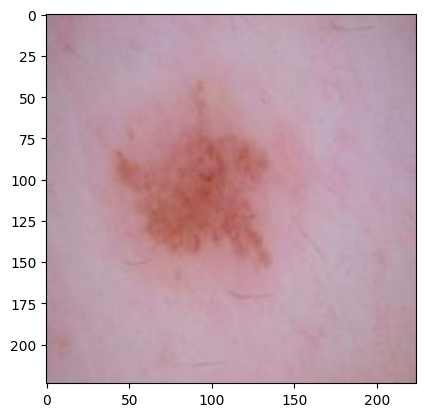

In [ ]:
image_index =17
plt.imshow(x[image_index])

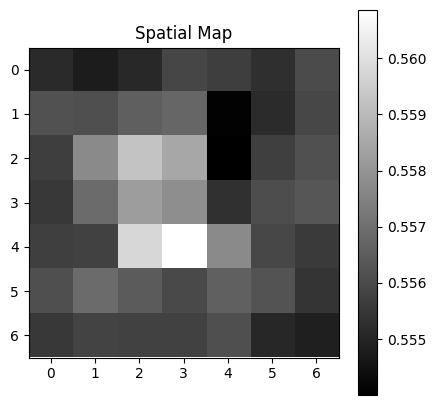

In [ ]:
plt.figure(figsize=(5, 5))
plt.title("Spatial Map")

plt.imshow(single_spatial_map[image_index], cmap='gray')
plt.colorbar()

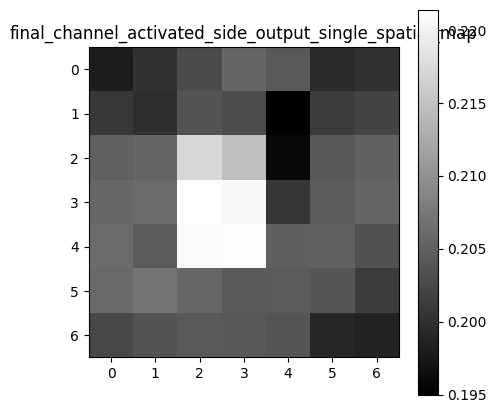

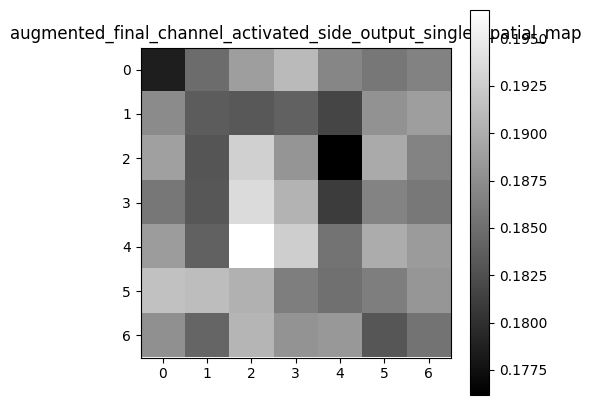

In [ ]:
plt.figure(figsize=(5, 5))
plt.title("final_channel_activated_side_output_single_spatial_map")
plt.imshow(final_channel_activated_side_output_single_spatial_map[image_index], cmap='gray')
plt.colorbar()
plt.show()


plt.figure(figsize=(5, 5))
plt.title("augmented_final_channel_activated_side_output_single_spatial_map")
plt.imshow(augmented_final_channel_activated_side_output_single_spatial_map[image_index], cmap='gray')
plt.colorbar()
plt.show()

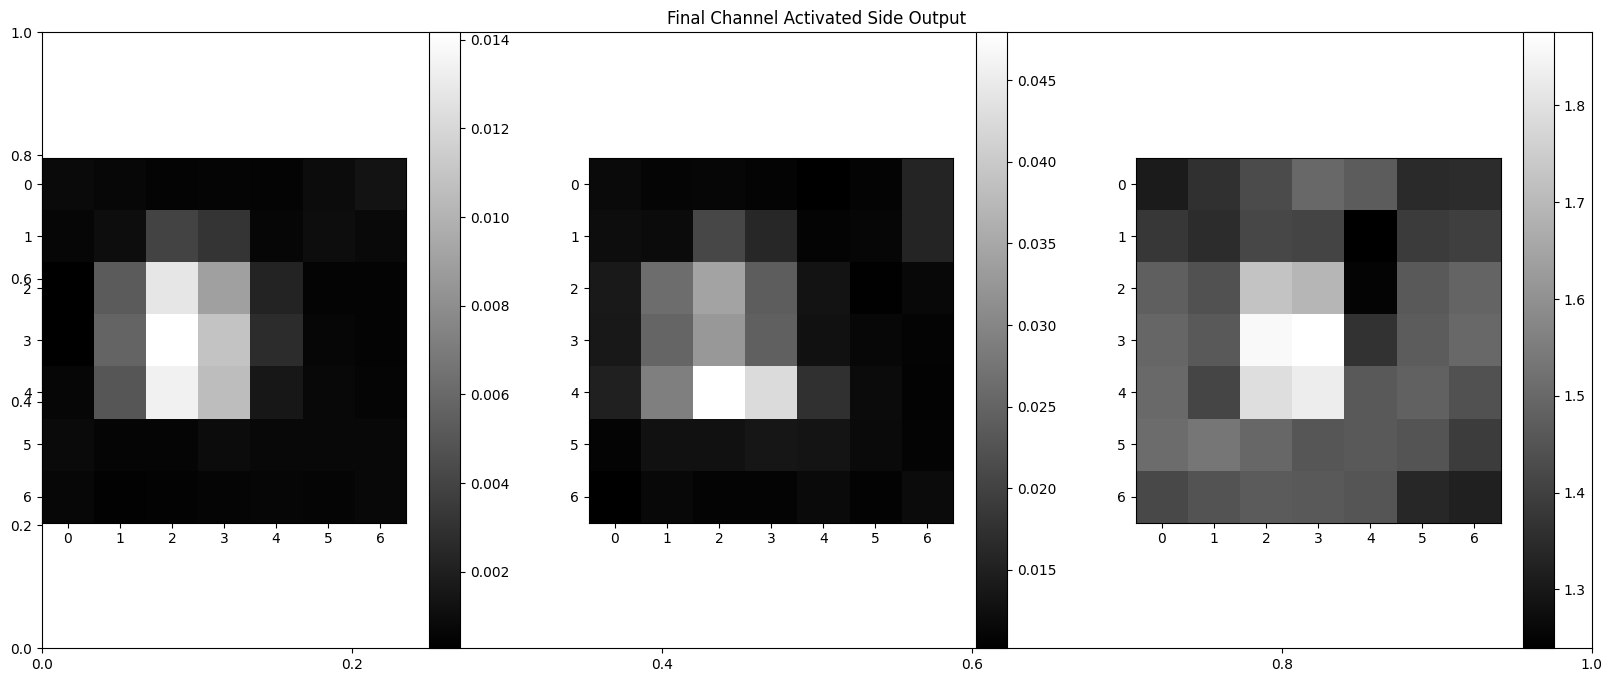

In [ ]:
plt.figure(figsize=(20, 8))
plt.title("Final Channel Activated Side Output")

temp_map = np.ones((7,7))
for i in range(3):
  plt.subplot(1, 3, i+1)
  map = channel_pruning_layer(final_channel_activated_side_output[i])[image_index]
  temp_map = np.multiply(temp_map, map)
  plt.imshow(map, cmap='gray')
  plt.colorbar()

TypeError: Invalid shape (7, 7, 7) for image data

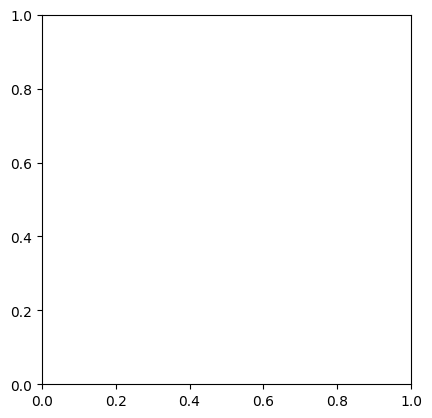

In [ ]:
plt.imshow(temp_map, cmap='gray')
plt.colorbar()

In [ ]:
plt.figure(figsize=(20, 8))
plt.title("Side Output")

for i in range(3):
  plt.subplot(1, 3, i+1)
  map = channel_pruning_layer(side_outputs[i])[image_index]
  plt.imshow(map, cmap='gray')
  plt.colorbar()

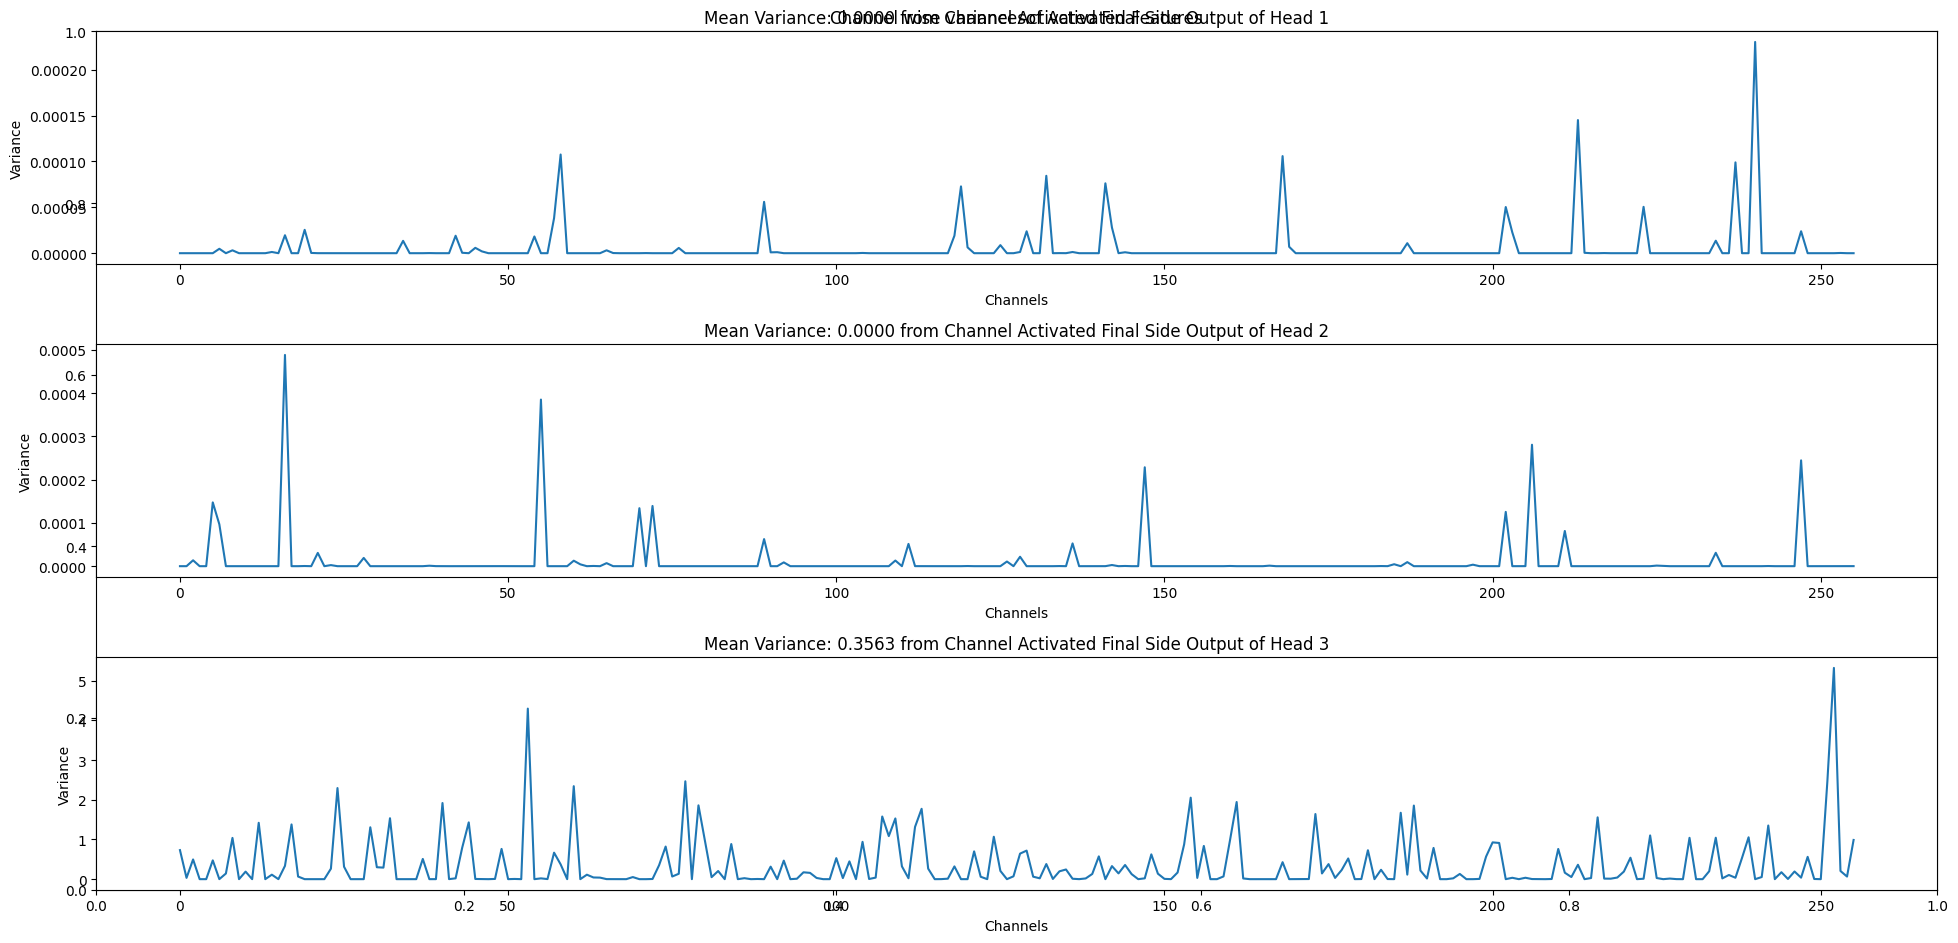

In [ ]:
plt.figure(figsize=(20, 10))
plt.title("Channel wise variancesof Activated Features")
for i in range(3):
  plt.subplot(3, 1, i+1)
  plt.plot(np.var(final_channel_activated_side_output[i][image_index], axis=(0,1))[:256])
  mean_var = np.mean(np.var(final_channel_activated_side_output[i][image_index], axis=(0,1))[:256])
  plt.title(f"Mean Variance: {mean_var:.4f} from Channel Activated Final Side Output of Head {i+1}")
  plt.xlabel("Channels")
  plt.ylabel("Variance")
plt.tight_layout()

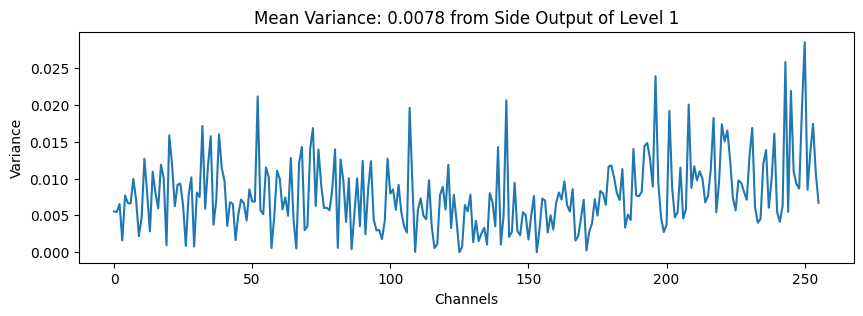

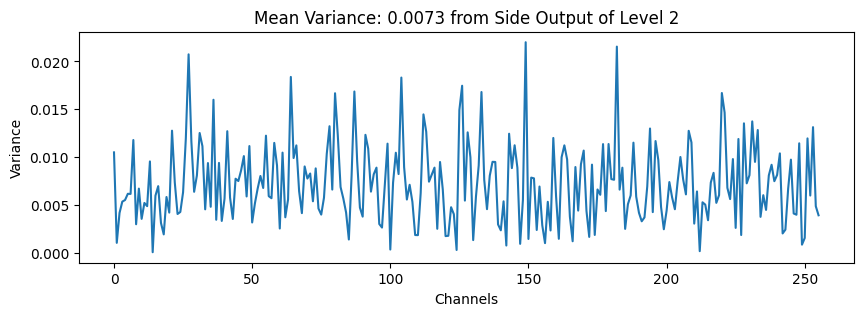

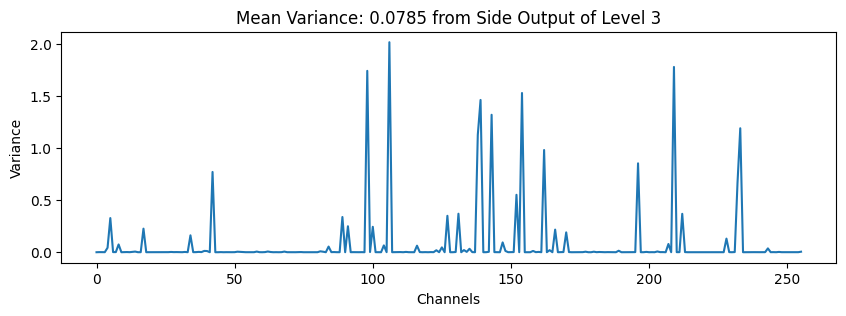

In [ ]:
# plt.figure(figsize=(20, 8))
for i in range(3):
  # plt.subplot(3, 1, i+1)
  plt.figure(figsize=(10, 3))
  plt.plot(np.var(side_outputs[i][image_index], axis=(0,1))[:256])
  mean_var = np.mean(np.var(side_outputs[i][image_index], axis=(0,1))[:256])
  plt.title(f"Mean Variance: {mean_var:.4f} from Side Output of Level {i+1}")
  plt.xlabel("Channels")
  plt.ylabel("Variance")
  plt.show()
# plt.tight_layout()


## Under Dev

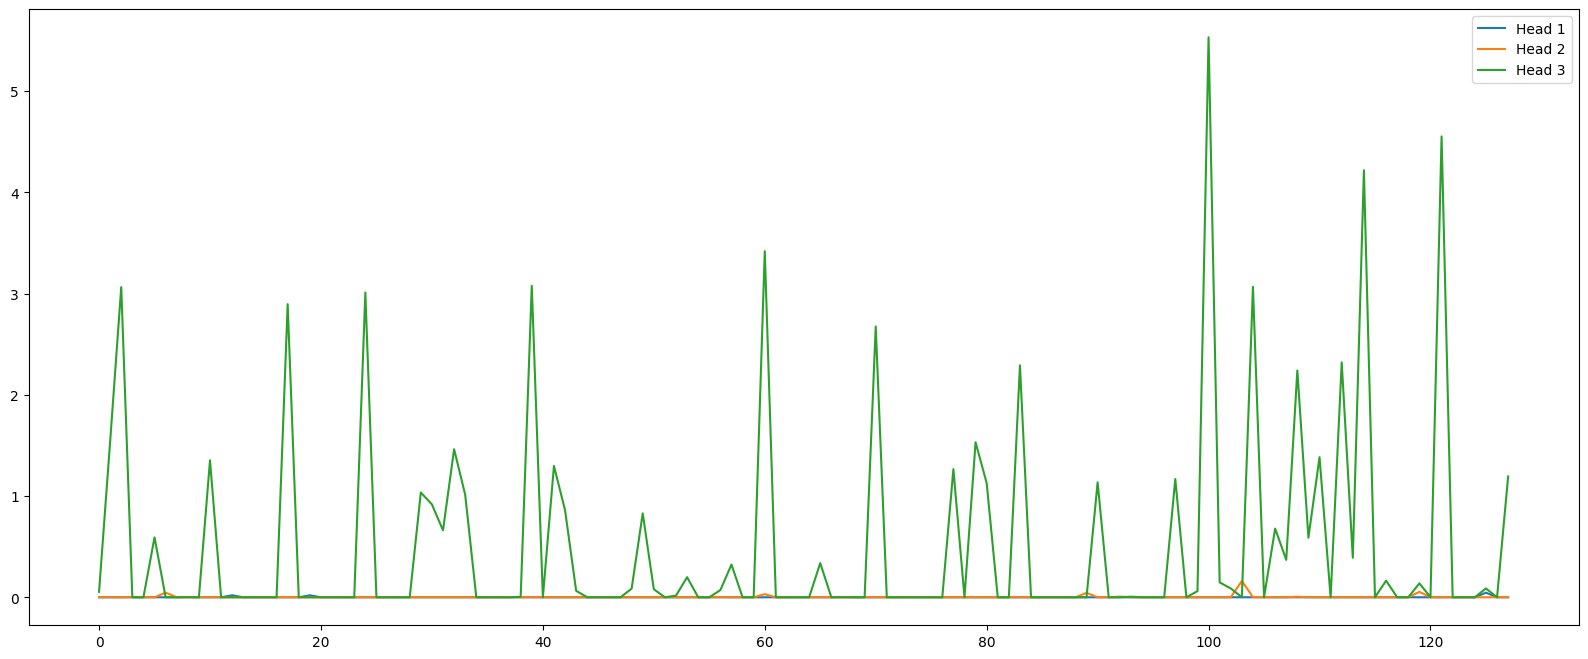

[[ 1.         -0.01145021 -0.00639797]
 [-0.01145021  1.         -0.00912078]
 [-0.00639797 -0.00912078  1.        ]]


<Figure size 640x480 with 0 Axes>

In [ ]:
fig, ax = plt.subplots(figsize=(20, 8))
sample_ind = 0
coo_i, coo_j = 3, 1

all_channel_vectors = []

for head_i in range(3):
    channel_vector = final_channel_activated_side_output[head_i][sample_ind, coo_i, coo_j].numpy()[:]
    all_channel_vectors.append(channel_vector)
    plt.plot(channel_vector[:128],label=f"Head {head_i+1}")

plt.legend()
plt.show()
combined_matrix = np.stack(all_channel_vectors)

cross_corr_matrix = np.corrcoef(combined_matrix)
print(cross_corr_matrix)

cax = ax.imshow(cross_corr_matrix, cmap="viridis", aspect="auto")
fig.colorbar(cax, ax=ax)


ax.set_title("Cross-Correlation Across All Heads")
ax.set_xlabel("Heads")
ax.set_ylabel("Heads")
ax.set_xticks(range(3))
ax.set_yticks(range(3))
ax.set_xticklabels([f"Head {i+1}" for i in range(3)])
ax.set_yticklabels([f"Head {i+1}" for i in range(3)])

plt.tight_layout()
plt.show()


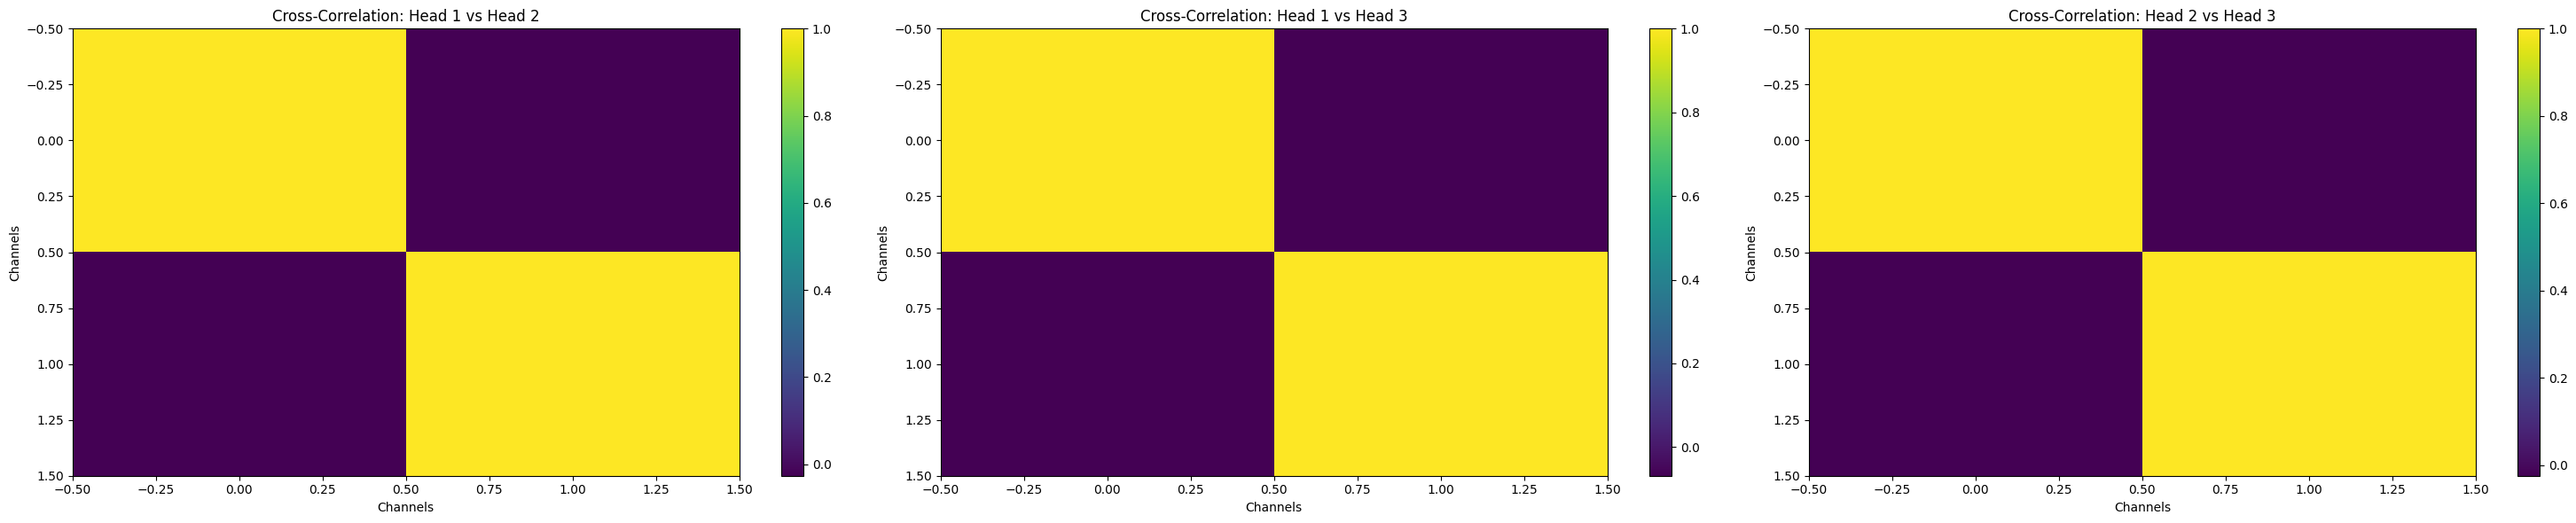

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(30, 6))
sample_ind = 0
coo_i, coo_j = 3, 1

head_pairs = []
for head_i in range(3):
    for head_j in range(head_i + 1, 3):
        head_pairs.append((head_i, head_j))

for idx, (head_i, head_j) in enumerate(head_pairs):
    channel_vector_i = final_channel_activated_side_output[head_i][sample_ind, coo_i, coo_j].numpy()[:128]
    channel_vector_j = final_channel_activated_side_output[head_j][sample_ind, coo_i, coo_j].numpy()[:128]

    # Compute cross-correlation matrix
    cross_corr_matrix = np.corrcoef(channel_vector_i, channel_vector_j)

    # Plot the cross-correlation matrix
    ax = axes[idx]
    cax = ax.imshow(cross_corr_matrix, cmap="viridis", aspect="auto")
    fig.colorbar(cax, ax=ax)

    ax.set_title(f"Cross-Correlation: Head {head_i + 1} vs Head {head_j + 1}")
    ax.set_xlabel("Channels")
    ax.set_ylabel("Channels")

plt.tight_layout()
plt.show()


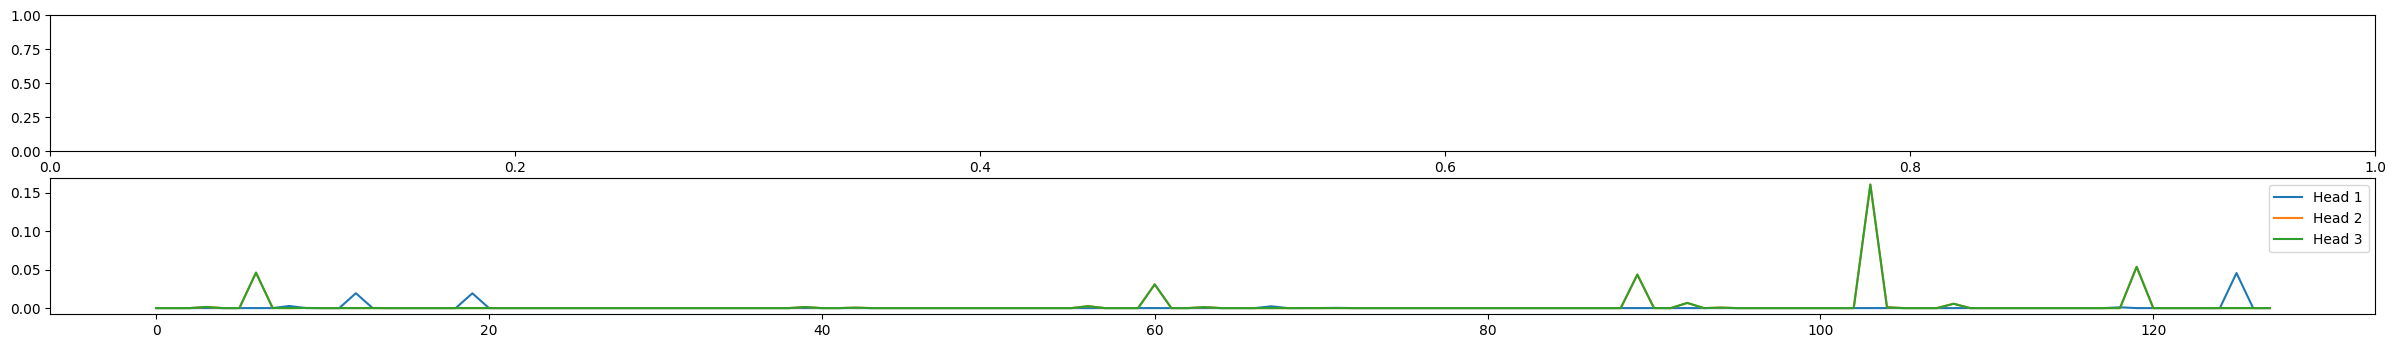

In [ ]:
plt.figure(figsize=(30, 6))
sample_ind = 0
coo_i, coo_j = 3,1
for head_i in range(3):
  for head_j in range(head_i+1, 3):
    channel_vector_i = final_channel_activated_side_output[head_i][sample_ind, coo_i, coo_j].numpy()[:128]
    channel_vector_j = final_channel_activated_side_output[head_j][sample_ind, coo_i, coo_j].numpy()[:128]
    cross_corr_matrix = np.corrcoef(channel_vector_i, channel_vector_j)
    plt.subplot(coo_i, coo_j, head_i*0+head_j+1)

  plt.plot(channel_vector_i, label=f"Head {head_i+1}")

plt.legend()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_cosine_similarity(tensors):
    """
    Computes and plots the cosine similarity matrix (H x H) among multiple tensor heads.

    Args:
        tensors (list of np.ndarray): List of H tensors, each of shape (samples, vector_dim).
                                      H is the number of heads, samples is the batch size.

    Returns:
        np.ndarray: The computed H x H cosine similarity matrix.
    """
    # Stack tensors into shape (H, samples, vector_dim)
    tensors = np.stack(tensors)  # Shape: (H, samples, vector_dim)
    H, samples, vector_dim = tensors.shape

    # Compute cosine similarity matrix (H x H)
    cosine_matrix = np.zeros((H, H))

    for i in range(H):
        for j in range(H):
            # Compute cosine similarity per sample, then average over all samples
            similarities = [
                np.dot(tensors[i, s], tensors[j, s]) /
                (np.linalg.norm(tensors[i, s]) * np.linalg.norm(tensors[j, s]) + 1e-8)
                for s in range(samples)
            ]
            cosine_matrix[i, j] = np.mean(similarities)

    # Plot the heatmap
    plt.figure(figsize=(6, 5))
    sns.heatmap(cosine_matrix, annot=True, vmin=0, vmax=1,
                xticklabels=[f"H{i}" for i in range(H)], yticklabels=[f"H{i}" for i in range(H)])
    plt.title("Cosine Similarity Matrix among Heads")
    plt.xlabel("Heads")
    plt.ylabel("Heads")
    plt.show()

    return cosine_matrix

In [ ]:
correlation_matrix = plot_cosine_similarity([tf.reshape(z[0], (32,-1)) for z in augmented_final_side_output])

NameError: name 'plot_cosine_similarity' is not defined

In [ ]:
correlation_matrix

array([[0.99999589, 0.00825641, 0.05327951],
       [0.00825641, 0.99999999, 0.02381929],
       [0.05327951, 0.02381929, 1.        ]])